In [1]:
%load_ext autoreload

# from sammbhb import quasar_based as qb
import pickle
import numpy as np
import pandas as pd

import astropy.constants as const
import astropy.coordinates as coord
import astropy.units as u
from astropy.cosmology import WMAP9 as cosmo

from astroquery.ipac.irsa.irsa_dust import IrsaDust
import extinction

from scipy.interpolate import interp1d

from IPython.display import display, Math, clear_output

In [2]:
# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# context = 'talk'
# sns.set_context(context, font_scale=1.25)
context = 'paper'
sns.set_context(context, font_scale=1)
sns.set_style('ticks')
sns.set_palette('colorblind')
rcparams = {'font.family': 'DejaVu Sans',
            'font.serif': 'Times',
            'lines.markersize': np.sqrt(10),
            'text.latex.preamble': r'\\usepackage{amsmath}',
            'text.usetex': False,
            # 'figure.figsize': [12.8, 9.6],
            'xtick.direction': 'in',
            # 'xtick.top': True,
            'xtick.minor.visible': True,
            'ytick.minor.visible': True,
            'ytick.right': True,
            'ytick.direction': 'in'}
plt.rcParams.update(rcparams)
cs = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Quasar Luminosity Function

While the bulk of this notebook is focused on analyzing the CRTS sample of periodic quasar candidates, it will be prudent to compare this to the general quasar population. Therefore we first import and initialize the QLF from Shen et al. (2020).

In [3]:
import sys
sys.path.insert(0, '../')

from src.models.qlf import ChebyshevSeriesParameter
from src.models.qlf import DoublePowerLawParameter
from src.models.qlf import DoublePowerLawQLF

from src.utils import nquad_vec

import h5py

In [4]:
with h5py.File('../data/processed/shen_qlf_low_slope_samples.h5', 'r') as hf:
    a0 = np.array(hf['a0'])
    a1 = np.array(hf['a1'])
    a2 = np.array(hf['a2'])

with h5py.File('../data/processed/shen_qlf_high_slope_samples.h5', 'r') as hf:
    b0 = np.array(hf['norm'])
    b1 = np.array(hf['low_slope'])
    b2 = np.array(hf['high_slope'])

with h5py.File('../data/processed/shen_qlf_log_break_samples.h5', 'r') as hf:
    c0 = np.array(hf['norm'])
    c1 = np.array(hf['low_slope'])
    c2 = np.array(hf['high_slope'])

with h5py.File('../data/processed/shen_qlf_log_norm_samples.h5', 'r') as hf:
    d0 = np.array(hf['a0'])
    d1 = np.array(hf['a1'])

In [5]:
# first we initialize models for the double power law parameters
low_slope = ChebyshevSeriesParameter(np.transpose([a0, a1, a2]))
high_slope = DoublePowerLawParameter(a0=b0, a1=b1, a2=b2)
log_break = DoublePowerLawParameter(a0=c0, a1=c1, a2=c2)
log_norm = ChebyshevSeriesParameter(np.transpose([d0 + np.log10(.38), d1]))  # multiply by .38 for type-1 AGN fraction

# then we initialize the double power law QLF
qlf = DoublePowerLawQLF(log_norm=log_norm,
                        log_break=log_break,
                        low_slope=low_slope,
                        high_slope=high_slope)

In [6]:
# let's pickle this model
with open(r"../models/qlf_shen20.pkl", "wb") as f:
    pickle.dump(qlf, f)

In [7]:
# Next let's plot the z and log_l dependent QSO number density
log_lbol_range = np.linspace(45, 48)
z_range = np.linspace(0, 1.5)

qlf_z = np.transpose([nquad_vec(lambda log_l: qlf(log_l, z), [[45, 48]], n_roots=50) for z in z_range])
qlf_z_q = np.quantile(qlf_z, q=[.16, .5, .84], axis=0)

qlf_log_l = np.transpose([nquad_vec(lambda z: qlf(log_l, z), [[0, 1.5]], n_roots=50) for log_l in log_lbol_range])
qlf_log_l_q = np.quantile(qlf_log_l, q=[.16, .5, .84], axis=0)

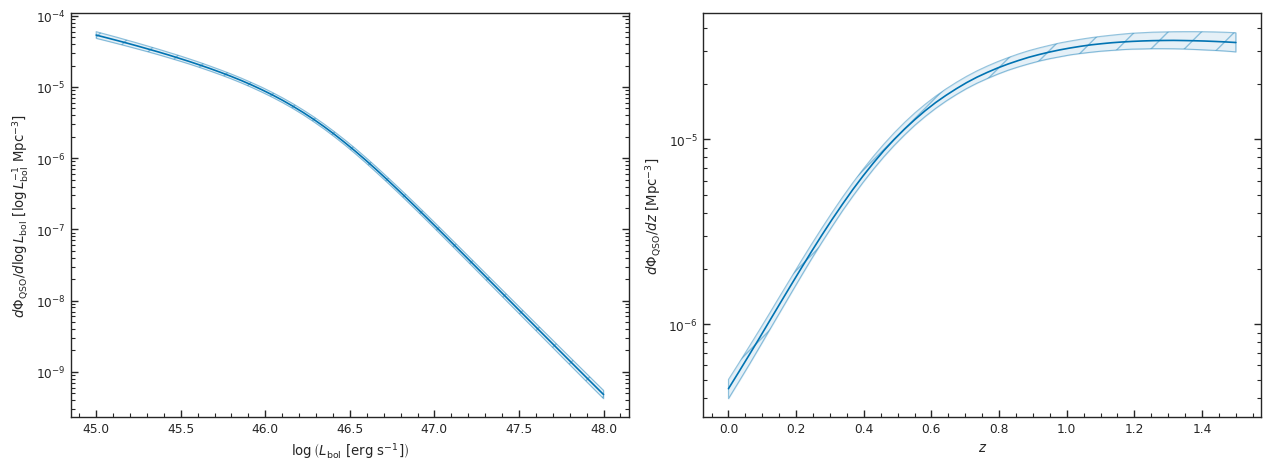

In [8]:
# adjust figsize for the number of columns we have
figsize = [2 * plt.rcParams['figure.figsize'][0],
           plt.rcParams['figure.figsize'][1]]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)

ax[0].plot(log_lbol_range, qlf_log_l_q[1], color=cs[0])
ax[0].fill_between(log_lbol_range, qlf_log_l_q[0], qlf_log_l_q[2],
                   color=cs[0], alpha=.1)
ax[0].fill_between(log_lbol_range, qlf_log_l_q[0], qlf_log_l_q[2],
                   facecolor="none", edgecolor=cs[0], hatch='/', alpha=.4)

ax[0].set_yscale('log')
ax[0].set_xlabel(r"$\log\left(L_{\rm bol}~[\rm{erg}~\rm{s}^{-1}]\right)$")
ax[0].set_ylabel(r"$d\Phi_{\rm QSO} / d\log L_{\rm bol}~[\log L_{\rm bol}^{-1}~\rm{Mpc}^{-3}]$")

ax[1].plot(z_range, qlf_z_q[1], color=cs[0])
ax[1].fill_between(z_range, qlf_z_q[0], qlf_z_q[2],
                   color=cs[0], alpha=.1)
ax[1].fill_between(z_range, qlf_z_q[0], qlf_z_q[2],
                   facecolor="none", edgecolor=cs[0], hatch='/', alpha=.4)

ax[1].set_yscale('log')
ax[1].set_xlabel(r"$z$")
ax[1].set_ylabel(r"$d\Phi_{\rm QSO} / dz~[\rm{Mpc}^{-3}]$")

plt.tight_layout()
plt.show()

# CRTS Catalog

In [9]:
with open('../data/external/Graham2015.tsv') as f:
    crts_candidates = pd.read_csv(f, sep='\t', header=0, skiprows=[1, 2]) #, usecols=[0, 1, 2, 3, 4, 5, 6])

crts_candidates['logMBH'] = pd.to_numeric(crts_candidates['logMBH'], errors='coerce')
crts_candidates['r'] = pd.to_numeric(crts_candidates['r'], errors='coerce')
crts_candidates['tinsp'] = pd.to_numeric(crts_candidates['tinsp'], errors='coerce')
crts_candidates['DtGW'] = pd.to_numeric(crts_candidates['DtGW'], errors='coerce')

crts_candidates['f_gw'] = (2 / (crts_candidates['Per'].to_numpy() * u.day)).to(u.Hz).value  # unequal mass binaries
# crts_candidates['f_gw'] = (10 / (crts_candidates['Per'].to_numpy() * u.day)).to(u.Hz).value  # equal mass binaries

crts_candidates['log_f_gw'] = np.log10(crts_candidates['f_gw'])
crts_candidates = crts_candidates.rename(columns={"logMBH": "log_mbh", "Vmed": "v_app"})
crts_candidates

,Name,RAJ2000,DEJ2000,z,v_app,Per,log_mbh,r,tinsp,DtGW,LC,SimbadName,f_gw,log_f_gw
0,UM 211,00 12 10.90,-01 22 07.6,1.998,17.38,1886,NaN,NaN,NaN,NaN,lightcurves0.png,UM 211,1.227367e-08,-7.911025
1,UM 234,00 23 03.20,+01 15 33.9,0.729,17.82,1818,9.19,0.011,12000.0,3.01,lightcurves0.png,UM 234,1.273275e-08,-7.895078
2,SDSS J014350.13+141453.0,01 43 50.00,+14 14 54.9,1.438,17.68,1538,9.21,0.008,2800.0,2.35,lightcurves0.png,SDSS J014350.13+141453.0,1.505081e-08,-7.822440
3,PKS 0157+011,02 00 03.90,+01 25 12.6,1.170,18.04,1052,NaN,NaN,NaN,NaN,lightcurves0.png,PKS 0157+011,2.200394e-08,-7.657499
4,RX J024252.3-232633,02 42 51.90,-23 26 34.0,0.680,19.01,1818,NaN,NaN,NaN,NaN,lightcurves0.png,RX J024252.3-232633,1.273275e-08,-7.895078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,BZQJ2156-2012,21 56 33.70,-20 12 30.2,1.309,17.01,1333,NaN,NaN,NaN,NaN,lightcurves10.png,[MGL2009] BZQ J2156-2012,1.736545e-08,-7.760314
107,SDSS J221016.97+122213.9,22 10 17.00,+12 22 14.0,0.717,18.32,1333,9.00,0.008,11000.0,1.35,lightcurves10.png,SDSS J221016.97+122213.9,1.736545e-08,-7.760314
108,6QZ J221925.1-305408,22 19 25.20,-30 54 08.1,0.579,19.15,1408,NaN,NaN,NaN,NaN,lightcurves10.png,2QZ J221925.1-305408,1.644045e-08,-7.784086
109,HS 2219+1944,22 22 21.10,+19 59 48.1,0.211,16.33,1724,NaN,NaN,NaN,NaN,lightcurves10.png,HS 2219+1944,1.342700e-08,-7.872021


In [10]:
with open('../data/external/sdss_confirmed_qsos_crts.csv') as f:
    sdss_confirmed_crts_candidates = pd.read_csv(f, sep=',')

sdss_confirmed_crts_candidates

,Name,RAJ2000,DEJ2000,z,Vmed,Per,logMBH,r,tinsp,DtGW,LC,SimbadName,RAJ2000.1,Class,QSO,FNUV,DEJ2000.1,z.1
0,UM 234,5.763333,1.259417,0.729,17.82,1818,9.19,0.011,12000.0,3.01,lightcurves0.png,UM 234,5.763136,3,1,35.9188,1.259334,0.729000
1,PKS 0157+011,30.016250,1.420167,1.170,18.04,1052,NaN,NaN,NaN,NaN,lightcurves0.png,PKS 0157+011,30.016409,0,1,30.6458,1.419977,1.163912
2,US 3204,42.370417,1.156944,0.954,18.09,1666,8.95,0.008,17000.0,1.03,lightcurves0.png,US 3204,42.370274,0,1,0.0021,1.156838,0.953672
3,SDSS J080237.60+340446.3,120.656667,34.079611,1.119,18.40,1428,8.96,0.007,8800.0,0.94,lightcurves1.png,SDSS J080237.60+340446.3,120.656682,0,1,24.1155,34.079533,1.121649
4,SDSS J080648.65+184037.0,121.702500,18.677028,0.745,20.61,892,7.99,0.003,170000.0,0.02,lightcurves1.png,,121.702723,30,1,0.0412,18.676967,0.745000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,SDSS J165136.76+434741.3,252.903333,43.794972,1.604,18.13,1923,9.34,0.010,2600.0,4.12,lightcurves9.png,SDSS J165136.76+434741.3,252.903197,0,1,14.2583,43.794810,1.605951
74,SDSS J170616.24+370927.0,256.567500,37.157500,1.267,18.19,1388,9.10,0.007,3900.0,1.57,lightcurves10.png,SDSS J170616.24+370927.0,256.567676,0,1,14.3845,37.157504,1.267500
75,FBQS J17239+3748,260.976250,37.811583,0.828,17.55,1960,9.38,0.013,6000.0,6.05,lightcurves10.png,FBQS J1723+3748,260.976264,3,1,80.9764,37.811474,0.828000
76,SDSS J172656.96+600348.5,261.737083,60.063639,0.991,18.50,1923,9.15,0.010,11000.0,2.33,lightcurves10.png,SDSS J172656.96+600348.5,261.737334,0,1,-1.0000,60.063481,0.989528


In [11]:
sdss_confirmed_crts_candidates[sdss_confirmed_crts_candidates['z'] <= 1.5]

,Name,RAJ2000,DEJ2000,z,Vmed,Per,logMBH,r,tinsp,DtGW,LC,SimbadName,RAJ2000.1,Class,QSO,FNUV,DEJ2000.1,z.1
0,UM 234,5.763333,1.259417,0.729,17.82,1818,9.19,0.011,12000.0,3.01,lightcurves0.png,UM 234,5.763136,3,1,35.9188,1.259334,0.729000
1,PKS 0157+011,30.016250,1.420167,1.170,18.04,1052,NaN,NaN,NaN,NaN,lightcurves0.png,PKS 0157+011,30.016409,0,1,30.6458,1.419977,1.163912
2,US 3204,42.370417,1.156944,0.954,18.09,1666,8.95,0.008,17000.0,1.03,lightcurves0.png,US 3204,42.370274,0,1,0.0021,1.156838,0.953672
3,SDSS J080237.60+340446.3,120.656667,34.079611,1.119,18.40,1428,8.96,0.007,8800.0,0.94,lightcurves1.png,SDSS J080237.60+340446.3,120.656682,0,1,24.1155,34.079533,1.121649
4,SDSS J080648.65+184037.0,121.702500,18.677028,0.745,20.61,892,7.99,0.003,170000.0,0.02,lightcurves1.png,,121.702723,30,1,0.0412,18.676967,0.745000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,HS 1630+2355,248.261250,23.824667,0.821,15.23,2040,9.86,0.020,1100.0,38.71,lightcurves9.png,HS 1630+2355,248.261102,0,1,267.0965,23.824588,0.820884
74,SDSS J170616.24+370927.0,256.567500,37.157500,1.267,18.19,1388,9.10,0.007,3900.0,1.57,lightcurves10.png,SDSS J170616.24+370927.0,256.567676,0,1,14.3845,37.157504,1.267500
75,FBQS J17239+3748,260.976250,37.811583,0.828,17.55,1960,9.38,0.013,6000.0,6.05,lightcurves10.png,FBQS J1723+3748,260.976264,3,1,80.9764,37.811474,0.828000
76,SDSS J172656.96+600348.5,261.737083,60.063639,0.991,18.50,1923,9.15,0.010,11000.0,2.33,lightcurves10.png,SDSS J172656.96+600348.5,261.737334,0,1,-1.0000,60.063481,0.989528


## Bolometric Luminosity

In [12]:
CRTS_EFF_WAVELENGTH = 5237.44  # angstroms, Tachibana+ 2020
CRTS_F0 = (3.968e-9 * u.erg / u.s / (u.cm ** 2) / u.angstrom)  # Tachibana+ 2020
CRTS_F0 = CRTS_F0.to(u.erg / u.s / (u.Mpc ** 2) / u.angstrom).value  # Zero point flux in erg / s / Mpc^2

V_APP_COMPLETE_CRTS = 19  # CRTS completeness limit, Graham+ 2015
V_APP_MAX_CRTS = 21.5  # CRTS maximum depth (incomplete), Graham+ 2015
V_LSST = 25  # 27.9 after 10 years

SHEN2020_EFF_WAVELENGTH = 4400.  # angstroms, Shen+ 2020

In [13]:
LOG_L_SOLAR = np.log10(u.Lsun.to(u.erg / u.s))  # solar luminosity in erg/s

def get_extinction(ra, dec, eff_wav=CRTS_EFF_WAVELENGTH):
    """Get the magnitudes of dust extinction for objects at a given sky coordinate.
    
    Params
    ______
    ra : str or array_like of str
        Right ascension in hour angles
    dec : str of array_like of str
        Declination in degrees
        
    Returns
    -------
    v_ext : float
        Magnitudes of dust extinction
    
    """
    coo = coord.SkyCoord(ra, dec, unit=(u.hourangle, u.deg)).to_string('hmsdms')
    ext_table = [IrsaDust.get_extinction_table(c) for c in coo]
    A_SFD = np.squeeze(np.array([tab[tab['Filter_name'] == 'CTIO V']['A_SandF'].value for tab in ext_table]))
    v_ext = np.squeeze([extinction.odonnell94(np.array([eff_wav]), A, 3.1) for A in A_SFD])
    return v_ext


def apparent_to_absolute_mag(v_app, z, v_ext=0, k_cor=0, cosmo=cosmo):
    """Convert apparent magnitude to an absolute magnitude.
    
    """
    if isinstance(v_app, pd.Series):
        v_app = v_app.values
    if isinstance(v_ext, pd.Series):
        v_ext = v_ext.values
    if isinstance(z, pd.Series):
        z = z.values
        
    lum_dist = cosmo.luminosity_distance(z).to(u.pc).value  # pc
    
    v_app = v_app - v_ext  # correct for dust extinction if present
    v_app = v_app - k_cor
    V_abs = v_app - (5 * np.log10(lum_dist)) + 5
    return V_abs


def apparent_mag_to_log_flux(v_app, v_ext=0, k_cor=0, cosmo=cosmo):
    if isinstance(v_app, pd.Series):
        v_app = v_app.values
    if isinstance(v_ext, pd.Series):
        v_ext = v_ext.values
    
    v_app = v_app - v_ext  # correct for dust extinction if present
    v_app = v_app - k_cor
    log_flux = np.log10(CRTS_F0) + np.log10(SHEN2020_EFF_WAVELENGTH) - (v_app / 2.5)  # erg / (s * (Mpc ** 2))
    return log_flux

def apparent_mag_to_log_luminosity(v_app, z, v_ext=0, k_cor=0, cosmo=cosmo):
    if isinstance(v_app, pd.Series):
        v_app = v_app.values
    if isinstance(v_ext, pd.Series):
        v_ext = v_ext.values
    if isinstance(z, pd.Series):
        z = z.values
        
    lum_dist = cosmo.luminosity_distance(z).value
    
    log_flux = apparent_mag_to_log_flux(v_app, v_ext=v_ext, k_cor=k_cor)
    log_lum = np.log10(4 * np.pi) + 2 * np.log10(lum_dist) + log_flux
    return log_lum


def log_lbol_to_log_lband(log_lum_bol, c1, k1, c2, k2):
    denom = c1 * 10 ** ((k1 - 1) * (log_lum_bol - (10 + LOG_L_SOLAR)))
    denom += c2 * 10 ** ((k2 - 1) * (log_lum_bol - (10 + LOG_L_SOLAR)))
    log_denom = np.log10(denom)
    
    return 10 + LOG_L_SOLAR - log_denom

# initialize optical to bolometric luminosity conversion
log_lum_bol = np.linspace(42, 50, num=1000)
log_lum_opt = log_lbol_to_log_lband(log_lum_bol, 3.759, -.361, 9.830, -.0063)  # Shen+ 2020 values

log_lband_to_log_lbol = interp1d(log_lum_opt, log_lum_bol, bounds_error=None, fill_value='extrapolate')

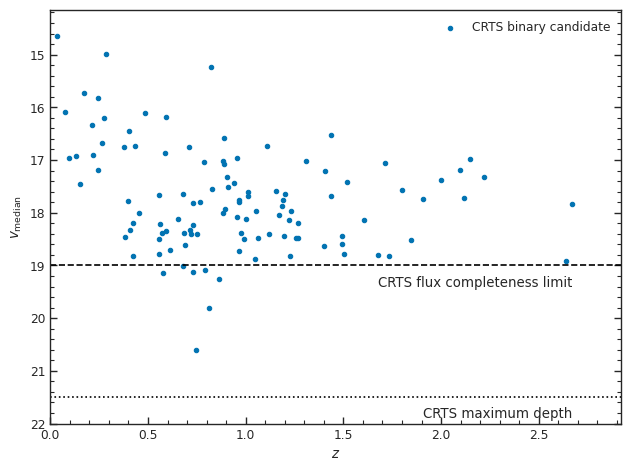

In [14]:
plt.figure()

plt.scatter(crts_candidates['z'], crts_candidates['v_app'], color=cs[0], label='CRTS binary candidate')
plt.axhline(
    V_APP_COMPLETE_CRTS, 
    color='k',
    linestyle='--',
    # label='CRTS flux completeness limit'
)
plt.annotate(
    'CRTS flux completeness limit',
    (crts_candidates['z'].max(), V_APP_COMPLETE_CRTS),
    textcoords='offset pixels',
    xytext=(0, -10),
    ha='right',
    va='top',
)
plt.axhline(
    V_APP_MAX_CRTS, 
    color='k', 
    linestyle=':', 
    # label='CRTS maximum depth'
)
plt.annotate(
    'CRTS maximum depth',
    (crts_candidates['z'].max(), V_APP_MAX_CRTS),
    textcoords='offset pixels',
    xytext=(0, -10),
    ha='right',
    va='top',
)
# plt.plot(z_plot, completeness_limit_crts(z_plot), color='k', linestyle='--', label=r'CRTS Flux Complete, $V = 19$')
# plt.plot(z_plot, incomplete_flux_limit_crts(z_plot), color='k', linestyle='-.', label=r'CRTS Flux Limit, $V = 21.5$')
# plt.plot(z_plot, completeness_limit_lsst(z_plot), color='k', linestyle=':', label=r'LSST Flux Limit, $V = 27.9$')

plt.xlabel(r'$z$')
plt.ylabel(r'$v_{\rm median}$')

x_l = np.minimum(0, crts_candidates['z'].min())
x_u = np.maximum(1.5, crts_candidates['z'].max() + .25)
y_l = np.maximum(V_APP_MAX_CRTS, crts_candidates['v_app'].max()) + .5
y_u = np.minimum(V_APP_COMPLETE_CRTS, crts_candidates['v_app'].min()) - .5

plt.xlim(x_l, x_u)
plt.ylim(y_l, y_u)

plt.legend(frameon=False)

plt.tight_layout()
plt.savefig('../reports/figures/crts_binary_candidates_apparent_mags.pdf')
plt.show()

### Absolute Magnitude

In [15]:
# convert CRTS apparent magnitudes to absolute magnitudes
crts_candidates['A_ext'] = get_extinction(crts_candidates['RAJ2000'], crts_candidates['DEJ2000'])
crts_candidates['V_abs'] = apparent_to_absolute_mag(crts_candidates['v_app'], crts_candidates['z'], v_ext=crts_candidates['A_ext'])

# calculate the comparable completeness and volume limits
z_interp = np.linspace(1e-5, 3, num=1000)

V_abs_complete_crts = apparent_to_absolute_mag(V_APP_COMPLETE_CRTS, z_interp,  # CRTS completeness limit
                                               v_ext=crts_candidates['A_ext'].median())
V_abs_complete_crts_fn = interp1d(z_interp, V_abs_complete_crts,
                                  fill_value='extrapolate', bounds_error=False)

V_abs_max_crts = apparent_to_absolute_mag(V_APP_MAX_CRTS, z_interp,  # CRTS depth limit
                                          v_ext=crts_candidates['A_ext'].median())
V_abs_max_crts_fn = interp1d(z_interp, V_abs_max_crts,
                             fill_value='extrapolate', bounds_error=False)

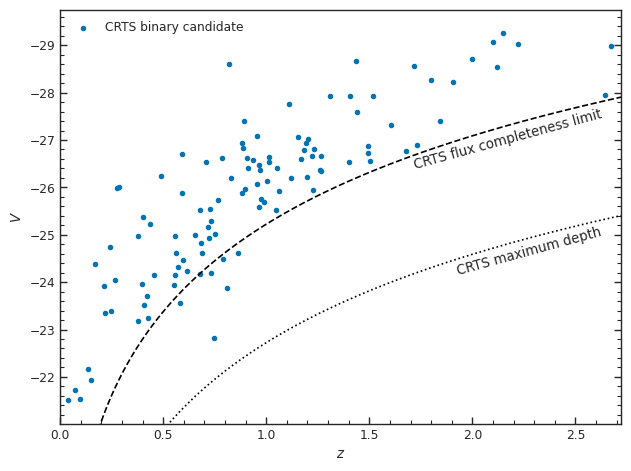

In [16]:
z_l = np.minimum(0, crts_candidates['z'].min())
z_u = np.maximum(1.5, crts_candidates['z'].max() + .05)
V_l = crts_candidates['V_abs'].max() + .5
V_u = crts_candidates['V_abs'].min() - .5

z_plot = np.linspace(z_l, z_u, num=1000)

V_APP_COMPLETE_CRTS = 19  # CRTS completeness limit
V_APP_MAX_CRTS = 21.5  # CRTS maximum depth (incomplete)
# V_LSST = 25  # 27.9 after 10 year

plt.figure()

plt.scatter(crts_candidates['z'], crts_candidates['V_abs'], color=cs[0], label='CRTS binary candidate')
plt.plot(
    z_plot, 
    V_abs_complete_crts_fn(z_plot), 
    color='k', 
    linestyle='--', 
    # label='CRTS flux completeness limit'
)
plt.text(
    z_plot[-40],
    V_abs_complete_crts_fn(z_plot[-40]) + .1,
    'CRTS flux completeness limit',
    # textcoords='offset pixels',
    # xytext=(0, -10),
    ha='right',
    va='top',
    transform_rotates_text=True, 
    rotation=-50,
    rotation_mode='anchor',
)
plt.plot(
    z_plot, 
    V_abs_max_crts_fn(z_plot), 
    color='k', 
    linestyle=':', 
    # label='CRTS maximum depth'
)
plt.text(
    z_plot[-40],
    V_abs_max_crts_fn(z_plot[-40]) + .1,
    'CRTS maximum depth',
    # textcoords='offset pixels',
    # xytext=(0, -10),
    ha='right',
    va='top',
    transform_rotates_text=True, 
    rotation=-50,
    rotation_mode='anchor',
)

plt.xlabel(r'$z$')
plt.ylabel(r'$V$')

plt.xlim(z_l, z_u)
plt.ylim(V_l, V_u)

plt.legend(frameon=False)

plt.tight_layout()
plt.savefig('../reports/figures/crts_binary_candidates_absolute_mags.pdf')
plt.show()

### $K$-corrections

In [17]:
# the mean SED from Krawczyk+ 2013
with open('../data/external/medianSDSSQSO_VandenBerk_01.txt') as f:
    sed_template = pd.read_csv(
        f, 
        sep='\s+', 
        skiprows=34, 
        header=None,
        names=[
            "wav",
            "flam",
            "err_flam"
        ]
    )
    np.genfromtxt

sed_template

,wav,flam,err_flam
0,833.5,1.036,0.370
1,834.5,0.094,0.262
2,835.5,0.338,0.260
3,836.5,0.332,0.232
4,837.5,1.059,0.332
...,...,...,...
7717,8550.5,0.733,0.056
7718,8551.5,0.723,0.049
7719,8552.5,0.718,0.054
7720,8553.5,0.776,0.046


In [18]:
lam = sed_template['wav'].values * u.AA
sed = (sed_template['flam'].values)
# logsed = logsed - lognu

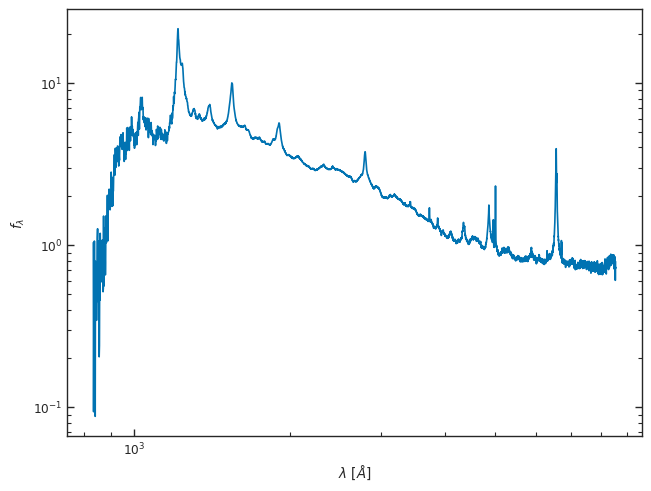

In [19]:
fig, ax = plt.subplots(constrained_layout=True)

ax.plot(lam, sed)

# ax.set_xlabel(r"$\nu~[\mathrm{Hz}]$")
# ax.set_ylabel(r"$\nu L_{\nu}~[\mathrm{erg~s^{-1}}]$")
ax.set_ylabel(r"$f_{\lambda}$")
# ax.set_xticks

# secax = ax.secondary_xaxis('top', functions=(freq_to_wavelength, wavelength_to_freq))
ax.set_xlabel(r"$\lambda~[\AA]$")

ax.set_xscale('log')
ax.set_yscale('log')

plt.show()

In [20]:
# redshifted
z_shift = .4
lam_obs = lam * (1 + z_shift)

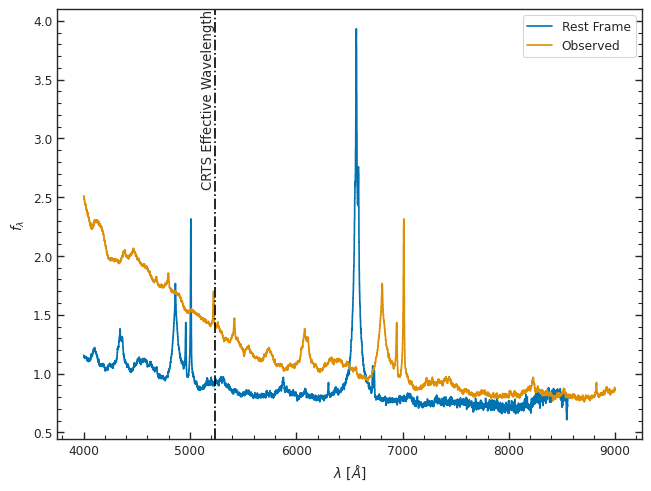

In [21]:
lam_plot_mask = (lam.value >= 4000) & (lam.value <= 9000)
lam_obs_plot_mask = (lam_obs.value >= 4000) & (lam_obs.value <= 9000)

fig, ax = plt.subplots(constrained_layout=True)

ax.plot(
    lam[lam_plot_mask],
    sed[lam_plot_mask],
    label="Rest Frame",
    drawstyle='steps-mid'
)
ax.plot(
    lam_obs[lam_obs_plot_mask], 
    sed[lam_obs_plot_mask],
    label="Observed",
    drawstyle='steps-mid'
)

# ax.axvline(4400, color='k', ls='--')
ax.axvline(CRTS_EFF_WAVELENGTH, color='k', ls='-.')
ax.annotate("CRTS Effective Wavelength",
            xy=(CRTS_EFF_WAVELENGTH, ax.get_ylim()[1]),
            ha="right",
            va="bottom",
            rotation=90,
            rotation_mode='anchor',
           )

# ax.set_xlabel(r"$\nu~[\mathrm{Hz}]$")
# ax.set_ylabel(r"$\nu L_{\nu}~[\mathrm{erg~s^{-1}}]$")
# ax.set_xticks
ax.set_ylabel(r"$f_{\lambda}$")

# secax = ax.secondary_xaxis('top', functions=(freq_to_wavelength, wavelength_to_freq))
ax.set_xlabel(r"$\lambda~[\AA]$")
# ax.set_xlim(4000, 9000)

# ax.set_xscale('log')
# ax.set_yscale('log')

plt.legend()
plt.show()

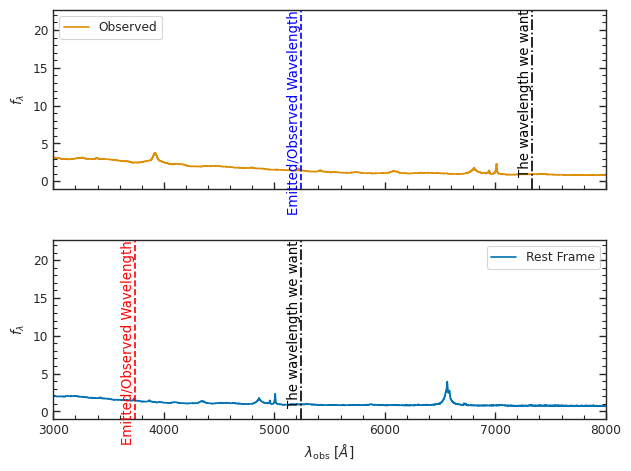

In [22]:
lam_plot_mask = (lam.value >= 4000) & (lam.value <= 9000)
lam_obs_plot_mask = (lam_obs.value >= 4000) & (lam_obs.value <= 9000)

fig, ax = plt.subplots(nrows=2, ncols=1,
                       constrained_layout=True, sharex=True)
ax[0].plot(
    lam_obs, 
    sed,
    label="Observed",
    drawstyle='steps-mid',
    color=cs[1]
)
ax[0].axvline(CRTS_EFF_WAVELENGTH, color='b', ls='--')
ax[0].annotate("Emitted/Observed Wavelength",
            xy=(CRTS_EFF_WAVELENGTH, ax[0].get_ylim()[1]),
            ha="right",
            va="bottom",
            rotation=90,
            rotation_mode='anchor',
            color='b',
           )
ax[0].axvline(CRTS_EFF_WAVELENGTH * (1 + z_shift), color='k', ls='-.')
ax[0].annotate("The wavelength we want",
            xy=(CRTS_EFF_WAVELENGTH * (1 + z_shift), ax[0].get_ylim()[1]),
            ha="right",
            va="bottom",
            rotation=90,
            rotation_mode='anchor',
            color='k'
           )

ax[1].plot(
    lam, 
    sed,
    label="Rest Frame",
    drawstyle='steps-mid',
    color=cs[0]
)
ax[1].axvline(CRTS_EFF_WAVELENGTH / (1 + z_shift), color='r', ls='--')
ax[1].annotate("Emitted/Observed Wavelength",
            xy=(CRTS_EFF_WAVELENGTH / (1 + z_shift), ax[1].get_ylim()[1]),
            ha="right",
            va="bottom",
            rotation=90,
            rotation_mode='anchor',
            color='r',
           )
ax[1].axvline(CRTS_EFF_WAVELENGTH, color='k', ls='-.')
ax[1].annotate("The wavelength we want",
            xy=(CRTS_EFF_WAVELENGTH, ax[1].get_ylim()[1]),
            ha="right",
            va="bottom",
            rotation=90,
            rotation_mode='anchor',
            color='k'
           )

ax[0].set_ylabel(r"$f_{\lambda}$")
ax[1].set_ylabel(r"$f_{\lambda}$")
ax[1].set_xlabel(r"$\lambda_{\rm obs}~[\AA]$")

ax[0].legend()
ax[1].legend()

plt.xlim(3000, 8000)
# ax[0].set_ylim(0, 5)
# ax[1].set_ylim(0, 5)

plt.tight_layout()
plt.show()

In [23]:
with open('../data/external/crts_transmission_curve.dat') as f:
    crts_transmission_fn = pd.read_csv(
        f, 
        sep='\s+', 
        header=None,
        names=[
            "wav",
            "T",
        ]
    )

crts_transmission_fn

,wav,T
0,2989.4287,0.435958
1,3099.1371,0.522047
2,3200.0320,0.572441
3,3300.9511,0.620735
4,3392.6935,0.664829
...,...,...
66,9595.8780,0.324672
67,9697.6688,0.297375
68,9799.4111,0.274278
69,9901.1535,0.251181


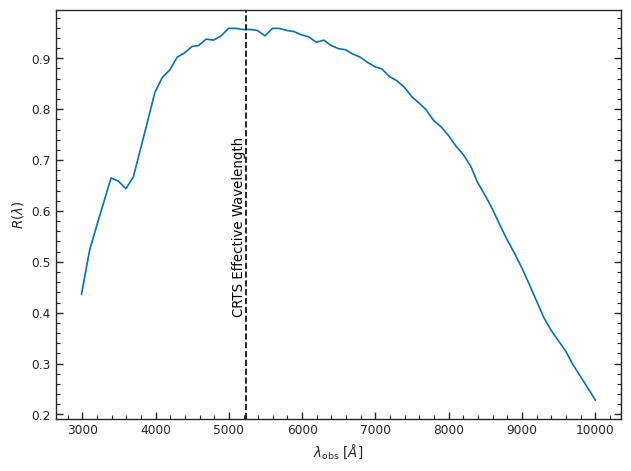

In [24]:
fig, ax = plt.subplots(constrained_layout=True)

ax.plot(
    crts_transmission_fn['wav'], 
    crts_transmission_fn['T'],
)

ax.axvline(CRTS_EFF_WAVELENGTH, color='k', ls='--')
ax.annotate("CRTS Effective Wavelength",
            xy=(CRTS_EFF_WAVELENGTH, ax.get_ylim()[1] * .75),
            ha="right",
            va="bottom",
            rotation=90,
            rotation_mode='anchor',
            color='k',
           )

ax.set_ylabel(r"$R(\lambda)$")

ax.set_xlabel(r"$\lambda_{\rm obs}~[\AA]$")

plt.tight_layout()
plt.show()

In [25]:
from scipy.interpolate import interp1d

In [26]:
sed_fn = interp1d(sed_template['wav'], sed_template['flam'], kind='nearest')
trans_fn = interp1d(crts_transmission_fn['wav'], crts_transmission_fn['T'], kind='linear')

In [27]:
def k_correction(z, alpha=-.5):
    k = alpha + 1
    k = k * np.log10(1 + z)
    k = k * -2.5
    return k

In [28]:
def k_correction_2(z, sed=sed_fn):
    lam_obs = CRTS_EFF_WAVELENGTH
    lam_em = CRTS_EFF_WAVELENGTH / (1 + z)
    lam_shen = 4400  # this is an extra correction so we're consistent with the luminosity definition in Shen+ 2020
    
    k_cor = sed(lam_shen)
    k_cor = k_cor / sed(lam_em)
    k_cor = k_cor * (1 + z)
    k_cor = 2.5 * np.log10(k_cor)
    return k_cor

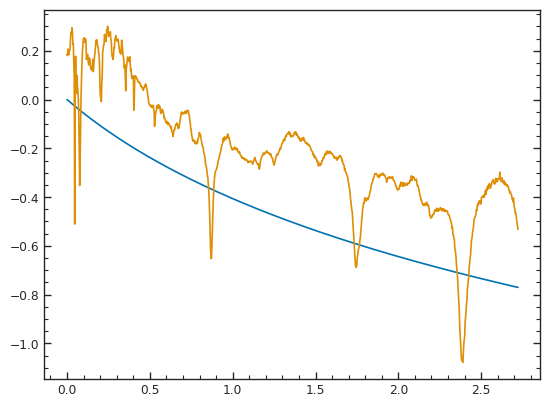

In [29]:
plt.figure()

# alpha_sed = -.5  # used by Graham+ 17, median between Vanden Berk+ 01 and Lusso+ 15
# alpha_sed = -.44  # Vanden Berk+ 01
alpha_sed = -.46  # Vanden Berk+ 01

plt.plot(z_plot, k_correction(z_plot, alpha=-.46))
plt.plot(z_plot, k_correction_2(z_plot))

plt.show()

In [30]:
crts_candidates['k_cor'] = k_correction_2(crts_candidates['z'], sed=sed_fn)
crts_candidates['V_abs_k'] = crts_candidates['V_abs'] - crts_candidates['k_cor']

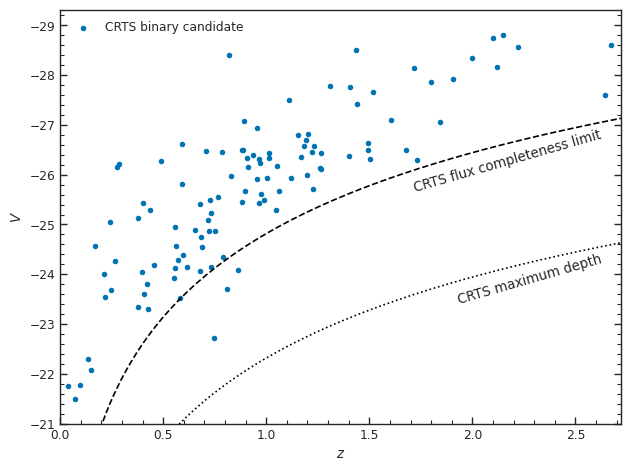

In [31]:
z_l = np.minimum(0, crts_candidates['z'].min())
z_u = np.maximum(1.5, crts_candidates['z'].max() + .05)
V_l = crts_candidates['V_abs_k'].max() + .5
V_u = crts_candidates['V_abs_k'].min() - .5

z_plot = np.linspace(z_l, z_u, num=1000)

V_APP_COMPLETE_CRTS = 19  # CRTS completeness limit
V_APP_MAX_CRTS = 21.5  # CRTS maximum depth (incomplete)
# V_LSST = 25  # 27.9 after 10 year

plt.figure()

plt.scatter(crts_candidates['z'], crts_candidates['V_abs_k'], color=cs[0], label='CRTS binary candidate')
plt.plot(
    z_plot, 
    V_abs_complete_crts_fn(z_plot) - k_correction(z_plot, alpha=alpha_sed), 
    color='k', 
    linestyle='--', 
    # label='CRTS flux completeness limit'
)
plt.text(
    z_plot[-40],
    V_abs_complete_crts_fn(z_plot[-40]) - k_correction(z_plot[-40], alpha=alpha_sed) + .1,
    'CRTS flux completeness limit',
    # textcoords='offset pixels',
    # xytext=(0, -10),
    ha='right',
    va='top',
    transform_rotates_text=True, 
    rotation=-50,
    rotation_mode='anchor',
)
plt.plot(
    z_plot, 
    V_abs_max_crts_fn(z_plot) - k_correction(z_plot, alpha=alpha_sed), 
    color='k', 
    linestyle=':', 
    # label='CRTS maximum depth'
)
plt.text(
    z_plot[-40],
    V_abs_max_crts_fn(z_plot[-40]) - k_correction(z_plot[-40], alpha=alpha_sed) + .1,
    'CRTS maximum depth',
    # textcoords='offset pixels',
    # xytext=(0, -10),
    ha='right',
    va='top',
    transform_rotates_text=True, 
    rotation=-50,
    rotation_mode='anchor',
)

plt.xlabel(r'$z$')
plt.ylabel(r'$V$')

plt.xlim(z_l, z_u)
plt.ylim(V_l, V_u)

plt.legend(frameon=False)

plt.tight_layout()
plt.savefig('../reports/figures/crts_binary_candidates_absolute_mags_k_corr.pdf')
plt.show()

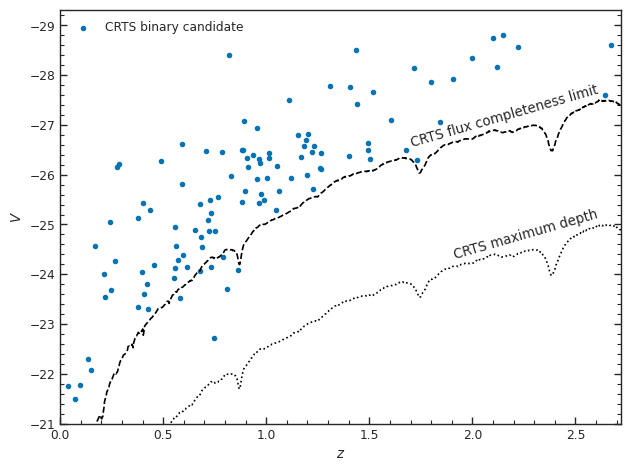

In [32]:
z_l = np.minimum(0, crts_candidates['z'].min())
z_u = np.maximum(1.5, crts_candidates['z'].max() + .05)
V_l = crts_candidates['V_abs_k'].max() + .5
V_u = crts_candidates['V_abs_k'].min() - .5

z_plot = np.linspace(z_l, z_u, num=1000)

V_APP_COMPLETE_CRTS = 19  # CRTS completeness limit
V_APP_MAX_CRTS = 21.5  # CRTS maximum depth (incomplete)
# V_LSST = 25  # 27.9 after 10 year

plt.figure()

plt.scatter(crts_candidates['z'], crts_candidates['V_abs_k'], color=cs[0], label='CRTS binary candidate')
plt.plot(
    z_plot, 
    V_abs_complete_crts_fn(z_plot) - k_correction_2(z_plot, sed=sed_fn), 
    color='k', 
    linestyle='--', 
    # label='CRTS flux completeness limit'
)
plt.text(
    z_plot[-40],
    V_abs_complete_crts_fn(z_plot[-40]) - k_correction_2(z_plot[-40], sed=sed_fn) - .1,
    'CRTS flux completeness limit',
    # textcoords='offset pixels',
    # xytext=(0, -10),
    ha='right',
    va='bottom',
    transform_rotates_text=True, 
    rotation=-50,
    rotation_mode='anchor',
)
plt.plot(
    z_plot, 
    V_abs_max_crts_fn(z_plot) - k_correction_2(z_plot, sed=sed_fn), 
    color='k', 
    linestyle=':', 
    # label='CRTS maximum depth'
)
plt.text(
    z_plot[-40],
    V_abs_max_crts_fn(z_plot[-40]) - k_correction_2(z_plot[-40], sed=sed_fn) - .1,
    'CRTS maximum depth',
    # textcoords='offset pixels',
    # xytext=(0, -10),
    ha='right',
    va='bottom',
    transform_rotates_text=True, 
    rotation=-50,
    rotation_mode='anchor',
)

plt.xlabel(r'$z$')
plt.ylabel(r'$V$')

plt.xlim(z_l, z_u)
plt.ylim(V_l, V_u)

plt.legend(frameon=False)

plt.tight_layout()
plt.savefig('../reports/figures/crts_binary_candidates_absolute_mags_k_corr_sdss.pdf')
plt.show()

### Optical Luminosities

In [33]:
# CRTS optical luminosities
crts_candidates['log_l_opt'] = apparent_mag_to_log_luminosity(crts_candidates['v_app'], crts_candidates['z'],
                                                              v_ext=crts_candidates['A_ext'], k_cor=crts_candidates['k_cor'])

# calculate the comparable completeness and volume limits
log_l_opt_complete_crts = apparent_mag_to_log_luminosity(V_APP_COMPLETE_CRTS, z_interp,  # CRTS completeness limit
                                                         v_ext=crts_candidates['A_ext'].median(), k_cor=k_correction_2(z_interp))
log_l_opt_complete_crts_fn = interp1d(z_interp, log_l_opt_complete_crts,
                                      fill_value='extrapolate', bounds_error=False)

log_l_opt_max_crts = apparent_mag_to_log_luminosity(V_APP_MAX_CRTS, z_interp,  # CRTS depth limit
                                                    v_ext=crts_candidates['A_ext'].median(), k_cor=k_correction_2(z_interp))
log_l_opt_max_crts_fn = interp1d(z_interp, log_l_opt_max_crts,
                                 fill_value='extrapolate', bounds_error=False)

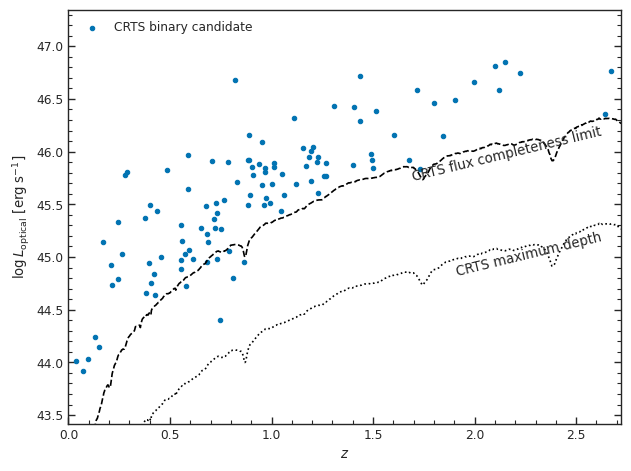

In [34]:
z_l = np.minimum(0, crts_candidates['z'].min())
z_u = np.maximum(1.5, crts_candidates['z'].max() + .05)
log_l_opt_l = crts_candidates['log_l_opt'].min() - .5
log_l_opt_u = crts_candidates['log_l_opt'].max() + .5

z_plot = np.linspace(z_l, z_u, num=1000)

plt.figure()

plt.scatter(crts_candidates['z'], crts_candidates['log_l_opt'], color=cs[0], label='CRTS binary candidate')
plt.plot(
    z_plot, 
    log_l_opt_complete_crts_fn(z_plot), 
    color='k', 
    linestyle='--', 
    # label='CRTS flux completeness limit'
)
plt.text(
    z_plot[-40],
    log_l_opt_complete_crts_fn(z_plot[-40])-.05,
    'CRTS flux completeness limit',
    # textcoords='offset pixels',
    # xytext=(0, -10),
    ha='right',
    va='top',
    transform_rotates_text=True, 
    rotation=25,
    rotation_mode='anchor',
)
plt.plot(
    z_plot,
    log_l_opt_max_crts_fn(z_plot), 
    color='k', 
    linestyle=':', 
    # label='CRTS maximum depth'
)
plt.text(
    z_plot[-40],
    log_l_opt_max_crts_fn(z_plot[-40])-.05,
    'CRTS maximum depth',
    # textcoords='offset pixels',
    # xytext=(0, -10),
    ha='right',
    va='top',
    transform_rotates_text=True, 
    rotation=25,
    rotation_mode='anchor',
)
# plt.plot(z_plot, completeness_limit_crts(z_plot), color='k', linestyle='--', label=r'CRTS Flux Complete, $V = 19$')
# plt.plot(z_plot, incomplete_flux_limit_crts(z_plot), color='k', linestyle='-.', label=r'CRTS Flux Limit, $V = 21.5$')
# plt.plot(z_plot, completeness_limit_lsst(z_plot), color='k', linestyle=':', label=r'LSST Flux Limit, $V = 27.9$')

plt.xlabel(r'$z$')
plt.ylabel(r'$\log L_{\rm optical} \ [\rm{erg} \; \rm{s}^{-1}]$')

plt.xlim(z_l, z_u)
plt.ylim(log_l_opt_l, log_l_opt_u)

plt.legend(
    loc='upper left',
    frameon=False
)

plt.tight_layout()
plt.savefig('../reports/figures/crts_binary_candidates_log_l_opt.pdf')
plt.show()

### Bolometric Correction

In [35]:
# CRTS bolometric luminosities
crts_candidates['log_l_bol'] = log_lband_to_log_lbol(crts_candidates['log_l_opt'])

# calculate the comparable completeness and volume limits
log_l_bol_complete_crts = log_lband_to_log_lbol(log_l_opt_complete_crts)
log_l_bol_complete_crts_fn = interp1d(z_interp, log_l_bol_complete_crts,
                                      fill_value='extrapolate', bounds_error=False)

log_l_bol_max_crts = log_lband_to_log_lbol(log_l_opt_max_crts)
log_l_bol_max_crts_fn = interp1d(z_interp, log_l_bol_max_crts,
                                 fill_value='extrapolate', bounds_error=False)

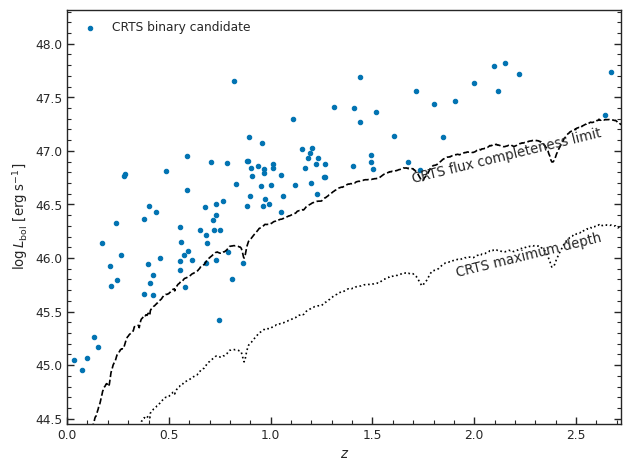

In [36]:
z_l = np.minimum(0, crts_candidates['z'].min())
z_u = np.maximum(1.5, crts_candidates['z'].max() + .05)
log_l_bol_l = crts_candidates['log_l_bol'].min() - .5
log_l_bol_u = crts_candidates['log_l_bol'].max() + .5

z_plot = np.linspace(z_l, z_u, num=1000)

V_APP_COMPLETE_CRTS = 19  # CRTS completeness limit
V_APP_MAX_CRTS = 21.5  # CRTS maximum depth (incomplete)
# V_LSST = 25  # 27.9 after 10 year

plt.figure()

plt.scatter(crts_candidates['z'], crts_candidates['log_l_bol'], color=cs[0], label='CRTS binary candidate')
# plt.plot(z_plot, log_l_bol_complete_crts_fn(z_plot), color='k', linestyle='--', label='CRTS flux completeness limit')
# plt.plot(z_plot, log_l_bol_max_crts_fn(z_plot), color='k', linestyle=':', label='CRTS maximum depth')
plt.plot(
    z_plot, 
    log_l_bol_complete_crts_fn(z_plot), 
    color='k', 
    linestyle='--', 
    # label='CRTS flux completeness limit'
)
plt.text(
    z_plot[-40],
    log_l_bol_complete_crts_fn(z_plot[-40])-.05,
    'CRTS flux completeness limit',
    # textcoords='offset pixels',
    # xytext=(0, -10),
    ha='right',
    va='top',
    transform_rotates_text=True, 
    rotation=25,
    rotation_mode='anchor',
)
plt.plot(
    z_plot,
    log_l_bol_max_crts_fn(z_plot), 
    color='k', 
    linestyle=':', 
    # label='CRTS maximum depth'
)
plt.text(
    z_plot[-40],
    log_l_bol_max_crts_fn(z_plot[-40])-.05,
    'CRTS maximum depth',
    # textcoords='offset pixels',
    # xytext=(0, -10),
    ha='right',
    va='top',
    transform_rotates_text=True, 
    rotation=25,
    rotation_mode='anchor',
)
# plt.plot(z_plot, completeness_limit_crts(z_plot), color='k', linestyle='--', label=r'CRTS Flux Complete, $V = 19$')
# plt.plot(z_plot, incomplete_flux_limit_crts(z_plot), color='k', linestyle='-.', label=r'CRTS Flux Limit, $V = 21.5$')
# plt.plot(z_plot, completeness_limit_lsst(z_plot), color='k', linestyle=':', label=r'LSST Flux Limit, $V = 27.9$')

plt.xlabel(r'$z$')
plt.ylabel(r'$\log L_{\rm bol} \ [\rm{erg} \; \rm{s}^{-1}]$')

plt.xlim(z_l, z_u)
plt.ylim(log_l_bol_l, log_l_bol_u)

plt.legend(loc='upper left', frameon=False)

plt.tight_layout()
plt.savefig('../reports/figures/crts_binary_candidates_log_l_bol.pdf')
plt.show()

In [37]:
crts_candidates[['Name', 'z', 'v_app', 'V_abs', 'A_ext', 'log_l_opt', 'log_l_bol']]

,Name,z,v_app,V_abs,A_ext,log_l_opt,log_l_bol
0,UM 211,1.998,17.38,-28.719151,0.098225,46.660592,47.633659
1,UM 234,0.729,17.82,-25.539248,0.069398,45.514686,46.503861
2,SDSS J014350.13+141453.0,1.438,17.68,-27.597778,0.159082,46.291779,47.269214
3,PKS 0157+011,1.170,18.04,-26.595031,0.072601,45.860376,46.843814
4,RX J024252.3-232633,0.680,19.01,-24.166848,0.072601,44.949754,45.950763
...,...,...,...,...,...,...,...
106,BZQJ2156-2012,1.309,17.01,-27.938618,0.083278,46.430956,47.406671
107,SDSS J221016.97+122213.9,0.717,18.32,-25.152935,0.227413,45.358890,46.350987
108,6QZ J221925.1-305408,0.579,19.15,-23.562048,0.034165,44.725196,45.732012
109,HS 2219+1944,0.211,16.33,-23.921984,0.139864,44.922754,45.924424


In [38]:
# save everything we've done so far
crts_candidates.to_csv('../data/processed/crts_candidates.csv', index=False)

with open(r"../models/log_l_bol_complete_crts_fn.pkl", "wb") as f:
    pickle.dump(log_l_bol_complete_crts_fn, f)
    
with open(r"../models/log_l_bol_max_crts_fn.pkl", "wb") as f:
    pickle.dump(log_l_bol_max_crts_fn, f)

In [39]:
# we will also save the inverse of the completeness function
# we need this later for calculating the 1 / V_max mass function
z_complete_crts_fn = interp1d(log_l_bol_complete_crts, z_interp,
                              fill_value='extrapolate', bounds_error=False)

with open(r"../models/z_complete_crts_fn.pkl", "wb") as f:
    pickle.dump(z_complete_crts_fn, f)

In [40]:
from scipy.special import erf

In [41]:
def bolometric_unc(log_lbol, log_l0=42.39, sig1=-.383, sig2=.405, sig3=2.378):
    res = log_lbol - log_l0
    res = res / (np.sqrt(2) * sig3)
    res = erf(res)
    res = .5 * res
    res = res + .5
    res = sig1 * res
    res = res + sig2
    return res

In [42]:
bolometric_unc(crts_candidates['log_l_bol']).mean()

0.038943436097098015

In [43]:
bolometric_unc(crts_candidates['log_l_bol']).median()

0.035601907884133144

In [44]:
bolometric_unc(crts_candidates['log_l_bol']).max()

0.07578038189096797

## Complete sample

Next let's check which samples are from the complete region of the CRTS survey. This was we can be sure that the samples we use for science are not from outside the formally complete region.

In [45]:
from src.models.quasar_generator import lognorm_q_dist
from src.models.llr import LogLbolLogEddRelation

In [46]:
GEO_MSUN = (u.Msun * (const.G / const.c ** 3)).to(u.s)
GEO_MPC = (u.Mpc / const.c).to(u.s)

def log_chirp_mass(log_total_mass, q=1):
    log_chirp_mass = log_total_mass
    log_chirp_mass += .6 * (np.log10(q) - 2 * np.log10(1 + q))
    return log_chirp_mass
    
    
def strain(log_mass, frequency, z, q=1, cosmo=cosmo):
    """
    Strain calculated in natural units.
    
    """
    # first convert everything to numpy arrays
    log_mass = np.array(log_mass)
    frequency = np.array(frequency)
    z = np.array(z)
    
    # calculate the chirp mass
    log_mass = log_mass + np.log10(GEO_MSUN.value)  # convert to geometric units
    log_m_chirp = log_chirp_mass(log_mass, q=q)
    
    # next calculate the luminosity distance
    # we need this in the denominator of the strain equation
    lum_dist = cosmo.luminosity_distance(z).to(u.Mpc).value
    log_lum_dist = np.log10(lum_dist) + np.log10(GEO_MPC.value)  # convert to geometric units

    f_r = frequency * (1 + z)  # rest frame frequency
    log_f_r = np.log10(f_r)  # already geometric
    
    return 10 ** log_strain(log_m_chirp, log_f_r, log_lum_dist)
    

def log_strain(log_chirp_mass, log_frequency, log_luminosity_distance):
    res = .5 * np.log10(32 / 5) 
    res = res + (5 / 3) * log_chirp_mass 
    res = res + (2 / 3) * (np.log10(np.pi) + log_frequency) 
    res = res - log_luminosity_distance
    return res

In [47]:
# constants relevant to the CRTS sample
CRTS_BASELINE = (9 * u.yr).to(u.s).value
CRTS_MIN_CYCLES = 1.5
CRTS_MIN_LC_PER = CRTS_BASELINE / CRTS_MIN_CYCLES

CRTS_MIN_ORB_PER = CRTS_MIN_LC_PER  # if unequal mass
# CRTS_MIN_ORB_PER = CRTS_MIN_LC_PER / 5  # if relatively equal mass

LOG_F_MIN_CRTS = np.log10(2 / (CRTS_MIN_ORB_PER))  # q < 1
# LOG_F_MIN_CRTS = np.log10(10 / (CRTS_MIN_ORB_PER))  # q = 1
LOG_F_MAX_CRTS = -7  # assume CRTS is sensitive to the high frequency end of the PTA band

N_CRTS = len(crts_candidates)  # total number of CRTS objects

In [48]:
STD_LOG_Q = .5
MODE_LOG_Q = 0
MEDIAN_LOG_Q = MODE_LOG_Q + (STD_LOG_Q ** 2)

# a, b = (np.log(.25) - MEDIAN_LOG_Q) / STD_LOG_Q, (np.log(1) - MEDIAN_LOG_Q) / STD_LOG_Q

q_dist = lognorm_q_dist(loc=MEDIAN_LOG_Q, scale=STD_LOG_Q, a=.25, b=1)

In [49]:
with h5py.File('../data/processed/nobuta_ler_refit_samples.h5', 'r') as hf:
    log_norm_ler = np.array(hf['log_norm'])
    slope_ler = np.array(hf['slope'])
    scatter_ler = np.array(hf['scatter'])

In [50]:
ler = LogLbolLogEddRelation(log_norm_ler, slope_ler, scatter_ler)

In [51]:
crts_candidates = crts_candidates[['Name', 'z', 'log_l_bol', 'f_gw', 'log_f_gw']]  # reduce to the columns we care about
crts_candidates

,Name,z,log_l_bol,f_gw,log_f_gw
0,UM 211,1.998,47.633659,1.227367e-08,-7.911025
1,UM 234,0.729,46.503861,1.273275e-08,-7.895078
2,SDSS J014350.13+141453.0,1.438,47.269214,1.505081e-08,-7.822440
3,PKS 0157+011,1.170,46.843814,2.200394e-08,-7.657499
4,RX J024252.3-232633,0.680,45.950763,1.273275e-08,-7.895078
...,...,...,...,...,...
106,BZQJ2156-2012,1.309,47.406671,1.736545e-08,-7.760314
107,SDSS J221016.97+122213.9,0.717,46.350987,1.736545e-08,-7.760314
108,6QZ J221925.1-305408,0.579,45.732012,1.644045e-08,-7.784086
109,HS 2219+1944,0.211,45.924424,1.342700e-08,-7.872021


In [52]:
# let's calculate strains and assign masses to the CRTS sample
# we will use Nobuta+ 2020 to assign masses, and we can assume
# a log-normal distribution of mass ratios
idxs = np.random.randint(1000, size=N_CRTS)
crts_candidates['log_mbh'] = np.diag(ler.log_lbol_to_log_mbh(crts_candidates['log_l_bol'].values)[idxs])
crts_candidates['q'] = q_dist.rvs(size=N_CRTS)
crts_candidates['strain'] = strain(crts_candidates['log_mbh'], 
                                   crts_candidates['f_gw'], 
                                   crts_candidates['z'],
                                   q=crts_candidates['q'],
                                   cosmo=cosmo)

/var/folders/1z/bwsppzbn3zd4q4lgr56l76tm0000gn/T/ipykernel_60994/2006561438.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crts_candidates['log_mbh'] = np.diag(ler.log_lbol_to_log_mbh(crts_candidates['log_l_bol'].values)[idxs])
/var/folders/1z/bwsppzbn3zd4q4lgr56l76tm0000gn/T/ipykernel_60994/2006561438.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crts_candidates['q'] = q_dist.rvs(size=N_CRTS)
/var/folders/1z/bwsppzbn3zd4q4lgr56l76tm0000gn/T/ipykernel_60994/2006561438.py:7: SettingWithCopyWarning

In [53]:
f_complete = crts_candidates['log_f_gw'] >= LOG_F_MIN_CRTS

crts_f_incomplete = crts_candidates[~f_complete]
N_INCOMPLETE_F = len(crts_f_incomplete)

display(crts_f_incomplete)

,Name,z,log_l_bol,f_gw,log_f_gw,log_mbh,q,strain
44,SDSS J113916.47+254412.6,1.012,46.876527,9.490836e-09,-8.022696,9.046741,0.945791,2.351458e-17


In [54]:
spec_complete = crts_candidates['log_l_bol'] >= log_l_bol_complete_crts_fn(crts_candidates['z'])

crts_spec_incomplete = crts_candidates[~spec_complete]
N_INCOMPLETE_SPEC = len(crts_spec_incomplete)

display(crts_spec_incomplete)

,Name,z,log_l_bol,f_gw,log_f_gw,log_mbh,q,strain
4,RX J024252.3-232633,0.680,45.950763,1.273275e-08,-7.895078,9.222177,0.911118,8.115994e-17
12,SDSS J080648.65+184037.0,0.745,45.422152,2.595084e-08,-7.585849,8.569246,0.742214,9.569025e-18
20,SDSS J082926.01+180020.7,0.810,45.804638,1.597526e-08,-7.796552,9.158084,0.437446,5.308702e-17
38,SDSS J104758.34+284555.8,0.792,46.056320,1.250575e-08,-7.902890,8.742842,0.899302,1.101948e-17
61,SDSS J130040.62+172758.4,0.863,45.951734,1.273275e-08,-7.895078,8.360254,0.788508,2.344164e-18
96,163107.34+560905.3,0.731,45.977633,1.342700e-08,-7.872021,8.640767,0.513873,7.576137e-18
108,6QZ J221925.1-305408,0.579,45.732012,1.644045e-08,-7.784086,8.450503,0.635327,5.537626e-18


In [55]:
crts_complete = crts_candidates[spec_complete & f_complete]
N_CRTS_COMPLETE = len(crts_complete)

display(crts_complete)

,Name,z,log_l_bol,f_gw,log_f_gw,log_mbh,q,strain
0,UM 211,1.998,47.633659,1.227367e-08,-7.911025,9.920839,0.708997,4.361689e-16
1,UM 234,0.729,46.503861,1.273275e-08,-7.895078,9.030709,0.786234,3.598383e-17
2,SDSS J014350.13+141453.0,1.438,47.269214,1.505081e-08,-7.822440,9.527031,0.770163,1.459957e-16
3,PKS 0157+011,1.170,46.843814,2.200394e-08,-7.657499,9.255341,0.826937,7.988955e-17
5,US 3204,0.954,46.671238,1.389445e-08,-7.857159,9.452483,0.870083,1.511869e-16
...,...,...,...,...,...,...,...,...
105,4C 50.43,1.111,47.300553,2.153316e-08,-7.666892,9.621955,0.793015,3.351880e-16
106,BZQJ2156-2012,1.309,47.406671,1.736545e-08,-7.760314,10.071398,0.969073,1.429698e-15
107,SDSS J221016.97+122213.9,0.717,46.350987,1.736545e-08,-7.760314,8.146641,0.574003,1.420954e-18
109,HS 2219+1944,0.211,45.924424,1.342700e-08,-7.872021,9.019766,0.586010,1.151604e-16


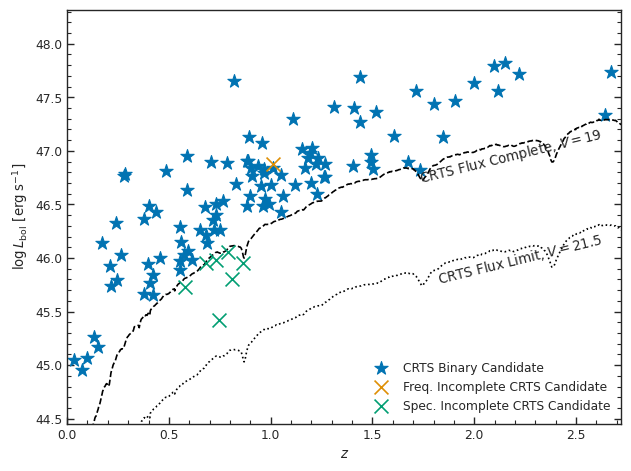

In [56]:
z_l = np.minimum(0, crts_candidates['z'].min())
z_u = np.maximum(1.5, crts_candidates['z'].max() + .05)
log_l_bol_l = crts_candidates['log_l_bol'].min() - .5
log_l_bol_u = crts_candidates['log_l_bol'].max() + .5

plt.figure()

plt.scatter(crts_complete['z'], crts_complete['log_l_bol'], color=cs[0],
            label='CRTS Binary Candidate', marker='*', s=100, rasterized=True)
plt.scatter(crts_f_incomplete['z'], crts_f_incomplete['log_l_bol'],
            color=cs[1], label='Freq. Incomplete CRTS Candidate', marker='x',
            s=100, zorder=10, rasterized=True)
plt.scatter(crts_spec_incomplete['z'], crts_spec_incomplete['log_l_bol'],
            color=cs[2], label='Spec. Incomplete CRTS Candidate', marker='x',
            s=100, zorder=10, rasterized=True)


# plt.plot(z_plot, completeness_limit_lsst(z_plot), color='k', linestyle=':', label=r'LSST Flux Limit, $V = 25$')
plt.plot(
    z_plot, 
    log_l_bol_complete_crts_fn(z_plot), 
    color='k', 
    linestyle='--', 
    # label='CRTS flux completeness limit'
)
plt.text(
    z_plot[-40],
    log_l_bol_complete_crts_fn(z_plot[-40])-.05,
    r'CRTS Flux Complete, $V = 19$',
    # textcoords='offset pixels',
    # xytext=(0, -10),
    ha='right',
    va='top',
    transform_rotates_text=True, 
    rotation=25,
    rotation_mode='anchor',
)
plt.plot(
    z_plot,
    log_l_bol_max_crts_fn(z_plot), 
    color='k', 
    linestyle=':', 
    # label='CRTS maximum depth'
)
plt.text(
    z_plot[-40],
    log_l_bol_max_crts_fn(z_plot[-40])-.05,
    r'CRTS Flux Limit, $V = 21.5$',
    # textcoords='offset pixels',
    # xytext=(0, -10),
    ha='right',
    va='top',
    transform_rotates_text=True, 
    rotation=25,
    rotation_mode='anchor',
)

plt.xlabel(r'$z$')
plt.ylabel(r'$\log L_{\rm bol} \ [\rm{erg} \; \rm{s}^{-1}]$')

plt.xlim(z_l, z_u)
plt.ylim(log_l_bol_l, log_l_bol_u)

plt.legend(
    loc='lower right', 
    frameon=False)

plt.tight_layout()
plt.savefig('../reports/figures/crts_complete.pdf')
plt.show()

## Reduced Sample

Finally, we will make a few simple cuts along luminosity and redshift to reduce the sample further, since we really only care about sources within $z \leq 1.5$.

In [57]:
LOG_LBOL_MIN = crts_candidates['log_l_bol'].min()  # We can fit to slightly below log_lbol = 45
LOG_LBOL_MAX = 48
Z_MIN = crts_candidates['z'].min()
# Z_MIN = 0
Z_MAX = 1.5

In [58]:
reduced_crts_complete = crts_complete[(crts_complete['log_l_bol'] >= LOG_LBOL_MIN)
                                      & (crts_complete['z'] <= Z_MAX)]

N_CRTS_COMPLETE_REDUCED = len(reduced_crts_complete)

reduced_crts_complete

,Name,z,log_l_bol,f_gw,log_f_gw,log_mbh,q,strain
1,UM 234,0.729,46.503861,1.273275e-08,-7.895078,9.030709,0.786234,3.598383e-17
2,SDSS J014350.13+141453.0,1.438,47.269214,1.505081e-08,-7.822440,9.527031,0.770163,1.459957e-16
3,PKS 0157+011,1.170,46.843814,2.200394e-08,-7.657499,9.255341,0.826937,7.988955e-17
5,US 3204,0.954,46.671238,1.389445e-08,-7.857159,9.452483,0.870083,1.511869e-16
6,CT 638,0.265,46.026309,1.527931e-08,-7.815896,9.092142,0.655995,1.352891e-16
...,...,...,...,...,...,...,...,...
105,4C 50.43,1.111,47.300553,2.153316e-08,-7.666892,9.621955,0.793015,3.351880e-16
106,BZQJ2156-2012,1.309,47.406671,1.736545e-08,-7.760314,10.071398,0.969073,1.429698e-15
107,SDSS J221016.97+122213.9,0.717,46.350987,1.736545e-08,-7.760314,8.146641,0.574003,1.420954e-18
109,HS 2219+1944,0.211,45.924424,1.342700e-08,-7.872021,9.019766,0.586010,1.151604e-16


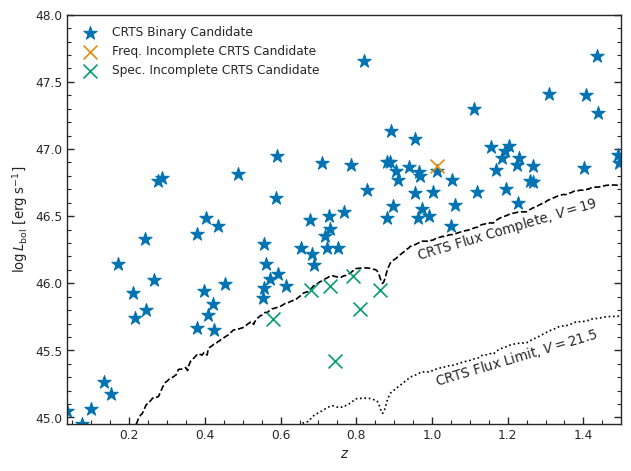

In [59]:
plt.figure()

plt.scatter(reduced_crts_complete['z'], reduced_crts_complete['log_l_bol'], color=cs[0],
            label='CRTS Binary Candidate', marker='*', s=100, rasterized=True)
plt.scatter(crts_f_incomplete['z'], crts_f_incomplete['log_l_bol'],
            color=cs[1], label='Freq. Incomplete CRTS Candidate', marker='x',
            s=100, zorder=10, rasterized=True)
plt.scatter(crts_spec_incomplete['z'], crts_spec_incomplete['log_l_bol'],
            color=cs[2], label='Spec. Incomplete CRTS Candidate', marker='x',
            s=100, zorder=10, rasterized=True)


# plt.plot(z_plot, log_l_bol_complete_crts_fn(z_plot), color='k', linestyle='--', label=r'CRTS Flux Complete, $V = 19$', rasterized=True)
# plt.plot(z_plot, log_l_bol_max_crts_fn(z_plot), color='k', linestyle='-.', label=r'CRTS Flux Limit, $V = 21.5$', rasterized=True)
# plt.plot(z_plot, completeness_limit_lsst(z_plot), color='k', linestyle=':', label=r'LSST Flux Limit, $V = 25$')

plt.plot(
    z_plot, 
    log_l_bol_complete_crts_fn(z_plot), 
    color='k', 
    linestyle='--', 
    # label='CRTS flux completeness limit'
)
plt.text(
    z_plot[-475],
    log_l_bol_complete_crts_fn(z_plot[-475])-.05,
    r'CRTS Flux Complete, $V = 19$',
    # textcoords='offset pixels',
    # xytext=(0, -10),
    ha='right',
    va='top',
    transform_rotates_text=True, 
    rotation=40,
    rotation_mode='anchor',
)
plt.plot(
    z_plot,
    log_l_bol_max_crts_fn(z_plot), 
    color='k', 
    linestyle=':', 
    # label='CRTS maximum depth'
)
plt.text(
    z_plot[-475],
    log_l_bol_max_crts_fn(z_plot[-475])-.05,
    r'CRTS Flux Limit, $V = 21.5$',
    # textcoords='offset pixels',
    # xytext=(0, -10),
    ha='right',
    va='top',
    transform_rotates_text=True, 
    rotation=40,
    rotation_mode='anchor',
)

plt.xlabel(r'$z$')
plt.ylabel(r'$\log L_{\rm bol} \ [\rm{erg} \; \rm{s}^{-1}]$')

plt.xlim(Z_MIN, Z_MAX)
plt.ylim(LOG_LBOL_MIN, LOG_LBOL_MAX)

plt.legend(frameon=False)

plt.tight_layout()
plt.savefig('../reports/figures/reduced_crts_complete.pdf')
plt.show()

In [60]:
# save everything we've done so far
crts_f_incomplete.to_csv('../data/processed/crts_f_incomplete.csv', index=False)
crts_spec_incomplete.to_csv('../data/processed/crts_spec_incomplete.csv', index=False)
crts_complete.to_csv('../data/processed/crts_complete.csv', index=False)
reduced_crts_complete.to_csv('../data/processed/reduced_crts_complete.csv', index=False)

## Sample Completeness
To determine the number of quasars to choose in each bin, we will calculate the completeness of the CRTS sample as a function of luminosity, redshift, and frequency. The number of luminosity limited samples observed by CRTS in each bin to the size of the bin up to some minimum luminosity, $L_{\min}$, is

$$
N_{\rm BQ, i} = \frac{\int_{z_{\min, i}}^{z_{\max, i}} \int_{L_{\min}}^{L_{\max}} \int_{f_{\min}}^{f_{\max}}  \phi_{\rm BQ}(L, z, f) df dL dz}{\int_{z_{\min, i}}^{z_{\max, i}} \int_{L_{\min}(z)}^{L_{\max}} \int_{f_{\min, {\rm CRTS}}}^{f_{\max}} \phi_{\rm BQ}(L, z, f) df dL dz} N_{\rm CRTS, i},
$$

where $\log f_{\rm GW, min} = -9$ and $\log f_{\rm GW, min, CRTS} \approx -8$.

We assume that the frequency distribution is independent of $L$ and $z$, such that
$$
\phi_{\rm BQ}(L, z, f) = \phi_{\rm BQ}(L, z) p(f),
$$
where
$$
\begin{align*}
    p(f) &= \frac{\frac{dN}{df}}{\int_{f_{\min}}^{f_{\max}} \frac{dN}{df} df} = \frac{\dot{N} \frac{dt}{df}}{\int_{f_{\min}}^{f_{\max}} \dot{N} \frac{dt}{df} df} \\
    &= \frac{\frac{5}{96} \pi^{-8 / 3} \mathcal{M}_{c}^{-5 / 3} f^{-11 / 3}}{\int_{f_{\min}}^{f_{\max}} \frac{5}{96} \pi^{-8 / 3} \mathcal{M}_{c}^{-5 / 3} f^{-11 / 3} df} = \frac{f^{-11 / 3}}{\int_{f_{\min}}^{f_{\max}} f^{-11 / 3} df} \\
    &= \frac{8}{3} \frac{f^{-11 / 3}}{f_{\min}^{-8 / 3} - f_{\max}^{-8 / 3}}.
\end{align*}
$$
We also assume that in each redshift interval, $\delta z$, the CRTS binary candidate and quasar distributions are proportional, so that
$$
\phi_{{\rm BQ}}(L, z) \propto \phi_{{\rm QSO}}(L, z)
$$.

Simplifying the above, $N_{\rm BQ, i}$ is thus
$$
\begin{align*}
N_{\rm BQ, i} &\approx \frac{\int_{z_{\min, i}}^{z_{\max, i}} \int_{L_{\min}}^{L_{\max}} \phi_{\rm BQ}(L, z) dL dz}{\int_{z_{\min, i}}^{z_{\max, i}} \int_{L_{\min}(z)}^{L_{\max}} \phi_{\rm BQ}(L, z) dL dz} \frac{\int_{f_{\min}}^{f_{\max}} p(f) df}{\int_{f_{\min, {\rm CRTS}}}^{f_{\max}} p(f) df} N_{\rm CRTS, i} \\
&\approx \frac{\int_{z_{\min, i}}^{z_{\max, i}} \int_{L_{\min}}^{L_{\max}} \phi_{\rm BQ}(L, z) dL dz}{\int_{z_{\min, i}}^{z_{\max, i}} \int_{L_{\min}(z)}^{L_{\max}} \phi_{\rm BQ}(L, z) dL dz} \frac{f_{\min}^{-8 / 3} - f_{\max}^{-8 / 3}}{f_{\min, {\rm CRTS}}^{-8 / 3} - f_{\max}^{-8 / 3}} N_{\rm CRTS, i}.
\end{align*}
$$
We simplify this as
$$
N_{\rm BQ, i} \approx \frac{\int_{z_{\min, i}}^{z_{\max, i}} \int_{L_{\min}}^{L_{\max}} \phi_{\rm BQ}(L, z) dL dz}{\int_{z_{\min, i}}^{z_{\max, i}} \int_{L_{\min}(z)}^{L_{\max}} \phi_{\rm BQ}(L, z) dL dz} \frac{f_{\min}^{-8 / 3} - f_{\max}^{-8 / 3}}{f_{\min, {\rm CRTS}}^{-8 / 3} - f_{\max}^{-8 / 3}} N_{\rm CRTS, i}
$$

### Sky Coverage

Sky coverage calculations based on Sesana+ 18. Note that these calculations are based on the full, 111 object catalog.

In [61]:
FULL_SKY = 4 * np.pi * u.sr
CRTS_SKY = 33000 * u.deg ** 2

#### CRTS survey area

We calculate the CRTS survey coverage, which we expect is $\sim 80 \%$.

In [62]:
# to correct for the CRTS completeness we just need to look at the survey area coverage
crts_cov = (CRTS_SKY / FULL_SKY).to('')
display(Math(r'f_{{\Omega_{{\rm CRTS}}}} = {0:.2f}'.format(crts_cov)))

<IPython.core.display.Math object>

#### SDSS survey area

Next we account for the fact that 78 of the 111 original quasars in the CRTS sample were confirmed spectroscopically by SDSS (via BOSS/eBOSS?), which only has a sky coverage of $\sim 25 \%$. S18 use this to estimate $78 \times 4 = 312$ expected objects in the whole sky, assuming a complete identificartion in the SDSS field of view. They then use this to argue that CRTS is $111 / 312 \approx 35.5 \%$ complete (before other corrections from rejected samples). The CRTS survey coverage is not used.

In [63]:
78 / 111

0.7027027027027027

We apply a similar argument below.

In [64]:
N_SDSS = 78  # total number of SDSS confirmed objects in CRTS

In [65]:
# then we calculate the SDSS sky coverage
SDSS_AREA = 9376 * u.deg ** 2
sdss_cov = (SDSS_AREA / FULL_SKY).to('')
# sdss_cov = .25  # uncomment to use S18's approx
display(Math(r'S_{{\Omega_{{\rm SDSS}}}} = \frac{{\Omega_{{\rm SDSS}}}}{{\Omega_{{\rm full sky}}}} = {0:.3f}'.format(sdss_cov)))

<IPython.core.display.Math object>

In [66]:
# divide the number of SDSS-CRTS objects by the full sky coverage to
# get the expected number of periodic quasars that can be reliably detected by CRTS in the full sky.
n_full_crts_reliable = N_SDSS / sdss_cov
display(Math(r'N_{{\rm full sky, CRTS, r}} = \frac{{N_{{\rm SDSS}}}}{{S_{{\Omega_{{\rm SDSS}}}}}} = {0:.0f}'.format(n_full_crts_reliable)))

<IPython.core.display.Math object>

Assuming that all of the $111 - 78 = 33$ quasars in the CRTS sample which have not been confirmed by SDSS are outside its field, we calculate the completeness of the CRTS sample, as limited by SDSS sky coverage.

In [67]:
# the implied full sample sky coverage completeness
S_sky = N_CRTS / n_full_crts_reliable
display(Math(r'S_{{\Omega}} = \frac{{N_{{\rm CRTS}}}}{{N_{{\rm full sky}}}} = {0:.3f}'.format(S_sky)))

<IPython.core.display.Math object>

### Sparsity Rejected Samples

$\sim 25 \%$ (83k/334k) of the original CRTS quasar sample was rejected for sparse sampling (S13; Graham et al. 2015, G15 hereafter). S18 argues this implies $312 / .75 = 416$ quasars in the full sky, reducing completeness to $111 / 416 \approx 26.7 \%$.

In [68]:
N_TOTAL_CRTS = 334446
N_REJECTED_CRTS = 83782

In [69]:
# calculate completeness based on data quality
S_qual = 1 - (N_REJECTED_CRTS / N_TOTAL_CRTS)
display(Math(r'S_{{\rm qual}} = {0:.3f}'.format(S_qual)))

<IPython.core.display.Math object>

In [70]:
# Total number of 
n_full_crts_plausible = n_full_crts_reliable / S_qual
display(Math(r'N_{{\rm full, CRTS, p}} = {0:.0f}'.format(n_full_crts_plausible)))

<IPython.core.display.Math object>

In [71]:
S_qual * S_sky

<Quantity 0.2424135>

### Frequency completeness

First we'll demo $p(f)$.

In [72]:
from src.models.quasar_generator import powerlaw_f_dist

In [73]:
LOG_F_MIN, LOG_F_MAX = -9, -7
F_MIN, F_MAX = np.power(10., [LOG_F_MIN, LOG_F_MAX])

In [74]:
f_dist = powerlaw_f_dist(exp=-11/3, a=F_MIN, b=F_MAX)

Next let's actually calculate $\frac{f_{\min}^{-8 / 3} - f_{\max}^{-8 / 3}}{f_{\min, {\rm CRTS}}^{-8 / 3} - f_{\max}^{-8 / 3}}$, since this won't change with $z$ anyways. Note that this is essentially $\frac{1}{1 - \rm{CDF}(f_{\min, {\rm CRTS}})}$.

In [75]:
S_f = 1 - f_dist.cdf(10 ** LOG_F_MIN_CRTS)
display(Math(r'S_{{f}} = {0:.6f}'.format(S_f)))

<IPython.core.display.Math object>

Next let's compare this distribution to the CRTS sample

In [76]:
def upper_poisson_errors(n, S=1):
    """Upper poisson errors, valid for small number statistics.
    
    """
    n = np.array(n).astype(float)
    return np.squeeze(np.array(S * np.sqrt(n + .75) + (((S ** 2) + 3) / 4)))


def lower_poisson_errors(n, S=1):
    """Lower poisson errors, valid for small number statistics.
    
    """
    n = np.array(n).astype(float)
    res = np.zeros_like(n)
    m = n != 0
    res[m] = S * np.sqrt(n[m] - .25) - (((S ** 2) - 1) / 4)
    
    return np.squeeze(res)

def upper_poisson_limit(n, S=1):
    """Upper poisson limit, valid for small number statistics.
    
    """
    n = np.array(n).astype(float)
    return np.squeeze(n + upper_poisson_errors(n, S=S))


def lower_poisson_limit(n, S=1):
    """Lower poisson limit, valid for small number statistics.
    
    """
    n = np.array(n).astype(float)
    return np.squeeze(n - lower_poisson_errors(n, S=S))

In [77]:
# log_f_min_crts = np.minimum(LOG_F_MIN_CRTS, reduced_crts_candidates['log_f_gw'].min())
crts_f_complete = crts_candidates[f_complete]
N_F_COMPLETE = len(crts_f_complete)

crts_f_complete

,Name,z,log_l_bol,f_gw,log_f_gw,log_mbh,q,strain
0,UM 211,1.998,47.633659,1.227367e-08,-7.911025,9.920839,0.708997,4.361689e-16
1,UM 234,0.729,46.503861,1.273275e-08,-7.895078,9.030709,0.786234,3.598383e-17
2,SDSS J014350.13+141453.0,1.438,47.269214,1.505081e-08,-7.822440,9.527031,0.770163,1.459957e-16
3,PKS 0157+011,1.170,46.843814,2.200394e-08,-7.657499,9.255341,0.826937,7.988955e-17
4,RX J024252.3-232633,0.680,45.950763,1.273275e-08,-7.895078,9.222177,0.911118,8.115994e-17
...,...,...,...,...,...,...,...,...
106,BZQJ2156-2012,1.309,47.406671,1.736545e-08,-7.760314,10.071398,0.969073,1.429698e-15
107,SDSS J221016.97+122213.9,0.717,46.350987,1.736545e-08,-7.760314,8.146641,0.574003,1.420954e-18
108,6QZ J221925.1-305408,0.579,45.732012,1.644045e-08,-7.784086,8.450503,0.635327,5.537626e-18
109,HS 2219+1944,0.211,45.924424,1.342700e-08,-7.872021,9.019766,0.586010,1.151604e-16


In [78]:
log_f_gw_counts, log_f_gw_bins = np.histogram(crts_f_complete['log_f_gw'], bins='auto', range=(LOG_F_MIN_CRTS, LOG_F_MAX_CRTS))
log_f_gw_bin_midpts = (log_f_gw_bins[1:] + log_f_gw_bins[:-1]) / 2

log_f_gw_count_err_u = upper_poisson_errors(log_f_gw_counts)
log_f_gw_count_err_l = lower_poisson_errors(log_f_gw_counts)

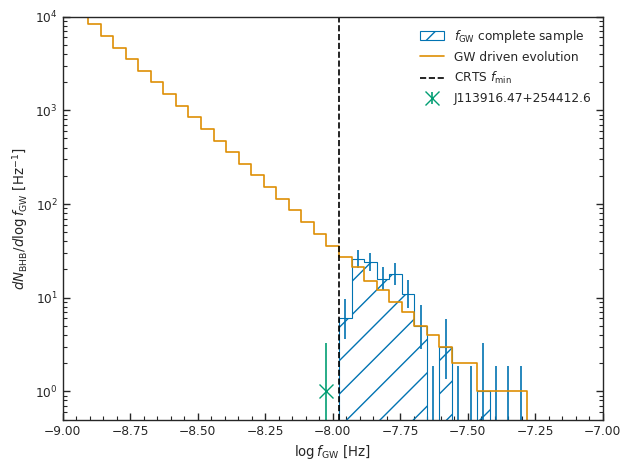

In [79]:
# calculate the theoretical counts in each bin
log_f_bw = np.diff(log_f_gw_bins)[0]
log_f_range =  np.sort(-np.arange(-LOG_F_MAX, -LOG_F_MIN, log_f_bw))  # hack to get the bins the same
log_f_centers = (log_f_range[1:] + log_f_range[:-1]) / 2
n_theory = N_F_COMPLETE / S_f * (f_dist.cdf(10 ** log_f_range[1:]) - f_dist.cdf(10 ** log_f_range[:-1]))
n_theory = np.round(n_theory)

# adjust some values for plotting
log_f_gw_counts_plot = np.where(log_f_gw_counts > 0, log_f_gw_counts, 0.00001)
log_f_gw_count_err_l_plot = np.where(log_f_gw_count_err_l > 0, log_f_gw_count_err_l, 0.00001)
nonzero_mask = (n_theory >= 1)[log_f_centers > LOG_F_MIN_CRTS]
# nonzero_mask = np.nonzero(log_f_gw_counts)[0]


plt.figure()

# plot the CRTS sample counts with errors
plt.hist(crts_f_complete['log_f_gw'], bins=log_f_gw_bins, histtype='step', color=cs[0],
         hatch='/', label=r'$f_{\rm GW}$ complete sample')
plt.errorbar(log_f_gw_bin_midpts[nonzero_mask], log_f_gw_counts_plot[nonzero_mask],
             yerr=(log_f_gw_count_err_l_plot[nonzero_mask], log_f_gw_count_err_u[nonzero_mask]),
             marker=None, linestyle='', markersize=10, color=cs[0])

# plot the theoretical counts
plt.plot(log_f_centers, n_theory, drawstyle='steps-mid', label='GW driven evolution', color=cs[1])

# add the frequency incomplete sample
plt.errorbar(crts_f_incomplete['log_f_gw'], [1],
             yerr=np.array([[lower_poisson_errors([1])], [upper_poisson_errors([1])]]),
             marker='x', linestyle='', markersize=10, label='J113916.47+254412.6', color=cs[2])

# add the oCRTS frequency cutoff
plt.axvline(LOG_F_MIN_CRTS, color='black', linestyle='--', label=r'CRTS $f_{\min}$')

plt.xlabel(r'$\log f_{\rm GW} \ [\rm{Hz}]$')
plt.ylabel(r'$dN_{\rm BHB} / d\log f_{\rm GW} \ [\rm{Hz}^{-1}]$')

plt.yscale('log')
plt.xlim(LOG_F_MIN, LOG_F_MAX)
plt.ylim(5e-1, 1e4)

plt.legend(frameon=False)

plt.tight_layout()
plt.savefig('../reports/figures/frequency_dist.pdf')
plt.show()

Let's also plot this for the sample that is also spectroscopically complete.

In [80]:
log_f_gw_counts, log_f_gw_bins = np.histogram(crts_complete['log_f_gw'], bins='auto', range=(LOG_F_MIN_CRTS, LOG_F_MAX_CRTS))
log_f_gw_bin_midpts = (log_f_gw_bins[1:] + log_f_gw_bins[:-1]) / 2

log_f_gw_count_err_u = upper_poisson_errors(log_f_gw_counts)
log_f_gw_count_err_l = lower_poisson_errors(log_f_gw_counts)

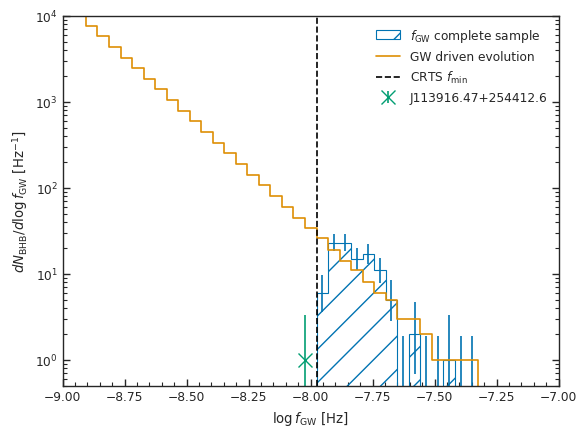

In [81]:
# calculate the theoretical counts in each bin
log_f_bw = np.diff(log_f_gw_bins)[0]
log_f_range =  np.sort(-np.arange(-LOG_F_MAX, -LOG_F_MIN, log_f_bw))  # hack to get the bins the same
log_f_centers = (log_f_range[1:] + log_f_range[:-1]) / 2
n_theory = N_CRTS_COMPLETE / S_f * (f_dist.cdf(10 ** log_f_range[1:]) - f_dist.cdf(10 ** log_f_range[:-1]))
n_theory = np.round(n_theory)

# adjust some values for plotting
log_f_gw_counts_plot = np.where(log_f_gw_counts > 0, log_f_gw_counts, 0.00001)
log_f_gw_count_err_l_plot = np.where(log_f_gw_count_err_l > 0, log_f_gw_count_err_l, 0.00001)
nonzero_mask = (n_theory >= 1)[log_f_centers > LOG_F_MIN_CRTS]
# nonzero_mask = np.nonzero(log_f_gw_counts)[0]


plt.figure()

# plot the CRTS sample counts with errors
plt.hist(crts_complete['log_f_gw'], bins=log_f_gw_bins, histtype='step', color=cs[0],
         hatch='/', label=r'$f_{\rm GW}$ complete sample')
plt.errorbar(log_f_gw_bin_midpts[nonzero_mask], log_f_gw_counts_plot[nonzero_mask],
             yerr=(log_f_gw_count_err_l_plot[nonzero_mask], log_f_gw_count_err_u[nonzero_mask]),
             marker=None, linestyle='', markersize=10, color=cs[0])

# plot the theoretical counts
plt.plot(log_f_centers, n_theory, drawstyle='steps-mid', label='GW driven evolution', color=cs[1])

# add the frequency incomplete sample
plt.errorbar(crts_f_incomplete['log_f_gw'], 1,
             yerr=np.array([[lower_poisson_errors(1)], [upper_poisson_errors(1)]]),
             marker='x', linestyle='', markersize=10, label='J113916.47+254412.6', color=cs[2])

# add the CRTS frequency cutoff
plt.axvline(LOG_F_MIN_CRTS, color='black', linestyle='--', label=r'CRTS $f_{\min}$')

plt.xlabel(r'$\log f_{\rm GW} \ [\rm{Hz}]$')
plt.ylabel(r'$dN_{\rm BHB} / d\log f_{\rm GW} \ [\rm{Hz}^{-1}]$')

plt.yscale('log')
plt.xlim(LOG_F_MIN, LOG_F_MAX)
plt.ylim(5e-1, 1e4)

plt.legend(frameon=False)

plt.savefig('../reports/figures/frequency_dist_spec_complete.pdf')
plt.show()

Finally, let's plot this for only the reduced sample, with $z \leq 1.5$.

In [82]:
log_f_gw_counts, log_f_gw_bins = np.histogram(reduced_crts_complete['log_f_gw'], bins='auto', range=(LOG_F_MIN_CRTS, LOG_F_MAX_CRTS))
log_f_gw_bin_midpts = (log_f_gw_bins[1:] + log_f_gw_bins[:-1]) / 2

log_f_gw_count_err_u = upper_poisson_errors(log_f_gw_counts)
log_f_gw_count_err_l = lower_poisson_errors(log_f_gw_counts)

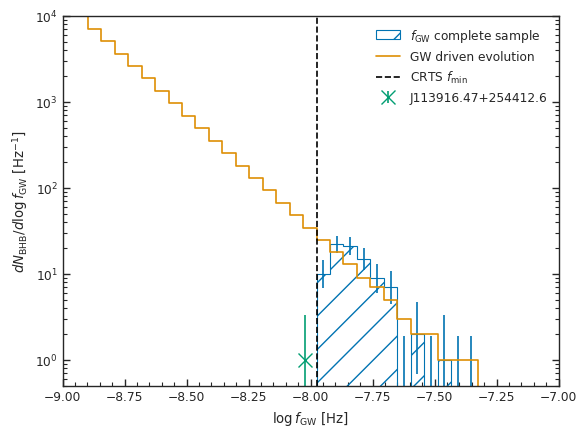

In [83]:
# calculate the theoretical counts in each bin
log_f_bw = np.diff(log_f_gw_bins)[0]
log_f_range =  np.sort(-np.arange(-LOG_F_MAX, -LOG_F_MIN, log_f_bw))  # hack to get the bins the same
log_f_centers = (log_f_range[1:] + log_f_range[:-1]) / 2
n_theory = N_CRTS_COMPLETE_REDUCED / S_f * (f_dist.cdf(10 ** log_f_range[1:]) - f_dist.cdf(10 ** log_f_range[:-1]))
n_theory = np.round(n_theory)

# adjust some values for plotting
log_f_gw_counts_plot = np.where(log_f_gw_counts > 0, log_f_gw_counts, 0.00001)
log_f_gw_count_err_l_plot = np.where(log_f_gw_count_err_l > 0, log_f_gw_count_err_l, 0.00001)
nonzero_mask = (n_theory >= 1)[log_f_centers > LOG_F_MIN_CRTS]
# nonzero_mask = np.nonzero(log_f_gw_counts)[0]


plt.figure()

# plot the CRTS sample counts with errors
plt.hist(reduced_crts_complete['log_f_gw'], bins=log_f_gw_bins, histtype='step', color=cs[0],
         hatch='/', label=r'$f_{\rm GW}$ complete sample')
plt.errorbar(log_f_gw_bin_midpts[nonzero_mask], log_f_gw_counts_plot[nonzero_mask],
             yerr=(log_f_gw_count_err_l_plot[nonzero_mask], log_f_gw_count_err_u[nonzero_mask]),
             marker=None, linestyle='', markersize=10, color=cs[0])

# plot the theoretical counts
plt.plot(log_f_centers, n_theory, drawstyle='steps-mid', label='GW driven evolution', color=cs[1])

# add the frequency incomplete sample
plt.errorbar(crts_f_incomplete['log_f_gw'], 1,
             yerr=np.array([[lower_poisson_errors(1)], [upper_poisson_errors(1)]]),
             marker='x', linestyle='', markersize=10, label='J113916.47+254412.6', color=cs[2])

# add the oCRTS frequency cutoff
plt.axvline(LOG_F_MIN_CRTS, color='black', linestyle='--', label=r'CRTS $f_{\min}$')

plt.xlabel(r'$\log f_{\rm GW} \ [\rm{Hz}]$')
plt.ylabel(r'$dN_{\rm BHB} / d\log f_{\rm GW} \ [\rm{Hz}^{-1}]$')

plt.yscale('log')
plt.xlim(LOG_F_MIN, LOG_F_MAX)
plt.ylim(5e-1, 1e4)

plt.legend(frameon=False)

plt.savefig('../reports/figures/frequency_dist_spec_complete_reduced.pdf')
plt.show()

### Luminosity and Redshift completeness

Let's estimate the overall flux limited completeness, $S_{\rm flux, CRTS}$ of the sample by assuming $S_{\rm flux, CRTS} = S_{\rm flux, QSO}$, where the quasar flux completeness is 
$$
S_{\rm flux, QSO} = \frac{\int_{z_{\min}}^{z_{\max}} \int_{L_{\min}(z)}^{L_{\max}} \phi_{\rm QSO}(L, z) dL dz}{\int_{z_{\min}}^{z_{\max}} \int_{L_{\min}}^{L_{\max}} \phi_{\rm QSO}(L, z) dL dz}
$$

In [84]:
Z_MAX_CRTS = crts_candidates['z'].max()

In [85]:
# log_f_min_crts = np.minimum(LOG_F_MIN_CRTS, reduced_crts_candidates['log_f_gw'].min())
crts_spec_complete = crts_candidates[spec_complete]
N_SPEC_COMPLETE = len(crts_spec_complete)

crts_spec_complete

,Name,z,log_l_bol,f_gw,log_f_gw,log_mbh,q,strain
0,UM 211,1.998,47.633659,1.227367e-08,-7.911025,9.920839,0.708997,4.361689e-16
1,UM 234,0.729,46.503861,1.273275e-08,-7.895078,9.030709,0.786234,3.598383e-17
2,SDSS J014350.13+141453.0,1.438,47.269214,1.505081e-08,-7.822440,9.527031,0.770163,1.459957e-16
3,PKS 0157+011,1.170,46.843814,2.200394e-08,-7.657499,9.255341,0.826937,7.988955e-17
5,US 3204,0.954,46.671238,1.389445e-08,-7.857159,9.452483,0.870083,1.511869e-16
...,...,...,...,...,...,...,...,...
105,4C 50.43,1.111,47.300553,2.153316e-08,-7.666892,9.621955,0.793015,3.351880e-16
106,BZQJ2156-2012,1.309,47.406671,1.736545e-08,-7.760314,10.071398,0.969073,1.429698e-15
107,SDSS J221016.97+122213.9,0.717,46.350987,1.736545e-08,-7.760314,8.146641,0.574003,1.420954e-18
109,HS 2219+1944,0.211,45.924424,1.342700e-08,-7.872021,9.019766,0.586010,1.151604e-16


In [86]:
def n_qso_integ(log_l, z):
    return 4 * np.pi * qlf(log_l, z) * cosmo.differential_comoving_volume(z).to(u.Mpc ** 3 / u.sr).value

In [87]:
# Let's start with an initial, overall estimate.
# This will give us a general sense of the completeness
# due to selection effects
def S(log_l, z, log_l_complete=log_l_bol_complete_crts_fn):
    log_l_min = np.maximum(LOG_LBOL_MIN, log_l_complete(z))
    res = np.where(log_l_min <= log_l, 1, 0)
    return res

def qlf_observed(log_l, z,
                 model=n_qso_integ,
                 log_l_complete=log_l_bol_complete_crts_fn):
    ll, zz = np.meshgrid(log_l, z, indexing='ij')
    return np.squeeze(S(ll, zz, log_l_complete)) * model(log_l, z)

In [88]:
bounds = [[LOG_LBOL_MIN, LOG_LBOL_MAX], [Z_MIN, Z_MAX_CRTS]]
ndens_tot = nquad_vec(n_qso_integ, bounds)
ndens_obs = nquad_vec(qlf_observed, bounds)

S_flux_qso = ndens_obs / ndens_tot
S_flux_qso_q = np.quantile(S_flux_qso, q=[.16, .5, .84])
S_flux_qso_diff = np.diff(S_flux_qso_q, axis=0)
display(Math(r'S_{{\rm flux}} = {0:.3f}_{{{1:.3f}}}^{{{2:.3f}}}'.format(S_flux_qso_q[1], S_flux_qso_diff[0], S_flux_qso_diff[1])))

<IPython.core.display.Math object>

This implies that we should actually expect
$$
N_{\rm BQ} = \frac{N_{\rm CRTS, spec. complete}}{S_{\Omega} S_{\rm qual} S_{\rm flux}}
$$
binary quasar candidates in a spectroscopically complete sample.

In [89]:
N_BQ = N_SPEC_COMPLETE / S_flux_qso
N_BQ_q = np.quantile(N_BQ, q=[.16, .5, .84])
N_BQ_diff = np.diff(N_BQ_q, axis=0)
display(Math(r'N_{{\rm BQ}} = {0:.0f}_{{-{1:.0f}}}^{{+{2:.0f}}}'.format(N_BQ_q[1], N_BQ_diff[0], N_BQ_diff[1])))

<IPython.core.display.Math object>

In [90]:
# log_f_min_crts = np.minimum(LOG_F_MIN_CRTS, reduced_crts_candidates['log_f_gw'].min())
reduced_crts_spec_complete = crts_spec_complete[crts_spec_complete['z'] <= 1.5]
N_SPEC_COMPLETE_REDUCED = len(reduced_crts_spec_complete)

reduced_crts_spec_complete

,Name,z,log_l_bol,f_gw,log_f_gw,log_mbh,q,strain
1,UM 234,0.729,46.503861,1.273275e-08,-7.895078,9.030709,0.786234,3.598383e-17
2,SDSS J014350.13+141453.0,1.438,47.269214,1.505081e-08,-7.822440,9.527031,0.770163,1.459957e-16
3,PKS 0157+011,1.170,46.843814,2.200394e-08,-7.657499,9.255341,0.826937,7.988955e-17
5,US 3204,0.954,46.671238,1.389445e-08,-7.857159,9.452483,0.870083,1.511869e-16
6,CT 638,0.265,46.026309,1.527931e-08,-7.815896,9.092142,0.655995,1.352891e-16
...,...,...,...,...,...,...,...,...
105,4C 50.43,1.111,47.300553,2.153316e-08,-7.666892,9.621955,0.793015,3.351880e-16
106,BZQJ2156-2012,1.309,47.406671,1.736545e-08,-7.760314,10.071398,0.969073,1.429698e-15
107,SDSS J221016.97+122213.9,0.717,46.350987,1.736545e-08,-7.760314,8.146641,0.574003,1.420954e-18
109,HS 2219+1944,0.211,45.924424,1.342700e-08,-7.872021,9.019766,0.586010,1.151604e-16


Within our $z$ limited region this is

In [91]:
bounds = [[LOG_LBOL_MIN, LOG_LBOL_MAX], [Z_MIN, Z_MAX]]
ndens_tot = nquad_vec(n_qso_integ, bounds)
ndens_obs = nquad_vec(qlf_observed, bounds)

S_flux_qso_reduced = ndens_obs / ndens_tot
S_flux_qso_reduced_q = np.quantile(S_flux_qso_reduced, q=[.16, .5, .84])
S_flux_qso_reduced_diff = np.diff(S_flux_qso_reduced_q, axis=0)
display(Math(r'S_{{\rm flux}} = {0:.3f}_{{{1:.3f}}}^{{{2:.3f}}}'.format(S_flux_qso_reduced_q[1], S_flux_qso_reduced_diff[0], S_flux_qso_reduced_diff[1])))

N_BQ = N_SPEC_COMPLETE_REDUCED / S_flux_qso_reduced
N_BQ_q = np.quantile(N_BQ, q=[.16, .5, .84])
N_BQ_diff = np.diff(N_BQ_q, axis=0)
display(Math(r'N_{{\rm BQ}} = {0:.0f}_{{-{1:.0f}}}^{{+{2:.0f}}}'.format(N_BQ_q[1], N_BQ_diff[0], N_BQ_diff[1])))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Next let's calculate the flux selection function as a function of redshift. We again assume this is the same as the quasar selection function, such that
$$
S_{\rm flux, QSO}(z) = \frac{\int_{L_{\min}(z)}^{L_{\max}} \phi_{\rm QSO}(L, z) dL}{\int_{L_{\min}(0)}^{L_{\max}} \phi_{\rm QSO}(L, z) dL}
$$

In [92]:
z_range = np.linspace(Z_MIN, Z_MAX_CRTS, num=50)
qlf_z = np.transpose([nquad_vec(lambda log_l: n_qso_integ(log_l, z),
                                         [[LOG_LBOL_MIN, LOG_LBOL_MAX]], n_roots=1000) for z in z_range])
qlf_z_obs = np.transpose([nquad_vec(lambda log_l: qlf_observed(log_l, z),
                                         [[LOG_LBOL_MIN, LOG_LBOL_MAX]], n_roots=1000) for z in z_range])
S_flux_qso_z = qlf_z_obs / qlf_z
S_flux_qso_z = interp1d(z_range, S_flux_qso_z, bounds_error=False, fill_value='extrapolate')
S_flux_qso_z_q = np.quantile(S_flux_qso_z(z_range), q=[.16, .5, .84], axis=0)
S_flux_qso_z_diff = np.diff(S_flux_qso_z_q, axis=0)
# display(Math(r'S_{{\rm flux}} = {0:.3f}_{{{1:.3f}}}^{{{2:.3f}}}'.format(S_flux_qso_q[1], S_flux_qso_diff[0], S_flux_qso_diff[1])))

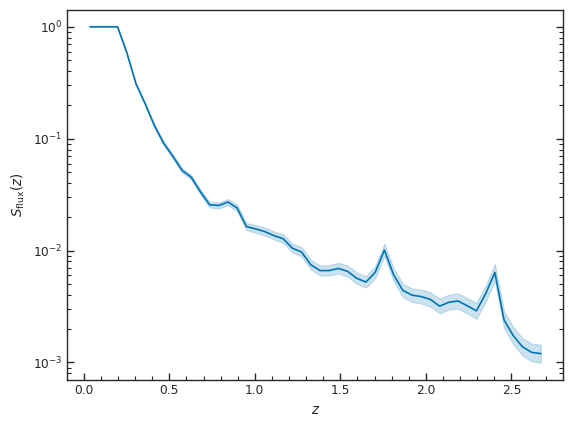

In [93]:
plt.figure()

plt.plot(z_range, S_flux_qso_z_q[1], color=cs[0])
plt.fill_between(z_range, S_flux_qso_z_q[0], S_flux_qso_z_q[2], color=cs[0], alpha=.2)

plt.xlabel(r"$z$")
plt.ylabel(r"$S_{\rm flux}(z)$")
plt.yscale('log')

plt.show()

Similarly (and relatedly), the flux selection function as a function of luminosity is
$$
S_{\rm flux, QSO}(L_{\rm bol}) = \frac{\int_{z_{\min}}^{z_{\max}(L_{\rm bol})} \phi_{\rm QSO}(L_{\rm bol}, z) dz}{\int_{z_{\min}}^{z_{\max}(L_{{\rm bol,} \max})} \phi_{\rm QSO}(L_{\rm bol}, z) dz}
$$

In [94]:
log_l_range = np.linspace(LOG_LBOL_MIN, LOG_LBOL_MAX, num=50)
qlf_log_l = np.transpose([nquad_vec(lambda z: n_qso_integ(log_l, z),
                                         [[Z_MIN, Z_MAX]], n_roots=1000) for log_l in log_l_range])
qlf_log_l_obs = np.transpose([nquad_vec(lambda z: qlf_observed(log_l, z),
                                         [[Z_MIN, Z_MAX]], n_roots=1000) for log_l in log_l_range])
S_flux_qso_log_l = qlf_log_l_obs / qlf_log_l
S_flux_qso_log_l = interp1d(log_l_range, S_flux_qso_log_l)
S_flux_qso_log_l_q = np.quantile(S_flux_qso_log_l(log_l_range), q=[.16, .5, .84], axis=0)
S_flux_qso_log_l_diff = np.diff(S_flux_qso_log_l_q, axis=0)

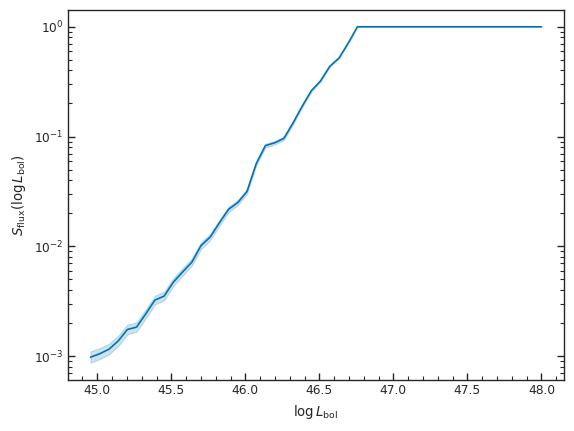

In [95]:
plt.figure()

plt.plot(log_l_range, S_flux_qso_log_l_q[1], color=cs[0])
plt.fill_between(log_l_range, S_flux_qso_log_l_q[0], S_flux_qso_log_l_q[2], color=cs[0], alpha=.2)

plt.xlabel(r"$\log L_{\rm bol}$")
plt.ylabel(r"$S_{\rm flux}(\log L_{\rm bol})$")
plt.yscale('log')

plt.show()

### Total Completeness

Our combined selection functions are
$$
S = S_{\Omega} S_{\rm qual} S_{f} S_{\rm flux},
$$
i.e., the total completeness,
$$
S(z) = S_{\Omega} S_{\rm qual} S_{f} S_{\rm flux}(z),
$$
i.e., the completeness as a funciton of $z$, and
$$
S(L) = S_{\Omega} S_{\rm qual} S_{f} S_{\rm flux}(L),
$$
the completeness as a function of $L$. The total number of binary quasars we might expect, based on the total completeness, is thus
$$
N_{\rm BQ} = \frac{N_{\rm CRTS, complete}}{S},
$$
where $N_{\rm CRTS, complete} = 103$ is the number of spectroscopically and frequency complete samples from CRTS.

In [96]:
N_BQ = N_CRTS_COMPLETE / (S_sky * S_qual * S_flux_qso * S_f)
N_BQ_q = np.quantile(N_BQ, q=[.16, .5, .84])
N_BQ_diff = np.diff(N_BQ_q, axis=0)
display(Math(r'N_{{\rm BQ}} = {0:.0f}_{{-{1:.0f}}}^{{+{2:.0f}}}'.format(N_BQ_q[1], N_BQ_diff[0], N_BQ_diff[1])))

<IPython.core.display.Math object>

While the number in our volume limited region is

In [97]:
N_BQ_REDUCED = N_CRTS_COMPLETE_REDUCED / (S_sky * S_qual * S_flux_qso_reduced * S_f)
N_BQ_REDUCED_q = np.quantile(N_BQ_REDUCED, q=[.16, .5, .84])
N_BQ_REDUCED_diff = np.diff(N_BQ_REDUCED_q, axis=0)
display(Math(r'N_{{\rm BQ}} = {0:.0f}_{{-{1:.0f}}}^{{+{2:.0f}}}'.format(N_BQ_REDUCED_q[1], N_BQ_REDUCED_diff[0], N_BQ_REDUCED_diff[1])))

<IPython.core.display.Math object>

In [98]:
# ndens_tot = nquad_vec(qlf, [[LOG_LBOL_MIN, LOG_LBOL_MAX], [Z_MIN, Z_MAX_CRTS]])
N_QSO = nquad_vec(n_qso_integ, [[LOG_LBOL_MIN, LOG_LBOL_MAX], [Z_MIN, Z_MAX_CRTS]])

# N_QSO = ndens_tot * cosmo.comoving_volume(Z_MAX_CRTS).to(u.Mpc ** 3).value
N_QSO_q = np.quantile(N_QSO, q=[.16, .5, .84])
N_QSO_diff = np.diff(N_QSO_q, axis=0)
display(Math(r'N_{{\rm QSO}} = {0:.0f}_{{-{1:.0f}}}^{{+{2:.0f}}}'.format(N_QSO_q[1], N_QSO_diff[0], N_QSO_diff[1])))

F_BQ = N_BQ / N_QSO
F_BQ_q = np.quantile(F_BQ, q=[.16, .5, .84])
F_BQ_diff = np.diff(F_BQ_q, axis=0)
display(Math(r'\mathcal{{F}}_{{\rm BHB | QSO}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}'.format(F_BQ_q[1], F_BQ_diff[0], F_BQ_diff[1])))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [99]:
# ndens_tot_reduced = nquad_vec(qlf, [[LOG_LBOL_MIN, LOG_LBOL_MAX], [Z_MIN, Z_MAX]])

N_QSO_REDUCED = nquad_vec(n_qso_integ, [[LOG_LBOL_MIN, LOG_LBOL_MAX], [Z_MIN, Z_MAX]])
# N_QSO_REDUCED = ndens_tot_reduced * cosmo.comoving_volume(Z_MAX).to(u.Mpc ** 3).value
N_QSO_REDUCED_q = np.quantile(N_QSO_REDUCED, q=[.16, .5, .84])
N_QSO_REDUCED_diff = np.diff(N_QSO_REDUCED_q, axis=0)
display(Math(r'N_{{\rm QSO}} = {0:.0f}_{{-{1:.0f}}}^{{+{2:.0f}}}'.format(N_QSO_REDUCED_q[1], N_QSO_REDUCED_diff[0], N_QSO_REDUCED_diff[1])))

F_BQ_REDUCED = N_BQ_REDUCED / N_QSO_REDUCED
F_BQ_REDUCED_q = np.quantile(F_BQ_REDUCED, q=[.16, .5, .84])
F_BQ_REDUCED_diff = np.diff(F_BQ_REDUCED_q, axis=0)
display(Math(r'\mathcal{{F}}_{{\rm BHB | QSO}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}'.format(F_BQ_REDUCED_q[1], F_BQ_REDUCED_diff[0], F_BQ_REDUCED_diff[1])))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Obviously this binary fraction is unphysical. This implies that the maximum number of actual binaries in the CRTS sample is
$$
N_{\rm BQ, max} = \frac{N_{\rm CRTS}}{\mathcal{F}_{\rm BHB | QSO}}
$$
<!-- That's about 50% of all quasars! However there is probably more nuance than this. In the next section we'll use a mock quasar sample and a mock binary quasar sample (matched to the CRTS sample) to evaluate how this occupation fraction varies with redshift and luminosity. -->

In [100]:
N_BQ_MAX = N_CRTS_COMPLETE * np.minimum(1, 1 / F_BQ)
N_BQ_MAX_q = np.quantile(N_BQ_MAX, q=[.16, .5, .84])
N_BQ_MAX_diff = np.diff(N_BQ_MAX_q, axis=0)
display(Math(r'N_{{\rm BQ, max}} = {0:.0f}_{{-{1:.0f}}}^{{+{2:.0f}}}'.format(N_BQ_MAX_q[1], N_BQ_MAX_diff[0], N_BQ_MAX_diff[1])))

<IPython.core.display.Math object>

In [101]:
PPV_CRTS_MAX = np.minimum(1., 1. / F_BQ)
PPV_CRTS_MAX_q = np.quantile(PPV_CRTS_MAX, q=[.16, .5, .84])
PPV_CRTS_MAX_diff = np.diff(PPV_CRTS_MAX_q, axis=0)
display(Math(r'PPV_{{\rm CRTS, max}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}'.format(PPV_CRTS_MAX_q[1], PPV_CRTS_MAX_diff[0], PPV_CRTS_MAX_diff[1])))

<IPython.core.display.Math object>

In [102]:
N_BQ_MAX_REDUCED = N_CRTS_COMPLETE_REDUCED * np.minimum(1, 1 / F_BQ_REDUCED)
N_BQ_MAX_REDUCED_q = np.quantile(N_BQ_MAX_REDUCED, q=[.16, .5, .84])
N_BQ_MAX_REDUCED_diff = np.diff(N_BQ_MAX_REDUCED_q, axis=0)
display(Math(r'N_{{\rm BQ, max}} = {0:.0f}_{{-{1:.0f}}}^{{+{2:.0f}}}'.format(N_BQ_MAX_REDUCED_q[1], N_BQ_MAX_REDUCED_diff[0], N_BQ_MAX_REDUCED_diff[1])))

<IPython.core.display.Math object>

In [103]:
PPV_CRTS_MAX_REDUCED = np.minimum(1, 1/ F_BQ_REDUCED)
PPV_CRTS_MAX_REDUCED_q = np.quantile(PPV_CRTS_MAX_REDUCED, q=[.16, .5, .84])
PPV_CRTS_MAX_REDUCED_diff = np.diff(PPV_CRTS_MAX_REDUCED_q, axis=0)
display(Math(r'N_{{\rm BQ, max}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}'.format(PPV_CRTS_MAX_REDUCED_q[1], PPV_CRTS_MAX_REDUCED_diff[0], PPV_CRTS_MAX_REDUCED_diff[1])))

<IPython.core.display.Math object>

In [104]:
# Let's also save all of our completeness information
with h5py.File('../data/processed/crts_completeness.h5', 'w') as hf:
    hf.create_dataset('S_sky', data=S_sky)
    hf.create_dataset('S_qual', data=S_qual)
    hf.create_dataset('S_f', data=S_f)

# QLF Sampler

Next we'll import our quasar sampler, into which we'll plug the above model. We'll use this sampler to generate mock quasar populations.

In [105]:
from src.models.quasar_generator import QuasarSampler

In [106]:
%%time
qso_gen = QuasarSampler(qlf, [[LOG_LBOL_MIN, LOG_LBOL_MAX], [Z_MIN, Z_MAX]])

CPU times: user 1min 46s, sys: 4.05 s, total: 1min 50s
Wall time: 1min 50s


## Mock Quasar Sample

First let's get a general idea of how the quasar population compares to the binary quasar population. While we'll do this in more detail below with a population of mock quasars and mock binary quasars, we can start with a simple comparison of the overall sizes of each of these populations. As before, We'll compare the full $z$ range and the reduced range.

Now let's generate a mock quasar population.

In [107]:
%%time
mock_qso_pop = qso_gen.rvs(size='auto', cosmo=cosmo, ler=ler)

mock_qso_pop = pd.DataFrame(np.array(mock_qso_pop), columns=['log_l_bol', 'z', 'log_mbh'])
mock_qso_pop.to_csv('../data/processed/mock_qso_pop.csv', index=False)
mock_qso_pop

CPU times: user 1h 34min 35s, sys: 9min 15s, total: 1h 43min 50s
Wall time: 11min 39s


,log_l_bol,z,log_mbh
0,45.725668,0.945029,8.818094
1,45.046776,1.484634,7.978089
2,45.101064,0.644249,8.302849
3,45.141742,1.302753,8.870969
4,44.995290,1.394259,8.711230
...,...,...,...
11120673,46.155250,1.350242,9.400394
11120674,45.068624,1.066727,8.331811
11120675,45.491236,1.473637,7.820162
11120676,45.376731,1.085114,8.927115


While it would be nice to compare this to the original QSO population seen by CRTS, we lack information on how many of those sources are from the spectroscopically complete part of the survey. This prevents a direct comparison.

In [108]:
# %%time
# plt.figure()

# plt.scatter(mock_qso_pop['z'], mock_qso_pop['log_l_bol'], rasterized=True)

# plt.plot(z_plot, log_l_bol_complete_crts_fn(z_plot), color='k', linestyle='--', label=r'CRTS Flux Complete, $V = 19$', rasterized=True)
# plt.plot(z_plot, log_l_bol_max_crts_fn(z_plot), color='k', linestyle='-.', label=r'CRTS Flux Limit, $V = 21.5$', rasterized=True)

# plt.xlabel(r'$z$')
# plt.ylabel(r'$\log L_{\rm bol} \ [\rm{erg} \; \rm{s}^{-1}]$')

# plt.xlim(0, 1.5)
# plt.ylim(LOG_LBOL_MIN, LOG_LBOL_MAX)

# plt.legend(loc=0)

# plt.tight_layout()

# # plt.title("Old")

# plt.savefig('../reports/figures/mock_qso_pop.pdf')
# plt.show()

### Expectation value upper limits

Since we have all of our selection functions, let's do some initial comparison to the CRTS sample.
The number of quasars available to CRTS for classification is
$$
N_{\rm QSO} = S_{\Omega} S_{Q} S_{\rm S} N_{\rm QSO}',
$$
where $S_{\Omega}$ is the sky averaged sky selection function, $S_{Q}$ is the population averaged quality selection function, $S_{\rm S}$ is the population averaged spectroscopic sensitivity selection function (we will later make this a function of luminosity and redshift), and  $N_{\rm QSO}'$ is the total number of quasars in the observable universe.
Likewise, the number of binaries available to CRTS is
$$
N_{\rm BQ} = S_{\Omega} S_{Q} S_{\rm S} N_{\rm BQ}',
$$
where $N_{\rm BQ}' = \mathcal{F}_{\rm BHB | QSO} N_{\rm QSO}'$ is the number of binary quasars in the universe and $\mathcal{F}_{\rm BHB | QSO}$ is the binary fraction of quasars.
For the rest of this analysis we will focus on these sky, quality, and spectroscopy limited populations, which are matched to CRTS.

The number of samples in CRTS is $N_{\rm CRTS} = TP + FP$, where $TP$ is the number of true positives and $FP$ is the number of false positives.
We can likewise write the total number of binary quasars available to CRTS as $N_{\rm BQ} = TP + FN$, where $FN$ is the number of false negatives.
Finally, we also have $N_{\rm QSO} = TP + FP + TN + FN$, where $TN$ is the number of false negatives.
This of course implies that
$$
\mathcal{F}_{\rm BHB|QSO} = \frac{TP + FN}{TP + FP + TN + FN}.
$$

We know that CRTS also has a limited frequency sensitivity, implying that it is affected by a frequency selection function, $S_{f}$.
However the effect of this selection function on $FP$ is ill understood.
Instead, let's note that samples rejected for low sensitivity can be considered false negatives, such that
$$
FN \geq (1 - S_{f}) N_{\rm BQ},
$$
where $(1 - S_{f}) N_{\rm BQ}$ is the number of binaries rejected for having too low a frequency.
This implies that the false negative rate (FNR) is bound by
$$
FNR = \frac{FN}{TP + FN} \geq (1 - S_{f}).
$$
It also implies
$$
\begin{align*}
&(1 - S_{f}) N_{\rm BQ} \leq N_{\rm BQ} - TP \\
\Rightarrow &TP \leq N_{\rm BQ} - (1 - S_{f}) N_{\rm BQ} \\
&TP \leq S_{f} N_{\rm BQ} \\
\\
\Rightarrow &\mathrm{Precision} = \frac{TP}{TP + FP} \leq \frac{S_{f} N_{\rm BQ}}{N_{\rm CRTS}}
\end{align*}
$$
Since we do not kow $\mathcal{F}_{\rm BHB | QSO}$, we do not know $N_{\rm BQ}$. However we do know that $N_{\rm BQ} \leq N_{\rm QSO}$, so
$$
\begin{align*}
&\mathrm{Precision} \leq \frac{S_{f} N_{\rm QSO}}{N_{\rm CRTS}} \\
\Rightarrow &\mathrm{Precision} \leq \min\left(1, \frac{S_{f} N_{\rm QSO}}{N_{\rm CRTS}}\right)
\end{align*}
$$





<!-- $$
\frac{\Delta^{2} N_{\rm CRTS}}{\Delta \log L \Delta z} = S(\log L, z) \mathcal{F}_{\rm BHB | QSO}(\log L, z) \frac{\Delta^{2} N_{\rm QSO}}{\Delta \log L \Delta z}.
$$ -->
<!-- If we assume $\mathcal{F}_{\rm BHB | QSO} =1$, we can place an upper limit on the binary population by applying the CRTS selection functions to our mock quasar population. -->
<!-- In theory, the number of quasars, $N_{\rm QSO}$ and the number of CRTS binary candidates $N_{\rm CRTS}$ in bins of size $\Delta \log L$ by $\Delta z$ are related by
$$
\frac{\Delta^{2} N_{\rm CRTS}}{\Delta \log L \Delta z} = S(\log L, z) \mathcal{F}_{\rm BHB | QSO}(\log L, z) \frac{\Delta^{2} N_{\rm QSO}}{\Delta \log L \Delta z},
$$
where $S(\log L, z) = S_{\Omega} S_{\rm qual} S_{f} S_{\rm spec}(\log L, z)$, with $S_{\Omega}$, $S_{\rm qual}$, $S_{f}$, and $S_{\rm spec}(\log L, z)$ all known, and $\mathcal{F}_{\rm BHB | QSO}(\log L, z) \leq 1$ is the binary occupation fraction. In practice, $N_{\rm CRTS} = TP + FP$, where $TP$ is the number of true positives and $FP$ the number of false positives in the sample. The total quasar sample can be divided into $TP$, $FP$, the number of true negatives, $TN$, and the number of false negatives, $FN$, i.e., 
$$
S(\log L, z) \frac{\Delta^{2} N_{\rm QSO}}{\Delta \log L \Delta z} = \frac{\Delta^{2} (TP + FP + TN + FN)}{\Delta \log L \Delta z}.
$$
The number of true binary quasars available to CRTS, $N_{\rm BQ} = TP + FN$, is
$$
\frac{\Delta^{2} N_{\rm BQ}}{\Delta \log L \Delta z} = S(\log L, z) \mathcal{F}_{\rm BHB | QSO}(\log L, z) \frac{\Delta^{2} N_{\rm QSO}}{\Delta \log L \Delta z}.
$$

$$
\mathcal{F}_{\rm BHB | QSO} = \frac{TP + FN}{TP + TN + FP + FN}
$$

$$
\mathcal{F}_{\rm obs, BHB | QSO} = \frac{TP + FP}{TP + TN + FP + FN}
$$

$$
\frac{\Delta^{2} N_{\rm CRTS}}{\Delta \log L \Delta z} = TP + FP = TP + FN + FP + TN - (FN + TN) = N_{\rm BQ} + 
$$ -->

In [109]:
# to get better averages, we'll actually only apply the spectroscopic
# selection function to the mock quasar population, and we'll use the
# other selection effects as a weight
S_CRTS = S_sky * S_qual
S_CRTS = S_CRTS.value
# bq_upper_limit_pop = mock_qso_pop.sample(replace=False, frac=S_const_CRTS)

S_spec = S(mock_qso_pop['log_l_bol'], mock_qso_pop['z'])
S_spec_mask = S_spec == 1

crts_matched_qsos = mock_qso_pop[S_spec_mask]
S_spec_mean = len(crts_matched_qsos) / len(mock_qso_pop)  # population averaged spectroscopy completeness

N_QSO_CRTS = np.random.poisson(len(crts_matched_qsos) * S_CRTS, size=1000)
N_QSO_CRTS_q = np.quantile(N_QSO_CRTS, q=[.16, .5, .84])
N_QSO_CRTS_diff = np.diff(N_QSO_CRTS_q)
display(Math(r'N_{{\rm QSO}} = {0:.0f}_{{-{1:.0f}}}^{{+{2:.0f}}}'.format(N_QSO_CRTS_q[1], N_QSO_CRTS_diff[0], N_QSO_CRTS_diff[1])))

<IPython.core.display.Math object>

From this we can infer the maximum number of true positives in CRTS, since $TP \leq S_{f} N_{\rm BQ} \leq S_{f} N_{\rm QSO}$.

In [110]:
true_pos_max = np.random.poisson(len(crts_matched_qsos) * S_CRTS * S_f, size=1000)

true_pos_max_q = np.quantile(true_pos_max, q=[.16, .5, .84])
true_pos_max_diff = np.diff(true_pos_max_q)
display(Math(r'TP_{{\max}} = {0:.0f}_{{-{1:.0f}}}^{{+{2:.0f}}}'
             .format(true_pos_max_q[1], true_pos_max_diff[0], true_pos_max_diff[1])))

<IPython.core.display.Math object>

In [111]:
precision_max = np.minimum(1, true_pos_max / N_CRTS_COMPLETE_REDUCED)

precision_max_q = np.quantile(precision_max, q=[.16, .5, .84])
precision_max_diff = np.diff(precision_max_q)
display(Math(r'\rm{{Precision}}_{{\max}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}'
             .format(precision_max_q[1], precision_max_diff[0], precision_max_diff[1])))

<IPython.core.display.Math object>

This is similar to the populaiton-averaged maximum number of real binaries we estimated earlier, just from the selection functions themselves. Now let's get a bit more nuanced by using bins to compare the luminosity and redshift distribution of these quasars. We assume Poisson errors on the counts in each bin.

In [112]:
def vol(z1, z2):
    v1 = cosmo.comoving_volume(z1).to(u.Mpc ** 3).value
    v2 = cosmo.comoving_volume(z2).to(u.Mpc ** 3).value
    v = v2 - v1
    return v

#### Binned

In [113]:
# qso_binning_pop = mock_qso_pop.sample(frac=S_f*S_CRTS, replace=False)

log_l_bw = .2
log_l_bins = np.arange(LOG_LBOL_MIN, LOG_LBOL_MAX + log_l_bw * .5, log_l_bw)

log_l_bin_min, log_l_bin_max = log_l_bins[:-1], log_l_bins[1:]
log_l_bin_mid = np.mean([log_l_bin_min, log_l_bin_max], axis=0)

z_bw = .1
z_bins = np.arange(0, Z_MAX + z_bw * .5, z_bw)

z_bins[0] = Z_MIN
z_bin_min, z_bin_max = z_bins[:-1], z_bins[1:]
z_bin_mid = np.mean([z_bin_min, z_bin_max], axis=0)

In [114]:
bw_2d = log_l_bw * z_bw

In [115]:
# next we need to bin N_QSO
# really, we want a binned distribution, so we'll also divide by the bin size
qso_complete_counts, _, __ = np.histogram2d(
    mock_qso_pop['log_l_bol'],
    mock_qso_pop['z'],
    bins=[log_l_bins, z_bins],
    weights=np.ones_like(mock_qso_pop['z']) / bw_2d
    # weights=S_CRTS*np.ones_like(mock_qso_pop['log_l_bol'])
)

In [116]:
bq_upper_limit_counts, _, __ = np.histogram2d(
    mock_qso_pop['log_l_bol'],
    mock_qso_pop['z'],
    bins=[log_l_bins, z_bins],
    weights=S_CRTS * np.ones_like(mock_qso_pop['log_l_bol']) / bw_2d
)

bq_upper_limit_counts_matched, _, __ = np.histogram2d(
    crts_matched_qsos['log_l_bol'],
    crts_matched_qsos['z'],
    bins=[log_l_bins, z_bins],
    weights=S_CRTS * np.ones_like(crts_matched_qsos['log_l_bol']) / bw_2d
)

bq_upper_limit_pop_counts = S_f * bq_upper_limit_counts
bq_upper_limit_pop_counts_matched = S_f * bq_upper_limit_counts_matched
# bq_upper_limit_pop_counts_masked = np.ma.array(bq_upper_limit_pop_counts, mask=crts_unobs_mask, fill_value=1e20)

# bq_upper_limit_pop_counts = bq_upper_limit_pop_counts * S_const_CRTS  # maximum expected number binary quasars in each bin
# bq_upper_limit_pop_counts_errs = poisson.std(bq_upper_limit_pop_counts)

/var/folders/1z/bwsppzbn3zd4q4lgr56l76tm0000gn/T/ipykernel_60994/1784015635.py:5: RuntimeWarning: divide by zero encountered in log10
  bq_upper_limit_plt = np.log10(bq_upper_limit_pop_counts.T)


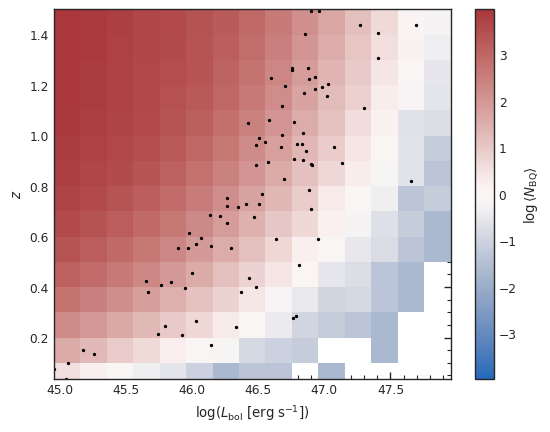

In [117]:
from matplotlib import colors

plt.figure()

bq_upper_limit_plt = np.log10(bq_upper_limit_pop_counts.T)

# divnorm = colors.TwoSlopeNorm(vmin=np.min(bq_upper_limit_plt), vcenter=0, vmax=np.max(bq_upper_limit_plt))
divnorm = colors.CenteredNorm()
c = plt.pcolormesh(log_l_bins, z_bins, bq_upper_limit_plt,
                   cmap='vlag', norm=divnorm)
cb = plt.colorbar(c)

plt.scatter(reduced_crts_complete['log_l_bol'], reduced_crts_complete['z'], color='k', marker='.', s=10)

cb.set_label(r"$\log \langle N_{\rm BQ} \rangle$")

plt.xlabel(r"$\log (L_{\rm bol} \; [\rm{erg}\; s^{-1}])$")
plt.ylabel(r"$z$")
# plt.title("Maximum Binary Quasar Population")
plt.show()

In [118]:
# make masked arrays so we only see bins where there could have been data
ll, zz = np.meshgrid(log_l_bin_max, z_bin_min, indexing='ij')
crts_unobs_mask = ll < log_l_bol_complete_crts_fn(zz)

# bq_max_hist_mask = bq_upper_limit_pop_counts == 0

In [119]:
bq_upper_limit_pop_counts_masked = np.ma.array(bq_upper_limit_pop_counts, mask=crts_unobs_mask, fill_value=1e20)

# bq_upper_limit_pop_counts = bq_upper_limit_pop_counts * S_const_CRTS  # maximum expected number binary quasars in each bin
# bq_upper_limit_pop_counts_errs = poisson.std(bq_upper_limit_pop_counts)

/var/folders/1z/bwsppzbn3zd4q4lgr56l76tm0000gn/T/ipykernel_60994/3781380030.py:3: RuntimeWarning: divide by zero encountered in log10
  bq_upper_limit_plt = np.log10(bq_upper_limit_pop_counts_masked.T)


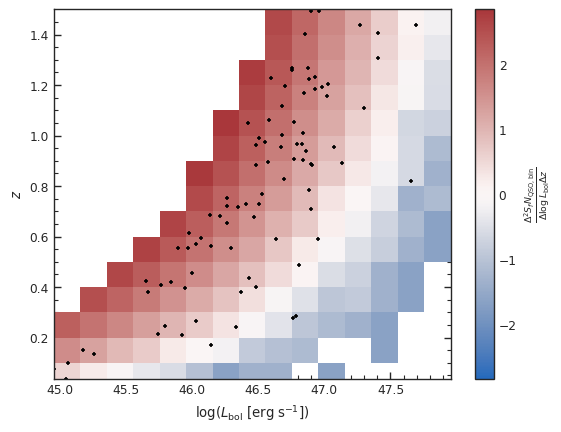

In [120]:
plt.figure()

bq_upper_limit_plt = np.log10(bq_upper_limit_pop_counts_masked.T)

# divnorm = colors.TwoSlopeNorm(vmin=np.min(bq_upper_limit_plt), vcenter=0, vmax=np.max(bq_upper_limit_plt))
divnorm = colors.CenteredNorm()
c = plt.pcolormesh(log_l_bins, z_bins, bq_upper_limit_plt,
                   cmap='vlag', norm=divnorm)
cb = plt.colorbar(c)

plt.scatter(reduced_crts_complete['log_l_bol'], reduced_crts_complete['z'], color='k', marker='+')

cb.set_label(r"$\frac{\Delta^{2} S_{f} N_{\rm QSO, bin}}{\Delta \log L_{\rm bol} \Delta z}$")

plt.xlabel(r"$\log (L_{\rm bol} \; [\rm{erg}\; s^{-1}])$")
plt.ylabel(r"$z$")
# plt.title("Maximum Binary Quasar Population")
plt.show()

In [121]:
# first let's bin the CRTS sample
reduced_crts_complete_counts, _, __ = np.histogram2d(
    reduced_crts_complete['log_l_bol'],
    reduced_crts_complete['z'],
    bins=[log_l_bins, z_bins],
    weights=np.ones_like(reduced_crts_complete['z']) / bw_2d
)
# reduced_crts_complete_counts_errs = poisson.std(reduced_crts_complete_counts)

In [122]:
reduced_crts_complete_counts_masked = np.ma.array(reduced_crts_complete_counts, mask=crts_unobs_mask, fill_value=1e20)

/var/folders/1z/bwsppzbn3zd4q4lgr56l76tm0000gn/T/ipykernel_60994/2713501952.py:3: RuntimeWarning: divide by zero encountered in log10
  reduced_crts_complete_counts_plt = np.log10(reduced_crts_complete_counts_masked.T)


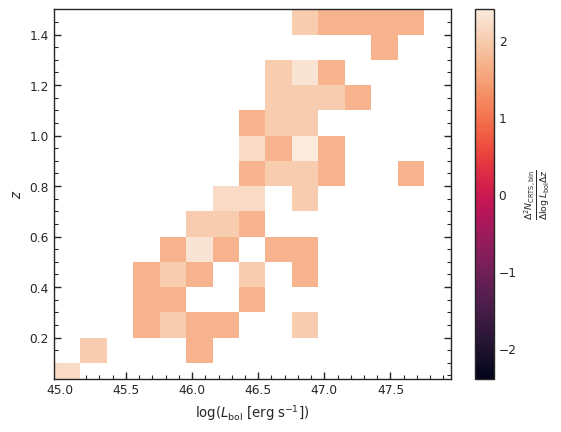

In [123]:
plt.figure()

reduced_crts_complete_counts_plt = np.log10(reduced_crts_complete_counts_masked.T)

divnorm = colors.CenteredNorm()
c = plt.pcolormesh(log_l_bins, z_bins, reduced_crts_complete_counts_plt,
                   norm=divnorm)
cb = plt.colorbar(c)

cb.set_label(r"$\frac{\Delta^{2}N_{\rm CRTS, bin}}{\Delta \log L_{\rm bol} \Delta z}$")

plt.xlabel(r"$\log (L_{\rm bol} \; [\rm{erg}\; s^{-1}])$")
plt.ylabel(r"$z$")
# plt.title("CRTS Counts")
plt.show()

In [124]:
# now let's calculate the max precision in each bin, as we did before for the whole population
precision_crts = np.minimum(1, bq_upper_limit_pop_counts_masked / reduced_crts_complete_counts_masked)

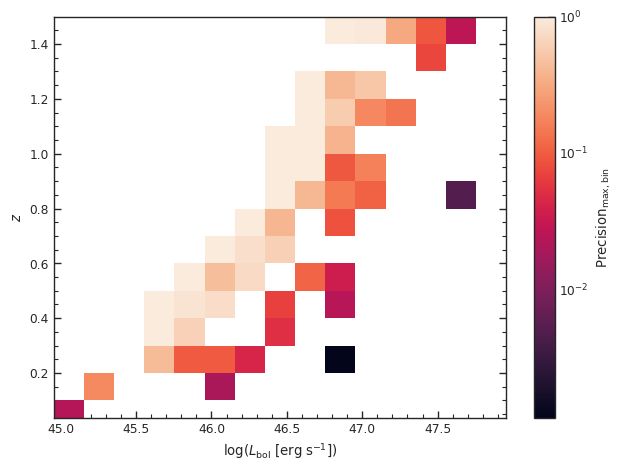

In [125]:
plt.figure()

c = plt.pcolormesh(log_l_bins, z_bins, precision_crts.T, norm=colors.LogNorm())
cb = plt.colorbar(c)
cb.set_label(r"$\rm{Precision}_{\rm max, bin}$")

plt.xlabel(r"$\log (L_{\rm bol} \; [\rm{erg}\; s^{-1}])$")
plt.ylabel(r"$z$")
# plt.title("Maximum Precision")

plt.tight_layout()
plt.savefig('../reports/figures/crts_max_precision_bw_logl_05_z_025.pdf')
plt.show()

We can find the maximum number of real binaries in CRTS by performing a weighted sum over the CRTS sample.

In [126]:
log_l_idx = np.digitize(reduced_crts_complete['log_l_bol'], bins=log_l_bins) - 1
z_idx = np.digitize(reduced_crts_complete['z'], bins=z_bins) - 1
w_crts = precision_crts[log_l_idx, z_idx] #/ (z_bw * log_l_bw)

N_CRTS_MAX_REAL = np.random.poisson(np.sum(w_crts), size=1000)
N_CRTS_MAX_REAL_q = np.quantile(N_CRTS_MAX_REAL, q=[.16, .5, .84])
N_CRTS_MAX_REAL_diff = np.diff(N_CRTS_MAX_REAL_q)
display(Math(r'N_{{\rm BQ, max}} = {0:.0f}_{{-{1:.0f}}}^{{+{2:.0f}}}'.format(N_CRTS_MAX_REAL_q[1], N_CRTS_MAX_REAL_diff[0], N_CRTS_MAX_REAL_diff[1])))

crts_max_real_frac = N_CRTS_MAX_REAL / N_CRTS_COMPLETE_REDUCED
crts_max_real_frac_q = np.quantile(crts_max_real_frac, q=[.16, .5, .84])
crts_max_real_frac_diff = np.diff(crts_max_real_frac_q)
display(Math(r'N_{{\rm BQ, max}} / N_{{\rm CRTS}} = {0:.2f}_{{-{1:.2f}}}^{{+{2:.2f}}}'
             .format(crts_max_real_frac_q[1], crts_max_real_frac_diff[0], crts_max_real_frac_diff[1])))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [127]:
reduced_crts_complete['weight'] = w_crts
reduced_crts_complete['weight']

/var/folders/1z/bwsppzbn3zd4q4lgr56l76tm0000gn/T/ipykernel_60994/942443320.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_crts_complete['weight'] = w_crts


1      0.393928
2      0.309740
3      0.572433
5      1.000000
6      0.096794
         ...   
105    0.139113
106    0.072933
107    1.000000
109    0.096344
110    1.000000
Name: weight, Length: 87, dtype: float64

The maximum number of binaries in the reduced sample is approximately $37 / 87$, or $43 \%$. This varies significantly as a function of luminosity and redshift. Let's look at how this varies by luminosity and redshift bin, as well as as a function of luminosity and redshift simultaneously.

In [128]:
reduced_crts_complete_counts_real, _, __ = np.histogram2d(
    reduced_crts_complete['log_l_bol'],
    reduced_crts_complete['z'],
    bins=[log_l_bins, z_bins],
    weights=reduced_crts_complete['weight']
)

In [129]:
reduced_crts_complete_counts_real_log_l = np.sum(reduced_crts_complete_counts_real, axis=1)
reduced_crts_complete_counts_real_z = np.sum(reduced_crts_complete_counts_real, axis=0)

In [130]:
# let's also calculate the expected occupation fraction in each bin
occ_frac_bins = reduced_crts_complete_counts_real / (S_f * qso_complete_counts)
occ_frac_log_l = reduced_crts_complete_counts_real_log_l / np.sum(S_f * qso_complete_counts, axis=1)
occ_frac_z = reduced_crts_complete_counts_real_z / np.sum(S_f * qso_complete_counts, axis=0)

/var/folders/1z/bwsppzbn3zd4q4lgr56l76tm0000gn/T/ipykernel_60994/2119840898.py:2: RuntimeWarning: invalid value encountered in true_divide
  occ_frac_bins = reduced_crts_complete_counts_real / (S_f * qso_complete_counts)


In [131]:
# finally, we can also calculate the total number of expected binaries in the volume z<= 1.5
N_BQ_REDUCED = N_CRTS_MAX_REAL / (S_sky * S_qual * S_flux_qso_reduced * S_f)
N_BQ_REDUCED_q = np.quantile(N_BQ_REDUCED, q=[.16, .5, .84])
N_BQ_REDUCED_diff = np.diff(N_BQ_REDUCED_q, axis=0)
display(Math(r"N_{{\rm BQ}}' = {0:.0f}_{{-{1:.0f}}}^{{+{2:.0f}}}".format(N_BQ_REDUCED_q[1], N_BQ_REDUCED_diff[0], N_BQ_REDUCED_diff[1])))

<IPython.core.display.Math object>

In [132]:
hs = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']

In [133]:
crts_edges = np.histogram_bin_edges(reduced_crts_complete['log_l_bol'], weights=reduced_crts_complete['weight'])

#### weights comparison

In [134]:
crts_log_l_edges = np.histogram_bin_edges(reduced_crts_complete['log_l_bol'], weights=reduced_crts_complete['weight'])

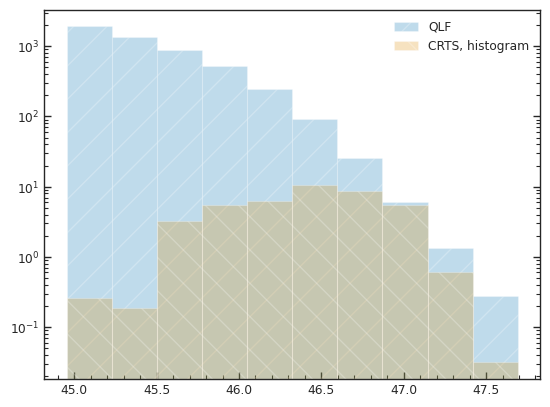

In [135]:
plt.figure()

plt.hist(mock_qso_pop['log_l_bol'],
         bins=crts_log_l_edges,
         weights=np.full_like(mock_qso_pop['log_l_bol'], S_f*S_qual*S_sky),
         log=True,
         label='QLF',
         alpha=.25,
         hatch=hs[0],
        )
plt.hist(reduced_crts_complete['log_l_bol'],
         bins=crts_log_l_edges,
         weights=reduced_crts_complete['weight'],
         log=True,
         label='CRTS, histogram',
         alpha=.25,
         hatch=hs[1],
        )

plt.legend(frameon=False)
plt.show()

In [136]:
crts_z_edges = np.histogram_bin_edges(reduced_crts_complete['z'], weights=reduced_crts_complete['weight'])

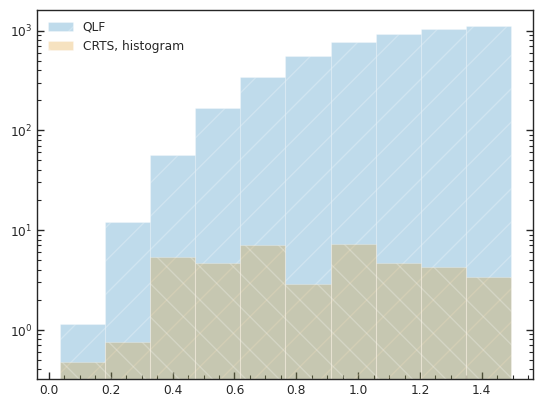

In [137]:
plt.figure()

plt.hist(mock_qso_pop['z'],
         bins=crts_z_edges,
         weights=np.full_like(mock_qso_pop['z'], S_f*S_qual*S_sky),
         log=True,
         label='QLF',
         alpha=.25,
         hatch=hs[0],
        )
plt.hist(reduced_crts_complete['z'],
         bins=crts_z_edges,
         weights=reduced_crts_complete['weight'],
         log=True,
         label='CRTS, histogram',
         alpha=.25,
         hatch=hs[1],
        )

plt.legend(frameon=False)
plt.show()

## Binary Quasar Sample

We will next select a subset of this mock quasar population as a mock binary quasar population. First we'll do this for the entire sample at once, i.e., we'll take the number of binary quasars prediced above and simply assign that many quasars from our mock population as binary quasars.
After that we will bin the CRTS candidates up and make more detailed selections based on the number of predicted binary candidates in each bin.

The number of candidates expected in the $i$th $z$-bin is

$$
N_{\rm BQ, i} = V_{\rm CRTS}(z_{\min, i}, z_{\max, i}) \int_{z_{\min, i}}^{z_{\max, i}} \int_{L_{\min}(z)}^{L_{\max}} \phi_{\rm BQ}(L, z) dL dz,
$$
where $V_{\rm CRTS}(z_{\min, i}, z_{\max, i})$ is the volume probed by CRTS in a given redshift interval $z \in [z_{\min}, z_{\max}]$, and $L_{\min}(z)$ is a possibly $z$ dependent luminosity completeness limit.

In [138]:
# we choose the number of quasars similarly to the way the autogenerated models work
# we are essentially equally weighting the number of BQs from each monte carlo model
mock_bq_pop = pd.DataFrame(columns=['log_l_bol', 'z', 'log_mbh', 'f_gw', 'log_f_gw', 'q', 'strain'], dtype=float)

# we'll first choose a random number of quasars as binary candidates.
# we'll generate this sample so that it is matched to the sky coverage
# and data quality of CRTS. That way we can ensure information from the
# scpetroscopic and frequency complete regions are solely due to CRTS
n = np.sum(np.random.poisson(N_BQ_REDUCED
                             / len(N_BQ_REDUCED)))
# idxs = np.random.choice(range(len(mock_qso_pop)), size=n, replace=False)

bqs = mock_qso_pop.sample(n=n, replace=False)
# bqs = bqs.rename(columns={'log_l': 'log_l_bol'})
bqs['f_gw'] = f_dist.rvs(size=n)
bqs['log_f_gw'] = np.log10(bqs['f_gw'])
# add these back if continuing with the discrete characteristic strain calculation
# also requires a mass estimate using log_L_bol - log_edd
bqs['q'] = q_dist.rvs(size=n)
bqs['strain'] = strain(bqs['log_mbh'], bqs['f_gw'], bqs['z'], q=bqs['q'], cosmo=cosmo)

mock_bq_pop = pd.concat([mock_bq_pop, bqs], ignore_index=True)
mock_bq_pop.to_csv('../data/processed/mock_bq_pop.csv', index=False)
mock_bq_pop

,log_l_bol,z,log_mbh,f_gw,log_f_gw,q,strain
0,46.766283,1.268904,8.955292,2.009054e-09,-8.697008,0.414925,3.990126e-18
1,45.208972,1.430896,8.661018,1.035469e-09,-8.984863,0.963274,9.017618e-19
2,45.242295,0.876202,8.624626,1.264611e-09,-8.898043,0.911871,1.383690e-18
3,45.729895,0.959779,8.922097,1.367433e-09,-8.864094,0.840871,4.175346e-18
4,45.198000,1.214243,7.984580,1.288797e-09,-8.889815,0.969946,8.966720e-20
...,...,...,...,...,...,...,...
4074062,45.491384,1.173708,8.463000,1.303230e-09,-8.884979,0.690522,5.642868e-19
4074063,45.239221,1.357289,7.678641,1.166800e-09,-8.933004,0.628848,2.233205e-20
4074064,45.217972,1.078052,8.116205,1.810862e-09,-8.742115,0.659993,1.985166e-19
4074065,45.029984,1.397238,7.963946,1.587130e-09,-8.799388,0.801791,8.329337e-20


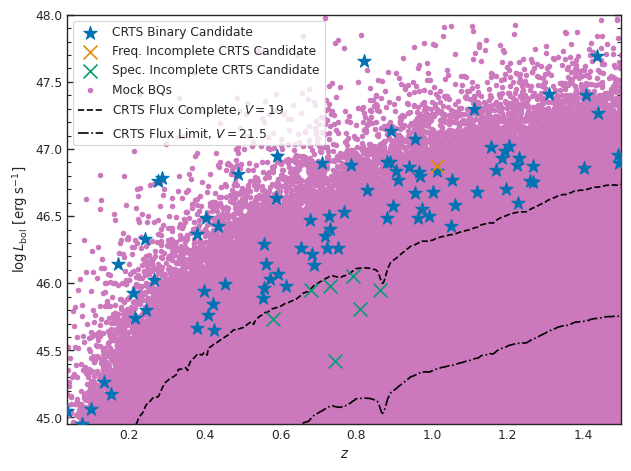

In [139]:
plt.figure()

plt.scatter(reduced_crts_complete['z'], reduced_crts_complete['log_l_bol'], color=cs[0],
            label='CRTS Binary Candidate', marker='*', s=100, zorder=10, rasterized=True)
plt.scatter(crts_f_incomplete['z'], crts_f_incomplete['log_l_bol'],
            color=cs[1], label='Freq. Incomplete CRTS Candidate', marker='x',
            s=100, zorder=10, rasterized=True)
plt.scatter(crts_spec_incomplete['z'], crts_spec_incomplete['log_l_bol'],
            color=cs[2], label='Spec. Incomplete CRTS Candidate', marker='x',
            s=100, zorder=10, rasterized=True)

plt.scatter(mock_bq_pop['z'], mock_bq_pop['log_l_bol'], color=cs[4], label='Mock BQs', rasterized=True)


plt.plot(z_plot, log_l_bol_complete_crts_fn(z_plot), color='k', linestyle='--', label=r'CRTS Flux Complete, $V = 19$', rasterized=True)
plt.plot(z_plot, log_l_bol_max_crts_fn(z_plot), color='k', linestyle='-.', label=r'CRTS Flux Limit, $V = 21.5$', rasterized=True)
# plt.plot(z_plot, completeness_limit_lsst(z_plot), color='k', linestyle=':', label=r'LSST Flux Limit, $V = 25$')

plt.xlabel(r'$z$')
plt.ylabel(r'$\log L_{\rm bol} \ [\rm{erg} \; \rm{s}^{-1}]$')

plt.xlim(Z_MIN, Z_MAX)
plt.ylim(LOG_LBOL_MIN, LOG_LBOL_MAX)

plt.legend(loc=0)

plt.tight_layout()
plt.savefig('../reports/figures/mock_bq_pop.pdf')
plt.show()

In [140]:
# Let's briefly check how this compares to the 87 spectroscopically and
# frequency complete candidates in the reduced sample
# We need to account for sky coverage and quality completeness here
mock_bq_spec_complete = (mock_bq_pop['log_l_bol']
                      >= log_l_bol_complete_crts_fn(mock_bq_pop['z']))
mock_bq_f_complete = mock_bq_pop['log_f_gw'] >= LOG_F_MIN_CRTS
mock_bq_pop_complete = mock_bq_pop[mock_bq_spec_complete
                                   & mock_bq_f_complete]
mock_bq_pop_complete.to_csv('../data/processed/mock_bq_pop_complete.csv', index=False)
mock_bq_pop_complete

,log_l_bol,z,log_mbh,f_gw,log_f_gw,q,strain
33335,45.575251,0.379093,7.940641,1.528250e-08,-7.815806,0.589126,1.110816e-18
60599,46.269661,0.911749,8.566958,1.086815e-08,-7.963845,0.927463,4.488164e-18
112939,46.280930,0.895571,8.719971,1.124929e-08,-7.948875,0.824702,8.333636e-18
113764,45.091774,0.184299,8.043620,1.098328e-08,-7.959268,0.979752,2.924425e-18
114870,46.890208,1.446050,9.529858,1.114621e-08,-7.952873,0.427400,1.026196e-16
...,...,...,...,...,...,...,...
3885233,46.507848,1.159337,9.346712,1.472772e-08,-7.831865,0.812534,8.735583e-17
3886297,46.157267,0.832225,9.051241,1.121895e-08,-7.950048,0.970543,3.203995e-17
3907946,47.183398,1.195418,9.515467,1.530418e-08,-7.815190,0.574472,1.561892e-16
3908674,46.635521,1.302939,9.031808,1.243109e-08,-7.905491,0.782900,2.094938e-17


In [141]:
N_MOCK_COMPLETE = len(mock_bq_pop_complete)
display(Math(r"$N_{{\rm mock, complete}} = {0:.0f}$".format(N_MOCK_COMPLETE)))

N_MOCK_N_REAL_RATIO = N_MOCK_COMPLETE * S_sky * S_qual / N_CRTS_MAX_REAL
N_MOCK_N_REAL_RATIO_q = np.quantile(N_MOCK_N_REAL_RATIO, q=[.16, .5, .84])
N_MOCK_N_REAL_RATIO_diff = np.diff(N_MOCK_N_REAL_RATIO_q)
display(Math(r"$N_{{\rm mock, complete}} / N_{{\rm CRTS, complete}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}$"
             .format(N_MOCK_N_REAL_RATIO_q[1], N_MOCK_N_REAL_RATIO_diff[0], N_MOCK_N_REAL_RATIO_diff[1])))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

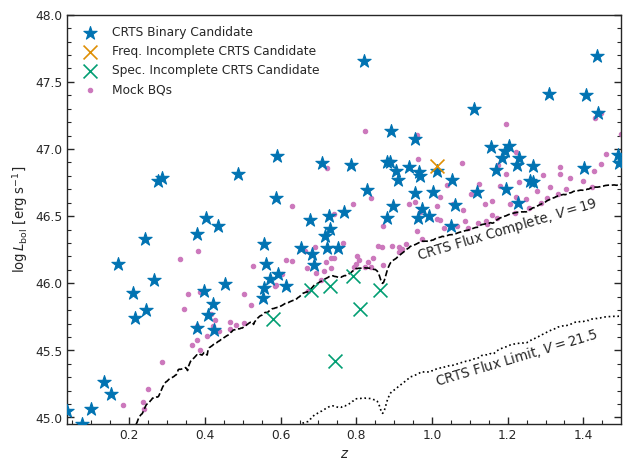

In [142]:
plt.figure()

plt.scatter(reduced_crts_complete['z'], reduced_crts_complete['log_l_bol'], color=cs[0],
            label='CRTS Binary Candidate', marker='*', s=100, zorder=10, rasterized=True)
plt.scatter(crts_f_incomplete['z'], crts_f_incomplete['log_l_bol'],
            color=cs[1], label='Freq. Incomplete CRTS Candidate', marker='x',
            s=100, zorder=10, rasterized=True)
plt.scatter(crts_spec_incomplete['z'], crts_spec_incomplete['log_l_bol'],
            color=cs[2], label='Spec. Incomplete CRTS Candidate', marker='x',
            s=100, zorder=10, rasterized=True)

plt.scatter(mock_bq_pop_complete['z'], mock_bq_pop_complete['log_l_bol'], color=cs[4], label='Mock BQs', rasterized=True)


plt.plot(
    z_plot, 
    log_l_bol_complete_crts_fn(z_plot), 
    color='k', 
    linestyle='--', 
    # label='CRTS flux completeness limit'
)
plt.text(
    z_plot[-475],
    log_l_bol_complete_crts_fn(z_plot[-475])-.05,
    r'CRTS Flux Complete, $V = 19$',
    # textcoords='offset pixels',
    # xytext=(0, -10),
    ha='right',
    va='top',
    transform_rotates_text=True, 
    rotation=40,
    rotation_mode='anchor',
)
plt.plot(
    z_plot,
    log_l_bol_max_crts_fn(z_plot), 
    color='k', 
    linestyle=':', 
    # label='CRTS maximum depth'
)
plt.text(
    z_plot[-475],
    log_l_bol_max_crts_fn(z_plot[-475])-.05,
    r'CRTS Flux Limit, $V = 21.5$',
    # textcoords='offset pixels',
    # xytext=(0, -10),
    ha='right',
    va='top',
    transform_rotates_text=True, 
    rotation=40,
    rotation_mode='anchor',
)

plt.xlabel(r'$z$')
plt.ylabel(r'$\log L_{\rm bol} \ [\rm{erg} \; \rm{s}^{-1}]$')

plt.xlim(Z_MIN, Z_MAX)
plt.ylim(LOG_LBOL_MIN, LOG_LBOL_MAX)

plt.legend(loc=0, frameon=False)

plt.tight_layout()
plt.savefig('../reports/figures/mock_bq_pop_complete.pdf')
plt.show()

We also want to make use of the actual CRTS candidates in future modeling. This can be done by simply excising a proportionate number of mock binary candidates from the spectroscopic and frequency complete region of our population and adding the spectroscopic and frequency complete CRTS candidates. Ultimately we will be doing all our actual modeling with a redshift-bin-matched population, but we can set up the technique here.

In [143]:
mock_bq_pop_incomplete = mock_bq_pop[~mock_bq_spec_complete
                                     | ~mock_bq_f_complete]

# next add in some mock complete binaries to account for sky coverage and data quality
n_unobs = np.random.poisson(N_MOCK_COMPLETE * (1 - S_sky * S_qual))
mock_bq_pop_incomplete = pd.concat([mock_bq_pop_incomplete, mock_bq_pop_complete.sample(n_unobs, replace=False)])
mock_bq_pop_incomplete.to_csv('../data/processed/mock_bq_pop_incomplete.csv', index=False)
mock_bq_pop_incomplete

,log_l_bol,z,log_mbh,f_gw,log_f_gw,q,strain
0,46.766283,1.268904,8.955292,2.009054e-09,-8.697008,0.414925,3.990126e-18
1,45.208972,1.430896,8.661018,1.035469e-09,-8.984863,0.963274,9.017618e-19
2,45.242295,0.876202,8.624626,1.264611e-09,-8.898043,0.911871,1.383690e-18
3,45.729895,0.959779,8.922097,1.367433e-09,-8.864094,0.840871,4.175346e-18
4,45.198000,1.214243,7.984580,1.288797e-09,-8.889815,0.969946,8.966720e-20
...,...,...,...,...,...,...,...
3908674,46.635521,1.302939,9.031808,1.243109e-08,-7.905491,0.782900,2.094938e-17
2767009,46.575421,0.629540,9.270460,1.413716e-08,-7.849638,0.715892,1.099339e-16
3070295,46.606014,0.956112,9.095921,1.365856e-08,-7.864595,0.875298,3.798266e-17
1215742,45.415994,0.287557,8.650727,1.700856e-08,-7.769332,0.858973,2.556480e-17


In [144]:
# plt.figure()

# plt.scatter(reduced_crts_complete['z'], reduced_crts_complete['log_l_bol'], color=cs[0],
#             label='CRTS Binary Candidate', marker='*', s=100, zorder=10, rasterized=True)
# plt.scatter(crts_f_incomplete['z'], crts_f_incomplete['log_l_bol'],
#             color=cs[1], label='Freq. Incomplete CRTS Candidate', marker='x',
#             s=100, zorder=10, rasterized=True)
# plt.scatter(crts_spec_incomplete['z'], crts_spec_incomplete['log_l_bol'],
#             color=cs[2], label='Spec. Incomplete CRTS Candidate', marker='x',
#             s=100, zorder=10, rasterized=True)

# plt.scatter(mock_bq_pop_incomplete['z'], mock_bq_pop_incomplete['log_l_bol'], color=cs[4], label='Mock BQs', rasterized=True)


# plt.plot(z_plot, log_l_bol_complete_crts_fn(z_plot), color='k', linestyle='--', label=r'CRTS Flux Complete, $V = 19$', rasterized=True)
# plt.plot(z_plot, log_l_bol_max_crts_fn(z_plot), color='k', linestyle='-.', label=r'CRTS Flux Limit, $V = 21.5$', rasterized=True)
# # plt.plot(z_plot, completeness_limit_lsst(z_plot), color='k', linestyle=':', label=r'LSST Flux Limit, $V = 25$')

# plt.xlabel(r'$z$')
# plt.ylabel(r'$\log L_{\rm bol} \ [\rm{erg} \; \rm{s}^{-1}]$')

# plt.xlim(Z_MIN, Z_MAX)
# plt.ylim(LOG_LBOL_MIN, LOG_LBOL_MAX)

# plt.legend(loc=0)

# plt.tight_layout()
# plt.savefig('../reports/figures/mock_bq_pop_combined.pdf')
# plt.show()

In [145]:
bq_pop = pd.concat([mock_bq_pop_incomplete, reduced_crts_complete[['log_l_bol',
                                                           'z',
                                                           'log_mbh', 
                                                           'f_gw', 
                                                           'log_f_gw', 
                                                           'q', 
                                                           'strain']]], ignore_index=True)
bq_pop['weight'] = np.ones(len(bq_pop))
bq_pop.to_csv('../data/processed/bq_pop.csv', index=False)
bq_pop

,log_l_bol,z,log_mbh,f_gw,log_f_gw,q,strain,weight
0,46.766283,1.268904,8.955292,2.009054e-09,-8.697008,0.414925,3.990126e-18,1.0
1,45.208972,1.430896,8.661018,1.035469e-09,-8.984863,0.963274,9.017618e-19,1.0
2,45.242295,0.876202,8.624626,1.264611e-09,-8.898043,0.911871,1.383690e-18,1.0
3,45.729895,0.959779,8.922097,1.367433e-09,-8.864094,0.840871,4.175346e-18,1.0
4,45.198000,1.214243,7.984580,1.288797e-09,-8.889815,0.969946,8.966720e-20,1.0
...,...,...,...,...,...,...,...,...
4074121,47.300553,1.111000,9.621955,2.153316e-08,-7.666892,0.793015,3.351880e-16,1.0
4074122,47.406671,1.309000,10.071398,1.736545e-08,-7.760314,0.969073,1.429698e-15,1.0
4074123,46.350987,0.717000,8.146641,1.736545e-08,-7.760314,0.574003,1.420954e-18,1.0
4074124,45.924424,0.211000,9.019766,1.342700e-08,-7.872021,0.586010,1.151604e-16,1.0


### Binned population matching

It's hard to tell from the above plots if the overall quasar population $z$ evolution is well matched to the CRTS $z$ evolution. However the plot comparing just the spectroscopically and frequency complete mock binaries to the CRTS sample seems to suggest they might not be. Next we'll take an approach similar to the above mock binary generation approach. However this time we will choose our binaries in bins, matched to the CRTS candidates in those bins. We'll start just by showing how the fraction of quasars associated with binaries changes with redshift.

In [146]:
N_QSO_REDUCED_z = np.transpose([nquad_vec(n_qso_integ, [[LOG_LBOL_MIN, LOG_LBOL_MAX], [zmn, zmx]]) for zmn, zmx in zip(z_bin_min, z_bin_max)])

N_QSO_REDUCED_z_q = np.quantile(N_QSO_REDUCED_z, q=[.16, .5, .84], axis=0)
N_QSO_REDUCED_z_diff = np.diff(N_QSO_REDUCED_z_q, axis=0)
N_QSO_REDUCED_z_q[1]

array([2.69967722e+02, 3.33708699e+03, 1.59106993e+04, 5.15003867e+04,
       1.27589015e+05, 2.56042780e+05, 4.34624575e+05, 6.47309528e+05,
       8.71338033e+05, 1.08646866e+06, 1.27616860e+06, 1.43302353e+06,
       1.54903954e+06, 1.62838230e+06, 1.67133402e+06])

In [147]:
np.median(np.sum(N_QSO_REDUCED_z, axis=-1) / N_QSO_REDUCED)

1.000000000000209

In [148]:
qso_pop_counts_z, _ = np.histogram(mock_qso_pop['z'], bins=z_bins)
qso_pop_counts_z

array([    308,    3346,   16048,   51444,  128186,  257648,  437310,
        647966,  873719, 1090781, 1282420, 1440605, 1560570, 1643374,
       1686953])

In [149]:
qso_pop_counts_z / N_QSO_REDUCED_z_q[1]

array([1.14087713, 1.0026709 , 1.00862945, 0.99890512, 1.00467897,
       1.00626934, 1.00617872, 1.00101415, 1.00273254, 1.00396913,
       1.00489857, 1.00529054, 1.00744362, 1.0092065 , 1.00934522])

In [150]:
N_QSO_REDUCED_log_l = np.transpose([nquad_vec(n_qso_integ, [[lmn, lmx], [Z_MIN, Z_MAX]]) for lmn, lmx in zip(log_l_bin_min, log_l_bin_max)])
N_QSO_REDUCED_log_l_q = np.quantile(N_QSO_REDUCED_log_l, q=[.16, .5, .84], axis=0)
N_QSO_REDUCED_log_l_diff = np.diff(N_QSO_REDUCED_log_l_q, axis=0)
N_QSO_REDUCED_log_l_q[1]

array([3.22282029e+06, 2.49286835e+06, 1.88615270e+06, 1.37123515e+06,
       9.40940525e+05, 5.85963624e+05, 3.19072189e+05, 1.47682516e+05,
       5.88809175e+04, 2.10984612e+04, 7.16447419e+03, 2.37449410e+03,
       7.80378598e+02, 2.55995191e+02, 8.39129512e+01])

In [151]:
np.median(np.sum(N_QSO_REDUCED_log_l, axis=-1) / N_QSO_REDUCED)

0.9999991685197763

In [152]:
qso_pop_counts_log_l, _ = np.histogram(mock_qso_pop['log_l_bol'], bins=log_l_bins)
qso_pop_counts_log_l

array([3249596, 2511052, 1891994, 1378406,  941032,  588588,  320264,
        148024,   59606,   21324,    7246,    2442,     769,     234,
            90])

In [153]:
qso_pop_counts_log_l / N_QSO_REDUCED_log_l_q[1]

array([1.00830816, 1.00729427, 1.00309694, 1.00522948, 1.00009722,
       1.00447874, 1.00373524, 1.00231228, 1.01231439, 1.01068982,
       1.01137918, 1.02842959, 0.98541913, 0.91407967, 1.07254004])

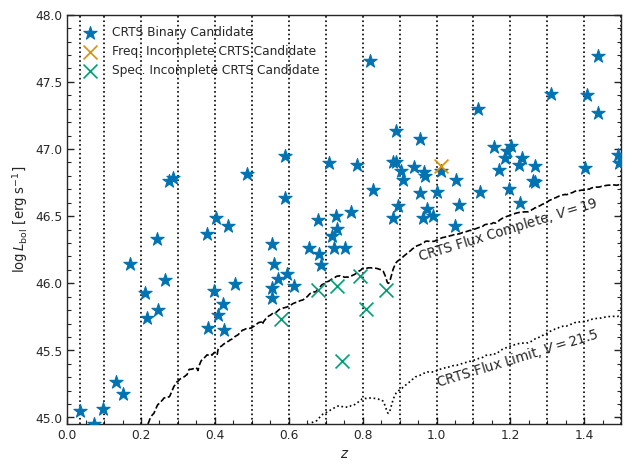

In [154]:
plt.figure()

plt.scatter(reduced_crts_complete['z'], reduced_crts_complete['log_l_bol'], color=cs[0],
            label='CRTS Binary Candidate', marker='*', s=100, zorder=10, rasterized=True)
plt.scatter(crts_f_incomplete['z'], crts_f_incomplete['log_l_bol'],
            color=cs[1], label='Freq. Incomplete CRTS Candidate', marker='x',
            s=100, zorder=10, rasterized=True)
plt.scatter(crts_spec_incomplete['z'], crts_spec_incomplete['log_l_bol'],
            color=cs[2], label='Spec. Incomplete CRTS Candidate', marker='x',
            s=100, zorder=10, rasterized=True)

plt.plot(
    z_plot, 
    log_l_bol_complete_crts_fn(z_plot), 
    color='k', 
    linestyle='--', 
    # label='CRTS flux completeness limit'
)
plt.text(
    z_plot[-475],
    log_l_bol_complete_crts_fn(z_plot[-475])-.05,
    r'CRTS Flux Complete, $V = 19$',
    # textcoords='offset pixels',
    # xytext=(0, -10),
    ha='right',
    va='top',
    transform_rotates_text=True, 
    rotation=40,
    rotation_mode='anchor',
)
plt.plot(
    z_plot,
    log_l_bol_max_crts_fn(z_plot), 
    color='k', 
    linestyle=':', 
    # label='CRTS maximum depth'
)
plt.text(
    z_plot[-475],
    log_l_bol_max_crts_fn(z_plot[-475])-.05,
    r'CRTS Flux Limit, $V = 21.5$',
    # textcoords='offset pixels',
    # xytext=(0, -10),
    ha='right',
    va='top',
    transform_rotates_text=True, 
    rotation=40,
    rotation_mode='anchor',
)

for edge in z_bins:
    plt.axvline(edge, color='k', linestyle=':', rasterized=True)

plt.xlabel(r'$z$')
plt.ylabel(r'$\log L_{\rm bol} \ [\rm{erg} \; \rm{s}^{-1}]$')

plt.xlim(0, 1.5)
plt.ylim(LOG_LBOL_MIN, LOG_LBOL_MAX)

plt.legend(loc=0, frameon=False)

plt.tight_layout()
plt.savefig('../reports/figures/reduced_crts_complete_binned.pdf')
plt.show()

In [155]:
# calculate the spectroscopic completeness in each redshift bin
# z_bin_min, z_bin_max = z_bins[:-1], z_bins[1:]
# z_bin_mid = np.mean([z_bin_min, z_bin_max], axis=0)
S_flux_bin_z = np.transpose([nquad_vec(S_flux_qso_z, [[zmn, zmx]]) for zmn, zmx in zip(z_bin_min, z_bin_max)])
S_flux_bin_z = S_flux_bin_z / np.transpose([nquad_vec(lambda z: 1, [[zmn, zmx]]) for zmn, zmx in zip(z_bin_min, z_bin_max)])
print(np.median(S_flux_bin_z, axis=0))

wgts_z = w_crts / (S_sky * S_qual * S_f * S_flux_qso_z(reduced_crts_complete['z']))
n_crts_hist_z = np.empty((0, len(z_bins)-1))
for w in wgts_z:
    n_crts_hist_z_i, _ = np.histogram(reduced_crts_complete['z'], bins=z_bins, weights=w)
    n_crts_hist_z = np.append(n_crts_hist_z, [n_crts_hist_z_i], axis=0)
print(np.median(n_crts_hist_z, axis=0))

print(np.sum(np.median(n_crts_hist_z, axis=0)))


[1.         0.99972139 0.62680894 0.22729807 0.10583958 0.06086261
 0.04020796 0.02647342 0.02588626 0.01801302 0.01484867 0.01285305
 0.01000307 0.00722993 0.00674062]
[1.57000000e+02 8.88000000e+02 2.24042596e+03 2.25828249e+04
 6.80138566e+04 1.46225590e+05 2.53137893e+05 3.60024964e+05
 1.96540584e+05 6.29870673e+05 5.51412422e+05 6.55539266e+05
 9.01175793e+05 1.97036697e+04 1.11224638e+06]
4919759.343735681


This is essentially the total number of binary quasars we could expect in each bin after all corrections have been made. Lets compare this to the median number of quasars in each bin.

In [156]:
n_qso_hist_z, _ = np.histogram(mock_qso_pop['z'], bins=z_bins)
print(n_qso_hist_z)

[    308    3346   16048   51444  128186  257648  437310  647966  873719
 1090781 1282420 1440605 1560570 1643374 1686953]


In [157]:
f_bhb_qso_z = n_crts_hist_z / n_qso_hist_z
print(r"F_BHB|QSO = ", np.median(f_bhb_qso_z, axis=0))

F_BHB|QSO =  [0.50974026 0.26539151 0.1396078  0.43897879 0.53058724 0.56754017
 0.57885229 0.55562323 0.22494713 0.57744925 0.42997803 0.45504442
 0.57746579 0.01198977 0.65932269]


We can see that the ratio of binaries to quasars is not constant. We can also see that locally we still seem to be overestimating the number of binaries.

In [158]:
np.median(f_bhb_qso_z / occ_frac_z, axis=0)

array([  206.2591382 ,   206.2591382 ,   275.06448028,  1245.35871796,
        1717.86721538,  3685.63583521,  5570.20877892,  7681.10931265,
        8260.95058649, 12631.7980262 , 13668.8559264 , 16648.63770577,
       20172.22896843, 25086.75625573, 30411.9045558 ])

In [159]:
S_flux_qso_log_l.x.max()

48.0

In [160]:
# calculate the spectroscopic completeness in each luminosity bin
S_flux_bin_log_l = np.transpose([nquad_vec(S_flux_qso_log_l, [[lmn, lmx]]) for lmn, lmx in zip(log_l_bin_min, log_l_bin_max)])
S_flux_bin_log_l = S_flux_bin_log_l / np.transpose([nquad_vec(lambda log_l: 1, [[lmn, lmx]]) for lmn, lmx in zip(log_l_bin_min, log_l_bin_max)])
print("S = ", np.median(S_flux_bin_log_l, axis=0), '\n')

# wgts_log_l = np.ones_like(reduced_crts_complete['log_l_bol']) / (S_sky
#                                                                  * S_qual
#                                                                  * S_flux_qso_log_l(reduced_crts_complete['log_l_bol'])
#                                                                  * S_f
#                                                                 )
wgts_log_l = w_crts[np.newaxis, ...] / (S_sky * S_qual * S_f * S_flux_qso_log_l(reduced_crts_complete['log_l_bol']))
n_crts_hist_log_l = np.empty((0, len(log_l_bins)-1))
for w in wgts_log_l:
    n_crts_hist_log_l_i, _ = np.histogram(reduced_crts_complete['log_l_bol'], bins=log_l_bins, weights=w)
    n_crts_hist_log_l = np.append(n_crts_hist_log_l, [n_crts_hist_log_l_i], axis=0)

# n_crts_hist_log_l, _ = np.array([np.histogram(reduced_crts_complete['log_l_bol'],
#                                               bins=log_l_bins, weights=w) for w in wgts_log_l])
print(r"N_BQ = ", np.median(n_crts_hist_log_l, axis=0), '\n')

n_qso_hist_log_l, _ = np.histogram(mock_qso_pop['log_l_bol'], bins=log_l_bins)
print("N_QSO = ", n_qso_hist_log_l, '\n')

f_bhb_qso_log_l = n_crts_hist_log_l / n_qso_hist_log_l
print(r"F_BHB|QSO = ", np.median(f_bhb_qso_log_l, axis=0))

S =  [0.00114401 0.00195515 0.0038836  0.00827389 0.01878716 0.05132647
 0.10661793 0.27083861 0.6268981  0.99993288 1.         1.
 1.         1.         1.        ] 

N_BQ =  [1.47657388e+05 5.01863016e+05 0.00000000e+00 6.24827038e+05
 4.47091964e+05 2.62204148e+05 1.11686203e+05 5.24308826e+04
 2.86909962e+04 1.44574375e+04 4.75200000e+03 9.97000000e+02
 3.66000000e+02 7.00000000e+01 0.00000000e+00] 

N_QSO =  [3249596 2511052 1891994 1378406  941032  588588  320264  148024   59606
   21324    7246    2442     769     234      90] 

F_BHB|QSO =  [0.04543869 0.19986166 0.         0.45329681 0.47510814 0.44547994
 0.34873168 0.35420528 0.4813441  0.677989   0.6558101  0.40827191
 0.47594278 0.2991453  0.        ]


In [161]:
np.median(f_bhb_qso_log_l / occ_frac_log_l, axis=0)

/var/folders/1z/bwsppzbn3zd4q4lgr56l76tm0000gn/T/ipykernel_60994/2835480441.py:1: RuntimeWarning: invalid value encountered in true_divide
  np.median(f_bhb_qso_log_l / occ_frac_log_l, axis=0)


array([193985.25809915, 122501.57762707,             nan,  23961.65931569,
        11660.88171628,   5182.03666351,   1922.47024003,    697.92083122,
          336.91648761,    206.2591382 ,    206.2591382 ,    206.2591382 ,
          206.2591382 ,    206.2591382 ,             nan])

This seems to indicate that at best, $\lesssim 4 \%$ of the highest luminosity CRTS candidates could be true binaries (i.e. we have over-corrected by a factor of $\sim 25$ because not all of the CRTS binaries are real). This is also the case for high redshift sources, which are preferentially bright. We can conteract this conservatively by assuming the minimum precision in any bin is the precision in all bins. Optimistically, we could also apply the derived precisions in each bin as the maximum probability of each quasar being an actual binary.
<!-- However this does not rule out lower luminosity sources with $L_{\rm bol} \lesssim 10^{46.5}~\rm{erg}~\rm{s}^{-1}$. It would be nice to turn this into a lower limit on the false alarm probability, but it turns out that is really, really hard to do. For now, let's just generate our $z$ binned mock binaries. -->

In [162]:
p_real_conservative = reduced_crts_complete['weight'].min()
p_real_conservative

0.0011255082446792468

Let's also get a sense of what these overestimates look like as a function of luminonsity and redshift.

In [163]:
from tqdm.auto import tqdm

In [164]:
# we choose the number of quasars similarly to the way the autogenerated models work
# we are essentially equally weighting the number of BQs from each monte carlo model
mock_bq_pop = pd.DataFrame(columns=['log_l_bol', 'z', 'log_mbh', 'f_gw', 'log_f_gw', 'q', 'strain'], dtype=float)

# we'll first choose a random number of quasars as binary candidates.
# we'll generate this sample so that it is matched to the sky coverage
# and data quality of CRTS. That way we can ensure information from the
# scpetroscopic and frequency complete regions are solely due to CRTS

z_bw = .25
z_bins = np.arange(0, Z_MAX + z_bw * .5, z_bw)
z_bins[0] = reduced_crts_complete['z'].min()
# z_bins = np.histogram_bin_edges(reduced_crts_complete['z'], bins='auto')
# z_bw = np.diff(z_bins)[0]

z_bins[0] = Z_MIN
z_bins[-1] = Z_MAX
z_bin_min, z_bin_max = z_bins[:-1], z_bins[1:]
z_bin_mid = np.mean([z_bin_min, z_bin_max], axis=0)

for z_min, z_max in zip(tqdm(z_bin_min), z_bin_max):
    reduced_crts_complete_bin = reduced_crts_complete[(reduced_crts_complete['z'] >= z_min) & (reduced_crts_complete['z'] < z_max)]
    qso_pop_bin = mock_qso_pop[(mock_qso_pop['z'] >= z_min) & (mock_qso_pop['z'] < z_max)]
    
    n_crts_complete_reduced_bin = len(reduced_crts_complete_bin)
    
    S_flux = S_flux_qso_z(reduced_crts_complete_bin['z'])
    
    w_crts_i = reduced_crts_complete_bin['weight'].to_numpy().astype(np.float64)
    
    n_bq_reduced_bin = np.sum(w_crts_i / (S_flux * S_f * S_sky * S_qual), axis=-1)
    # n_bq_reduced_bin = np.sum(1 / (S_flux * S_f * S_sky * S_qual), axis=-1)
    
    n = np.sum(np.random.poisson(n_bq_reduced_bin / len(n_bq_reduced_bin)))
    n = np.minimum(n, len(qso_pop_bin))
    
    # w_qso = qso_pop_bin['weight'].to_numpy().astype(np.float64)
    
    # bqs = qso_pop_bin.sample(n=n, replace=False, weights=w_qso)
    bqs = qso_pop_bin.sample(n=n, replace=False)
    bqs['f_gw'] = f_dist.rvs(size=n)
    bqs['log_f_gw'] = np.log10(bqs['f_gw'])
    bqs['q'] = q_dist.rvs(size=n)
    bqs['strain'] = strain(bqs['log_mbh'], bqs['f_gw'], bqs['z'], q=bqs['q'], cosmo=cosmo)

    mock_bq_pop = pd.concat([mock_bq_pop, bqs], ignore_index=True)

mock_bq_pop['weight'] = np.ones(len(mock_bq_pop))
mock_bq_pop.to_csv('../data/processed/mock_bq_pop.csv', index=False)
mock_bq_pop

  0%|          | 0/6 [00:00<?, ?it/s]

,log_l_bol,z,log_mbh,f_gw,log_f_gw,q,strain,weight
0,45.042571,0.209131,7.960723,2.874031e-09,-8.541508,0.694267,7.414283e-19,1.0
1,45.009330,0.246379,7.619420,1.922837e-09,-8.716058,0.787001,1.322423e-19,1.0
2,44.996086,0.195981,8.014470,1.625834e-09,-8.788924,0.746331,6.733427e-19,1.0
3,45.285912,0.248590,8.713034,1.000485e-09,-8.999790,0.833859,5.670731e-18,1.0
4,44.995776,0.131141,8.692103,2.360633e-09,-8.626972,0.975402,1.781104e-17,1.0
...,...,...,...,...,...,...,...,...
4929771,45.062622,1.356040,8.088554,1.649095e-09,-8.782754,0.687710,1.382459e-19,1.0
4929772,45.484061,1.296363,8.226534,1.109117e-09,-8.955023,0.902180,1.934639e-19,1.0
4929773,45.176679,1.409746,8.839111,1.019647e-09,-8.991550,0.999114,1.791024e-18,1.0
4929774,45.343374,1.479540,8.753421,1.095596e-09,-8.960349,0.553333,1.190803e-18,1.0


In [165]:
# Let's briefly check how this compares to the 87 spectroscopically and
# frequency complete candidates in the reduced sample
mock_bq_spec_complete = (mock_bq_pop['log_l_bol']
                      >= log_l_bol_complete_crts_fn(mock_bq_pop['z']))
mock_bq_f_complete = mock_bq_pop['log_f_gw'] >= LOG_F_MIN_CRTS
mock_bq_pop_complete = mock_bq_pop[mock_bq_spec_complete
                                   & mock_bq_f_complete
                                  ]
mock_bq_pop_complete.to_csv('../data/processed/mock_bq_pop_complete.csv', index=False)
mock_bq_pop_complete

,log_l_bol,z,log_mbh,f_gw,log_f_gw,q,strain,weight
1081,44.974313,0.194193,8.514293,1.070497e-08,-7.970414,0.819585,1.644113e-17,1.0
1907,45.461997,0.211009,8.126707,2.206033e-08,-7.656388,0.523096,5.040127e-18,1.0
2028,45.323110,0.245323,8.523812,1.692884e-08,-7.771373,0.975542,1.847157e-17,1.0
2177,45.485492,0.213563,9.072627,1.246124e-08,-7.904439,0.625874,1.347507e-16,1.0
5499,45.398913,0.321128,9.318534,1.129825e-08,-7.946989,0.492982,2.011175e-16,1.0
...,...,...,...,...,...,...,...,...
4683217,46.707917,1.325038,9.112202,1.266707e-08,-7.897324,0.577695,2.682247e-17,1.0
4758103,46.726902,1.250912,9.484833,1.224272e-08,-7.912122,0.843920,1.231766e-16,1.0
4815357,47.035423,1.319632,9.406663,1.300578e-08,-7.885864,0.907472,9.113865e-17,1.0
4907709,46.748518,1.317666,8.636514,1.399407e-08,-7.854056,0.848686,4.965798e-18,1.0


In [166]:
N_MOCK_COMPLETE = len(mock_bq_pop_complete)
display(Math(r"$N_{{\rm mock, complete}} = {0:.0f}$".format(N_MOCK_COMPLETE)))

ratio_complete = N_MOCK_COMPLETE * S_sky * S_qual / N_CRTS_MAX_REAL
ratio_complete_q = np.quantile(ratio_complete, q=[.16, .5, .84], axis=0)
ratio_complete_diff = np.diff(ratio_complete_q, axis=0)
display(Math(r"$N_{{\rm mock, complete}} / N_{{\rm CRTS, complete, max}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}$"
             .format(ratio_complete_q[1],
                     ratio_complete_diff[0],
                     ratio_complete_diff[1])))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

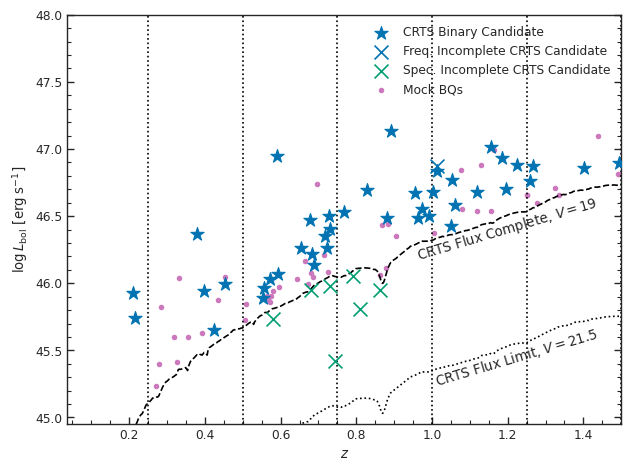

In [167]:
mock_bq_pop_complete_plt = mock_bq_pop_complete.sample(frac=S_CRTS, replace=False)
reduced_crts_complete_plt = reduced_crts_complete.sample(n=N_CRTS_MAX_REAL_q[1].astype(int), replace=False, weights='weight')

plt.figure()

plt.scatter(reduced_crts_complete_plt['z'], reduced_crts_complete_plt['log_l_bol'], color=cs[0],
            label='CRTS Binary Candidate', marker='*', s=100, zorder=10, rasterized=True)
plt.scatter(crts_f_incomplete['z'], crts_f_incomplete['log_l_bol'],
            color=cs[0], label='Freq. Incomplete CRTS Candidate', marker='x',
            s=100, zorder=10, rasterized=True)
plt.scatter(crts_spec_incomplete['z'], crts_spec_incomplete['log_l_bol'],
            color=cs[2], label='Spec. Incomplete CRTS Candidate', marker='x',
            s=100, zorder=10, rasterized=True)

plt.scatter(mock_bq_pop_complete_plt['z'], mock_bq_pop_complete_plt['log_l_bol'], color=cs[4], label='Mock BQs', rasterized=True)


plt.plot(
    z_plot, 
    log_l_bol_complete_crts_fn(z_plot), 
    color='k', 
    linestyle='--', 
    # label='CRTS flux completeness limit'
)
plt.text(
    z_plot[-475],
    log_l_bol_complete_crts_fn(z_plot[-475])-.05,
    r'CRTS Flux Complete, $V = 19$',
    # textcoords='offset pixels',
    # xytext=(0, -10),
    ha='right',
    va='top',
    transform_rotates_text=True, 
    rotation=40,
    rotation_mode='anchor',
)
plt.plot(
    z_plot,
    log_l_bol_max_crts_fn(z_plot), 
    color='k', 
    linestyle=':', 
    # label='CRTS maximum depth'
)
plt.text(
    z_plot[-475],
    log_l_bol_max_crts_fn(z_plot[-475])-.05,
    r'CRTS Flux Limit, $V = 21.5$',
    # textcoords='offset pixels',
    # xytext=(0, -10),
    ha='right',
    va='top',
    transform_rotates_text=True, 
    rotation=40,
    rotation_mode='anchor',
)

for edge in z_bins:
    plt.axvline(edge, color='k', linestyle=':', rasterized=True)

plt.xlabel(r'$z$')
plt.ylabel(r'$\log L_{\rm bol} \ [\rm{erg} \; \rm{s}^{-1}]$')

plt.xlim(Z_MIN, Z_MAX)
plt.ylim(LOG_LBOL_MIN, LOG_LBOL_MAX)

plt.legend(loc=0, frameon=False)

plt.tight_layout()
plt.savefig('../reports/figures/mock_bq_pop_complete_binned.pdf')
plt.show()

We also want to make use of the actual CRTS candidates in future modeling. This can be done by simply excising mock binary candidates from the spectroscopic and frequency complete region from our population and adding the spectroscopic and frequency complete CRTS candidates. Ultimately we will be doing all our actual modeling with a redshift-bin-matched population, but we can set up the technique here.

In [168]:
mock_bq_pop_incomplete = mock_bq_pop[~mock_bq_spec_complete
                                     | ~mock_bq_f_complete
                                    ]

# next add in some mock complete binaries to account for sky coverage and data quality
n_unobs = np.random.poisson(N_MOCK_COMPLETE * (1 - S_sky * S_qual))
mock_bq_pop_incomplete = pd.concat([mock_bq_pop_incomplete, mock_bq_pop_complete.sample(n_unobs, replace=False)])
mock_bq_pop_incomplete.to_csv('../data/processed/mock_bq_pop_incomplete.csv', index=False)
mock_bq_pop_incomplete

,log_l_bol,z,log_mbh,f_gw,log_f_gw,q,strain,weight
0,45.042571,0.209131,7.960723,2.874031e-09,-8.541508,0.694267,7.414283e-19,1.0
1,45.009330,0.246379,7.619420,1.922837e-09,-8.716058,0.787001,1.322423e-19,1.0
2,44.996086,0.195981,8.014470,1.625834e-09,-8.788924,0.746331,6.733427e-19,1.0
3,45.285912,0.248590,8.713034,1.000485e-09,-8.999790,0.833859,5.670731e-18,1.0
4,44.995776,0.131141,8.692103,2.360633e-09,-8.626972,0.975402,1.781104e-17,1.0
...,...,...,...,...,...,...,...,...
1388465,46.188909,0.905169,8.734333,1.295804e-08,-7.887461,0.416674,8.031235e-18,1.0
48844,45.234324,0.270854,7.797850,1.159364e-08,-7.935780,0.730879,7.819559e-19,1.0
1249634,46.063750,0.863792,9.184169,1.344640e-08,-7.871394,0.967498,5.815615e-17,1.0
430223,46.209821,0.714333,8.708839,1.081345e-08,-7.966036,0.944843,9.697430e-18,1.0


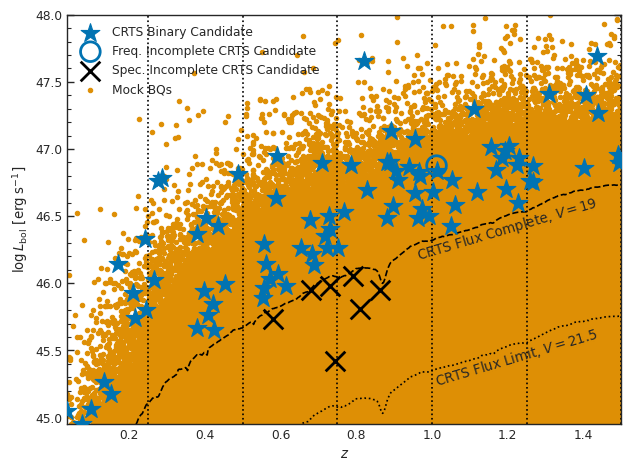

In [169]:
plt.figure()

plt.scatter(reduced_crts_complete['z'], reduced_crts_complete['log_l_bol'], color=cs[0],
            label='CRTS Binary Candidate', marker='*', s=200, zorder=10, rasterized=True)
plt.scatter(
    crts_f_incomplete['z'], 
    crts_f_incomplete['log_l_bol'], 
    facecolor="None",
    edgecolor=cs[0], 
    label='Freq. Incomplete CRTS Candidate', 
    marker='o',
    s=200, 
    zorder=10, 
    rasterized=True, 
    linewidth=2
)
plt.scatter(
    crts_spec_incomplete['z'], 
    crts_spec_incomplete['log_l_bol'], 
    # facecolor="None",
    color='k', 
    label='Spec. Incomplete CRTS Candidate', 
    marker='x',
    s=200, 
    zorder=10, 
    rasterized=True, 
    linewidth=2
)

plt.scatter(mock_bq_pop_incomplete['z'], mock_bq_pop_incomplete['log_l_bol'], color=cs[1], label='Mock BQs', rasterized=True, s=10)


plt.plot(
    z_plot, 
    log_l_bol_complete_crts_fn(z_plot), 
    color='k', 
    linestyle='--', 
    # label='CRTS flux completeness limit'
)
plt.text(
    z_plot[-475],
    log_l_bol_complete_crts_fn(z_plot[-475])-.05,
    r'CRTS Flux Complete, $V = 19$',
    # textcoords='offset pixels',
    # xytext=(0, -10),
    ha='right',
    va='top',
    transform_rotates_text=True, 
    rotation=40,
    rotation_mode='anchor',
)
plt.plot(
    z_plot,
    log_l_bol_max_crts_fn(z_plot), 
    color='k', 
    linestyle=':', 
    # label='CRTS maximum depth'
)
plt.text(
    z_plot[-475],
    log_l_bol_max_crts_fn(z_plot[-475])-.05,
    r'CRTS Flux Limit, $V = 21.5$',
    # textcoords='offset pixels',
    # xytext=(0, -10),
    ha='right',
    va='top',
    transform_rotates_text=True, 
    rotation=40,
    rotation_mode='anchor',
)

for edge in z_bins:
    plt.axvline(edge, color='k', linestyle=':', rasterized=True)

plt.xlabel(r'$z$')
plt.ylabel(r'$\log L_{\rm bol} \ [\rm{erg} \; \rm{s}^{-1}]$')

plt.xlim(Z_MIN, Z_MAX)
plt.ylim(LOG_LBOL_MIN, LOG_LBOL_MAX)

plt.legend(loc=0, frameon=False)

plt.tight_layout()
plt.savefig('../reports/figures/mock_bq_pop_combined_binned.pdf')
plt.show()

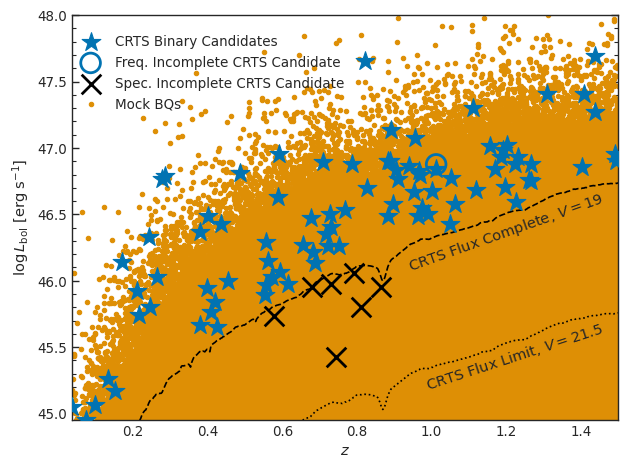

In [170]:
sns.set_context(context, font_scale=1.1)
plt.figure()

plt.scatter(reduced_crts_complete['z'], reduced_crts_complete['log_l_bol'], color=cs[0],
            label='CRTS Binary Candidates', marker='*', s=200, zorder=10, rasterized=True)
plt.scatter(
    crts_f_incomplete['z'], 
    crts_f_incomplete['log_l_bol'], 
    facecolor="None",
    edgecolor=cs[0], 
    label='Freq. Incomplete CRTS Candidate', 
    marker='o',
    s=200, 
    zorder=10, 
    rasterized=True, 
    linewidth=2
)
plt.scatter(
    crts_spec_incomplete['z'], 
    crts_spec_incomplete['log_l_bol'], 
    # facecolor="None",
    color='k', 
    label='Spec. Incomplete CRTS Candidate', 
    marker='x',
    s=200, 
    zorder=10, 
    rasterized=True, 
    linewidth=2
)

plt.scatter(mock_bq_pop_incomplete['z'], mock_bq_pop_incomplete['log_l_bol'], color=cs[1], label='Mock BQs', 
            s=10,
            rasterized=True)


plt.plot(
    z_plot, 
    log_l_bol_complete_crts_fn(z_plot), 
    color='k', 
    linestyle='--', 
    # label='CRTS flux completeness limit'
)
plt.text(
    1.45,
    log_l_bol_complete_crts_fn(z_plot[-450])-.05,
    r'CRTS Flux Complete, $V = 19$',
    # textcoords='offset pixels',
    # xytext=(0, -10),
    ha='right',
    va='top',
    transform_rotates_text=True, 
    rotation=45,
    rotation_mode='anchor',
)
plt.plot(
    z_plot,
    log_l_bol_max_crts_fn(z_plot), 
    color='k', 
    linestyle=':', 
    # label='CRTS maximum depth'
)
plt.text(
    1.45,
    log_l_bol_max_crts_fn(z_plot[-450])-.05,
    r'CRTS Flux Limit, $V = 21.5$',
    # textcoords='offset pixels',
    # xytext=(0, -10),
    ha='right',
    va='top',
    transform_rotates_text=True, 
    rotation=42.5,
    rotation_mode='anchor',
)

# for edge in z_bins:
#     plt.axvline(edge, color='k', linestyle=':', rasterized=True)

plt.xlabel(r'$z$')
plt.ylabel(r'$\log L_{\rm bol} \ [\rm{erg} \; \rm{s}^{-1}]$')

plt.xlim(Z_MIN, Z_MAX)
plt.ylim(LOG_LBOL_MIN, LOG_LBOL_MAX)

plt.legend(loc=(0, .75), frameon=False)

plt.tight_layout()
plt.savefig('../reports/figures/mock_bq_pop_combined_binned_nolines.pdf')
plt.show()

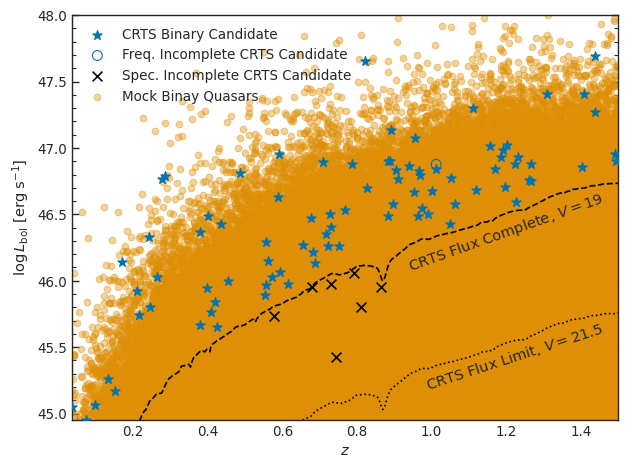

In [171]:
plt.figure()

plt.scatter(
    reduced_crts_complete['z'],
    reduced_crts_complete['log_l_bol'],
    color=cs[0],
    label='CRTS Binary Candidate', 
    marker='*', 
    s=50, 
    zorder=10, 
    rasterized=True
)
plt.scatter(
    crts_f_incomplete['z'],
    # [45.5],
    crts_f_incomplete['log_l_bol'],
    color=cs[0],
    # color='red',
    label='Freq. Incomplete CRTS Candidate',
    marker='o',
    s=50,
    zorder=10,
    rasterized=True, 
    # edgecolors='k', 
    facecolor='None',
    # linewidth=2
)
plt.scatter(
    crts_spec_incomplete['z'],
    crts_spec_incomplete['log_l_bol'],
    color='k',
    label='Spec. Incomplete CRTS Candidate',
    marker='x',
    s=50,
    zorder=10,
    rasterized=True, 
    # edgecolors='k', 
    # linewidth=2
)

plt.scatter(
    mock_bq_pop_incomplete['z'], 
    mock_bq_pop_incomplete['log_l_bol'], 
    color=cs[1], 
    label='Mock Binay Quasars', 
    # s=10,
    alpha=.4,
    rasterized=True
)

plt.plot(
    z_plot, 
    log_l_bol_complete_crts_fn(z_plot), 
    color='k', 
    linestyle='--', 
    # label='CRTS flux completeness limit'
)
plt.text(
    1.45,
    log_l_bol_complete_crts_fn(z_plot[-450])-.05,
    r'CRTS Flux Complete, $V = 19$',
    # textcoords='offset pixels',
    # xytext=(0, -10),
    ha='right',
    va='top',
    transform_rotates_text=True, 
    rotation=45,
    rotation_mode='anchor',
)
plt.plot(
    z_plot,
    log_l_bol_max_crts_fn(z_plot), 
    color='k', 
    linestyle=':', 
    # label='CRTS maximum depth'
)
plt.text(
    1.45,
    log_l_bol_max_crts_fn(z_plot[-450])-.05,
    r'CRTS Flux Limit, $V = 21.5$',
    # textcoords='offset pixels',
    # xytext=(0, -10),
    ha='right',
    va='top',
    transform_rotates_text=True, 
    rotation=42.5,
    rotation_mode='anchor',
)

# for edge in z_bins:
#     plt.axvline(edge, color='k', linestyle=':', rasterized=True)

plt.xlabel(r'$z$')
plt.ylabel(r'$\log L_{\rm bol} \ [\rm{erg} \; \rm{s}^{-1}]$')

plt.xlim(Z_MIN, Z_MAX)
plt.ylim(LOG_LBOL_MIN, LOG_LBOL_MAX)

plt.legend(loc='upper left', frameon=False)

plt.tight_layout()
plt.savefig('../reports/figures/mock_bq_pop_combined_binned_nolines_alpha.pdf')
plt.show()

In [172]:
# crts_complete['q'] = q_dist.rvs(size=len(crts_complete))

bq_pop = pd.concat([mock_bq_pop_incomplete, reduced_crts_complete], ignore_index=True)
bq_pop.to_csv('../data/processed/bq_pop.csv', index=False)
bq_pop

,log_l_bol,z,log_mbh,f_gw,log_f_gw,q,strain,weight,Name
0,45.042571,0.209131,7.960723,2.874031e-09,-8.541508,0.694267,7.414283e-19,1.000000,NaN
1,45.009330,0.246379,7.619420,1.922837e-09,-8.716058,0.787001,1.322423e-19,1.000000,NaN
2,44.996086,0.195981,8.014470,1.625834e-09,-8.788924,0.746331,6.733427e-19,1.000000,NaN
3,45.285912,0.248590,8.713034,1.000485e-09,-8.999790,0.833859,5.670731e-18,1.000000,NaN
4,44.995776,0.131141,8.692103,2.360633e-09,-8.626972,0.975402,1.781104e-17,1.000000,NaN
...,...,...,...,...,...,...,...,...,...
4929814,47.300553,1.111000,9.621955,2.153316e-08,-7.666892,0.793015,3.351880e-16,0.139113,4C 50.43
4929815,47.406671,1.309000,10.071398,1.736545e-08,-7.760314,0.969073,1.429698e-15,0.072933,BZQJ2156-2012
4929816,46.350987,0.717000,8.146641,1.736545e-08,-7.760314,0.574003,1.420954e-18,1.000000,SDSS J221016.97+122213.9
4929817,45.924424,0.211000,9.019766,1.342700e-08,-7.872021,0.586010,1.151604e-16,0.096344,HS 2219+1944


# Smaller dataset

Finally, before we fit these populations let's save a sky and quality matched binary dataset. This is primarily required because otherwise the kernel dies when we try to fit our binary quasar populations :').

In [173]:
n_sky_mock_bqs = np.random.poisson(len(mock_bq_pop) * S_sky * S_qual)
sky_mock_bq_pop = mock_bq_pop.sample(n_sky_mock_bqs, replace=False)

In [174]:
# Let's briefly check how this compares to the 87 spectroscopically and
# frequency complete candidates in the reduced sample
# We need to account for sky coverage and quality completeness here
sky_mock_bq_spec_complete = (sky_mock_bq_pop['log_l_bol']
                      >= log_l_bol_complete_crts_fn(sky_mock_bq_pop['z']))
sky_mock_bq_f_complete = sky_mock_bq_pop['log_f_gw'] >= LOG_F_MIN_CRTS
sky_mock_bq_pop_complete = sky_mock_bq_pop[sky_mock_bq_spec_complete
                                   & sky_mock_bq_f_complete]
sky_mock_bq_pop_complete.to_csv('../data/processed/sky_mock_bq_pop_complete.csv', index=False)
sky_mock_bq_pop_complete

,log_l_bol,z,log_mbh,f_gw,log_f_gw,q,strain,weight
574995,45.979443,0.516887,8.703523,1.425325e-08,-7.846086,0.947044,1.561671e-17,1.0
2265977,46.378038,1.004442,8.706855,2.821771e-08,-7.549478,0.810288,1.314718e-17,1.0
582298,45.964763,0.610163,9.043717,5.712048e-08,-7.243208,0.853652,1.230202e-16,1.0
4376680,46.858910,1.417761,9.538680,1.549794e-08,-7.809726,0.369391,1.262785e-16,1.0
430223,46.209821,0.714333,8.708839,1.081345e-08,-7.966036,0.944843,9.697430e-18,1.0
1642815,46.340374,0.935351,9.085418,2.332778e-08,-7.632127,0.931560,5.335497e-17,1.0
553526,45.842262,0.507358,9.126843,1.160583e-08,-7.935324,0.853834,7.001061e-17,1.0
35990,45.923973,0.437170,8.819621,1.689820e-08,-7.772160,0.764199,3.165810e-17,1.0
969351,46.462846,0.841246,8.600083,1.246526e-08,-7.904299,0.875869,5.999077e-18,1.0
1656718,46.156208,0.754984,8.853498,1.504730e-08,-7.822541,0.830491,1.982571e-17,1.0


In [175]:
sky_mock_bq_pop_incomplete = sky_mock_bq_pop[~sky_mock_bq_spec_complete
                                     | ~sky_mock_bq_f_complete]

sky_mock_bq_pop_incomplete.to_csv('../data/processed/sky_mock_bq_pop_incomplete.csv', index=False)
sky_mock_bq_pop_incomplete

,log_l_bol,z,log_mbh,f_gw,log_f_gw,q,strain,weight
3902279,45.287188,1.434244,8.249775,1.218083e-09,-8.914323,0.520249,1.864006e-19,1.0
3129377,45.005662,1.012503,8.571140,1.001233e-09,-8.999465,0.519346,7.617864e-19,1.0
797994,45.073251,0.885866,8.056006,1.120214e-09,-8.950699,0.972411,1.427780e-19,1.0
3956635,46.094022,1.376666,8.487953,3.169335e-09,-8.499032,0.817105,1.001284e-18,1.0
4552034,45.546780,1.300271,8.711126,1.052801e-09,-8.977654,0.614088,1.131410e-18,1.0
...,...,...,...,...,...,...,...,...
1551551,44.958964,0.984877,8.652170,1.020513e-09,-8.991182,0.900894,1.196561e-18,1.0
249887,45.030483,0.720855,7.462894,1.006127e-09,-8.997347,0.817772,1.639640e-20,1.0
4118531,45.379065,1.269939,7.965019,1.037236e-09,-8.984122,0.651376,6.613825e-20,1.0
2155251,45.121009,1.130103,8.411592,1.108453e-09,-8.955283,0.821814,4.407061e-19,1.0


In [176]:
from astropy.cosmology import z_at_value

z_at_value(cosmo.comoving_distance, 5.5 * u.Gpc)

<Quantity 2.14467192 redshift>

In [177]:
# crts_complete['q'] = q_dist.rvs(size=len(crts_complete))
sky_bq_pop = pd.concat([sky_mock_bq_pop_incomplete,
                        reduced_crts_complete], ignore_index=True)
sky_bq_pop.to_csv('../data/processed/sky_bq_pop.csv', index=False)
sky_bq_pop

,log_l_bol,z,log_mbh,f_gw,log_f_gw,q,strain,weight,Name
0,45.287188,1.434244,8.249775,1.218083e-09,-8.914323,0.520249,1.864006e-19,1.000000,NaN
1,45.005662,1.012503,8.571140,1.001233e-09,-8.999465,0.519346,7.617864e-19,1.000000,NaN
2,45.073251,0.885866,8.056006,1.120214e-09,-8.950699,0.972411,1.427780e-19,1.000000,NaN
3,46.094022,1.376666,8.487953,3.169335e-09,-8.499032,0.817105,1.001284e-18,1.000000,NaN
4,45.546780,1.300271,8.711126,1.052801e-09,-8.977654,0.614088,1.131410e-18,1.000000,NaN
...,...,...,...,...,...,...,...,...,...
1196346,47.300553,1.111000,9.621955,2.153316e-08,-7.666892,0.793015,3.351880e-16,0.139113,4C 50.43
1196347,47.406671,1.309000,10.071398,1.736545e-08,-7.760314,0.969073,1.429698e-15,0.072933,BZQJ2156-2012
1196348,46.350987,0.717000,8.146641,1.736545e-08,-7.760314,0.574003,1.420954e-18,1.000000,SDSS J221016.97+122213.9
1196349,45.924424,0.211000,9.019766,1.342700e-08,-7.872021,0.586010,1.151604e-16,0.096344,HS 2219+1944


It turns out this is still really big. Thus we'll also cut out anything where the frequency is too low. Essentially, we will keep just the mock binaries that fill in the luminosity and redshift sensitivity, and will correct for frequency sensitivity after the fact. This will result in around 5000-6000 mock binaries + CRTS candidates, which should be reasonable.

In [178]:
sky_freq_mock_bq_pop_complete = sky_mock_bq_pop[sky_mock_bq_spec_complete
                                     & sky_mock_bq_f_complete]

sky_freq_mock_bq_pop_complete.to_csv('../data/processed/sky_freq_mock_bq_pop_complete.csv', index=False)
sky_freq_mock_bq_pop_complete

,log_l_bol,z,log_mbh,f_gw,log_f_gw,q,strain,weight
574995,45.979443,0.516887,8.703523,1.425325e-08,-7.846086,0.947044,1.561671e-17,1.0
2265977,46.378038,1.004442,8.706855,2.821771e-08,-7.549478,0.810288,1.314718e-17,1.0
582298,45.964763,0.610163,9.043717,5.712048e-08,-7.243208,0.853652,1.230202e-16,1.0
4376680,46.858910,1.417761,9.538680,1.549794e-08,-7.809726,0.369391,1.262785e-16,1.0
430223,46.209821,0.714333,8.708839,1.081345e-08,-7.966036,0.944843,9.697430e-18,1.0
1642815,46.340374,0.935351,9.085418,2.332778e-08,-7.632127,0.931560,5.335497e-17,1.0
553526,45.842262,0.507358,9.126843,1.160583e-08,-7.935324,0.853834,7.001061e-17,1.0
35990,45.923973,0.437170,8.819621,1.689820e-08,-7.772160,0.764199,3.165810e-17,1.0
969351,46.462846,0.841246,8.600083,1.246526e-08,-7.904299,0.875869,5.999077e-18,1.0
1656718,46.156208,0.754984,8.853498,1.504730e-08,-7.822541,0.830491,1.982571e-17,1.0


In [179]:
len(sky_freq_mock_bq_pop_complete)

47

In [180]:
sky_freq_mock_bq_pop_incomplete = sky_mock_bq_pop[~sky_mock_bq_spec_complete
                                     & sky_mock_bq_f_complete]

sky_freq_mock_bq_pop_incomplete.to_csv('../data/processed/sky_freq_mock_bq_pop_incomplete.csv', index=False)
sky_freq_mock_bq_pop_incomplete

,log_l_bol,z,log_mbh,f_gw,log_f_gw,q,strain,weight
1946719,45.645134,1.180098,8.310577,1.536703e-08,-7.813410,0.454616,1.441359e-18,1.0
1847855,45.881529,1.125817,8.674412,1.107216e-08,-7.955768,0.808875,5.614245e-18,1.0
1621049,45.420126,0.769492,8.294936,1.111061e-08,-7.954262,0.794807,1.856520e-18,1.0
4551107,45.246417,1.398696,8.434552,1.283214e-08,-7.891701,0.586054,1.924603e-18,1.0
2616488,45.520307,1.075874,8.218143,2.326485e-08,-7.633300,0.733296,1.643985e-18,1.0
...,...,...,...,...,...,...,...,...
2977019,46.001868,1.067235,8.941479,1.131478e-08,-7.946354,0.908297,1.679964e-17,1.0
3842302,45.800566,1.393779,9.044885,1.117131e-08,-7.951896,0.819199,1.945649e-17,1.0
4251730,45.527339,1.256833,8.011586,1.236355e-08,-7.907857,0.843643,4.326744e-19,1.0
2923442,45.173651,1.205071,8.635785,1.219443e-08,-7.913838,0.429108,4.131573e-18,1.0


In [181]:
# crts_complete['q'] = q_dist.rvs(size=len(crts_complete))
sky_freq_bq_pop = pd.concat([sky_freq_mock_bq_pop_incomplete,
                             reduced_crts_complete], ignore_index=True)
sky_freq_bq_pop.to_csv('../data/processed/sky_freq_bq_pop.csv', index=False)
sky_freq_bq_pop

,log_l_bol,z,log_mbh,f_gw,log_f_gw,q,strain,weight,Name
0,45.645134,1.180098,8.310577,1.536703e-08,-7.813410,0.454616,1.441359e-18,1.000000,NaN
1,45.881529,1.125817,8.674412,1.107216e-08,-7.955768,0.808875,5.614245e-18,1.000000,NaN
2,45.420126,0.769492,8.294936,1.111061e-08,-7.954262,0.794807,1.856520e-18,1.000000,NaN
3,45.246417,1.398696,8.434552,1.283214e-08,-7.891701,0.586054,1.924603e-18,1.000000,NaN
4,45.520307,1.075874,8.218143,2.326485e-08,-7.633300,0.733296,1.643985e-18,1.000000,NaN
...,...,...,...,...,...,...,...,...,...
2322,47.300553,1.111000,9.621955,2.153316e-08,-7.666892,0.793015,3.351880e-16,0.139113,4C 50.43
2323,47.406671,1.309000,10.071398,1.736545e-08,-7.760314,0.969073,1.429698e-15,0.072933,BZQJ2156-2012
2324,46.350987,0.717000,8.146641,1.736545e-08,-7.760314,0.574003,1.420954e-18,1.000000,SDSS J221016.97+122213.9
2325,45.924424,0.211000,9.019766,1.342700e-08,-7.872021,0.586010,1.151604e-16,0.096344,HS 2219+1944


In [182]:
reduced_crts_complete.to_csv('../data/processed/reduced_crts_complete.csv', index=False)